<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/AUDUSD/AUDUSD_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AUDUSD=X"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  0.7055  0.7138  0.6919  0.7050     0.7050       0
2009-01-02  0.7050  0.7120  0.6925  0.7093     0.7093       0
2009-01-05  0.7156  0.7194  0.7067  0.7143     0.7143       0
2009-01-06  0.7140  0.7264  0.7040  0.7204     0.7204       0
2009-01-07  0.7200  0.7260  0.7099  0.7103     0.7103       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  0.7049  0.7072  0.7033  0.7046     0.7046       0
2018-12-27  0.7073  0.7078  0.7018  0.7075     0.7075       0
2018-12-28  0.7034  0.7069  0.7031  0.7035     0.7035       0
2018-12-31  0.7043  0.7073  0.7036  0.7045     0.7045       0
2019-01-01  0.7042  0.7110  0.7015  0.7042     0.7042       0

[2604 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2604.000000  2604.000000  2604.000000  2604.000000  2604.000000  2604.0
mean      0.866171     0.870247     0.862117     0.866226     0.866226     0.0
std       0.121669     0.121901     0.121360     0.121630     0.121630     0.0
min       0.629700     0.636200     0.625300     0.629500     0.629500     0.0
25%       0.757300     0.760875     0.754500     0.757475     0.757475     0.0
50%       0.868000     0.873300     0.864600     0.868800     0.868800     0.0
75%       0.978025     0.985550     0.972850     0.977925     0.977925     0.0
max       1.103500     1.108100     1.100500     1.103500     1.103500     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.6483  0.6572  0.6418  0.6542     0.6542   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.643956  0.633754 -0.663018  0.648022  0.645818  0.648313     0.64450     0.64330  0.630320  0.643900  0.651069  0.642550  0.645847  0.643900  0.650167  0.644458                0.656112                 0.643900                0.631688                0.662218                 0.643900                0.625582                0.668324                 0.643900                0.619476                0.674430                 0.643900                0.613370  0.645818  0.649919  0.643824                0.658030                 0.645818                0.633606                0.664136                 0.645818                0.627500                0.670242                 0.645818                0.621394                0.676348                 0.645818                0.615288   
2009-03-13  0.6542  0.6601  0.6524  0.6584     0.6584   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.644678  0.634027 -0.661633  0.652503  0.648614  0.649264     0.64660     0.64475  0.632470  0.646463  0.656183  0.644700  0.649069  0.646463  0.656300  0.644518                0.660954                 0.646463                0.631971                0.668199                 0.646463                0.624726                0.675445                 0.646463                0.617480                0.682690                 0.646463                0.610235  0.648614  0.656193  0.644051                0.663105                 0.648614                0.634123                0.670351                 0.648614                0.626877                0.677596                 0.648614                0.619632                0.684842                 0.648614                0.612386   
2009-03-16  0.6567  0.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter        week      weekday  weekday_name  weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000    2554.000000   2554.000000     2554.000000     2554.000000       2554.000000  2554.000000  2554.000000  2554.00000  2554.000000   2554.000000  2554.00000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000  2554.000000  2554.000000  2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000   
mean      0.870181     0.874201     0.866218     0.870256     0.870256    15.766249     2.000000   185.829287      30.467502      0.033281        0.966719        0.010963          0.989037     6.612373     2.536022    26.99491     2.000000      1.999217    26.99491     0.870154     0.869770    -0.003715     0.870263     0.870169     0.870076     0.870045     0.869882     0.869528     0.870172     0.870259     0.870173     0.870201     0.870172     0.870250     0.869979                0.882410                 0.870172                0.857934                0.888529                 0.870172                0.851815                0.894648                 0.870172                0.845696                0.900767                 0.870172                0.839577     0.870169     0.870243     0.870009                0.882407                 0.870169                0.857931                0.888526                 0.870169                0.851812                0.894645   
std       0.119346     0.119687     0.118873     0.119274     0.119274     8.806032     1.415044   104.391452       0.781645      0.179405        0.179405        0.104150          0.104150     3.413772     1.107816    14.92812     1.415044      1.414490    14.92812     0.119095     0.119065     0.877857     0.119353     0.119106     0.119349     0.119088     0.118936     0.119270     0.119205     0.119324     0.119250     0.119191     0.119205     0.119259     0.119141                0.120940                 0.119205                0.117850                0.121945                 0.119205                0.117319                0.123038                 0.119205                0.116888                0.124218                 0.119205                0.116557     0.119106     0.119226     0.119149                0.120842                 0.119106                0.117751                0.121847                 0.119106                0.117220                0.122941   
min       0.648300     0.657200     0.641800     0.654200     0.654200     1.000000     0.000000     1

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.000000  0.000000  0.000000  0.000000   0.000000   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.000000  0.000000  0.203542  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.001271                0.000000                 0.000000                0.013016                0.000000                 0.000000                0.027599                0.000000                 0.000000                0.049823  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000000                0.000000                 0.000000                0.009351                0.000000                 0.000000                0.023766                0.000000                 0.000000   
2009-03-13  0.012961  0.006432  0.023109  0.009348   0.009348   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.001617  0.000614  0.204175  0.009872  0.006245  0.002135    0.004675    0.003218  0.004501  0.005693  0.011280  0.004735  0.007137  0.005693  0.013609  0.000136                0.010213                 0.005693                0.001905                0.011987                 0.005693                0.011118                0.013591                 0.005693                0.023222                0.015050                 0.005693                0.043113  0.006245  0.013905  0.000516                0.011033                 0.006245                0.001163                0.012816                 0.006245                0.007958                0.014424                 0.006245                0.019865                0.015882                 0.006245   
2009-03-16  0.018453  0.015081  0.028995  0.012019   0.012019   16          0         75

138084

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         5 hours 3 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_4u1hm8
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.581835  0.803395              0.492857  0.545578  0.297655
1  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.564717  0.783210              0.478571  0.534897  0.286115
2  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.503079  0.870001              0.456527  0.554402  0.307362
3  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.500000  0.751039              0.500000  0.527380  0.278129
4  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.500000  0.700995              0.500000  0.503903  0.253918
5  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.500000  0.699995              0.500000  0.503408  0.253420
6              DeepLearning_1_AutoML_20190822_151535  0.500000  0.693461              0.500000  0.500157  0.250157
7  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.488978  2.209868              0.500000  0.643774  0.414445
8  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.476170  0.701101              0.500000  0.503955  0.253971
9  DeepLearning_grid_1_AutoML_20190822_151535_mod...  0.454403  0.699847              0.500000  0.503335  0.253346

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.004250
1               CDLRICKSHAWMAN             0.823317           0.823317    0.003499
2                          SUB             0.747113           0.747113    0.003175
3                          DIV             0.669273           0.669273    0.002844
4                      weekday             0.598832           0.598832    0.002545
...                        ...                  ...                ...         ...
1021  BBANDS_middleband_14_6_4             0.179440           0.179440    0.000763
1022  BBANDS_middleband_24_3_4             0.179265           0.179265    0.000762
1023        CDLSEPARATINGLINES             0.177568           0.177568    0.000755
1024   BBANDS_upperband_12_1_3             0.174322           0.174322    0.000741
1025              CDLTASUKIGAP             0.171299           0.171299    0.000728

[1026 rows x 4 columns]

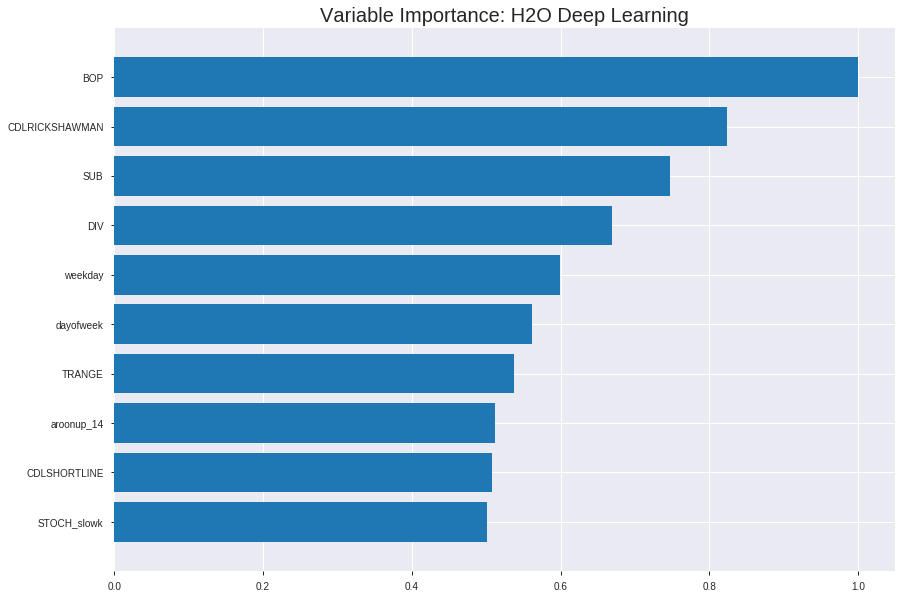

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_151535_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24452134920774946
RMSE: 0.49449100012816155
LogLoss: 0.6863115756680648
Mean Per-Class Error: 0.39319215303092936
AUC: 0.6333038946722287
pr_auc: 0.6105364555328968
Gini: 0.2666077893444574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19287325905430577: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      116  786   0.8714   (786.0/902.0)
1      27   858   0.0305   (27.0/885.0)
Total  143  1644  0.455    (813.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.192873     0.678529  351
max f2                       0.140292     0.833492  371
max f0point5                 0.500793     0.602151  191
max accuracy                 0.500793     0.607163  191
max precision                0.978283     1         0
max recall                   0.0598057    1         395
max specificity              0.978283     1         0
max absolute_mcc             0.500793     0.214237  191
max min_per_class_accuracy   0.472093     0.596452  206
max mean_per_class_accuracy  0.500793     0.606808  191

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 48.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.897455           1.90703   1.90703            0.944444         0.922764  0.944444                    0.922764            0.019209        0.019209                   90.7031   90.7031
    2        0.0201455                   0.87621            1.45832   1.68267            0.722222         0.88479   0.833333                    0.903777            0.0146893       0.0338983                  45.8318   68.2674
    3        0.0302182                   0.856334           1.12178   1.49571            0.555556         0.865552  0.740741                    0.891035            0.0112994       0.0451977                  12.1783   49.571
    4        0.040291                    0.840286           1.34614   1.45832            0.666667         0.84655   0.722222                    0.879914            0.0135593       0.0587571                  34.6139   45.8318
    5        0.0503637                   0.828348           1.34614   1.43588            0.666667         0.834735  0.711111                    0.870878            0.0135593       0.0723164                  34.6139   43.5882
    6        0.100168                    0.772879           1.15707   1.29726            0.573034         0.799779  0.642458                    0.835527            0.0576271       0.129944                   15.7075   29.7257
    7        0.149972                    0.726779           1.36126   1.31851            0.674157         0.750174  0.652985                    0.807182            0.0677966       0.19774                    36.1265   31.8513
    8        0.200336                    0.683973           1.12178   1.26906            0.555556         0.706333  0.628492                    0.781829            0.0564972       0.254237                   12.1783   26.9056
    9        0.299944                    0.603661           1.19111   1.24317            0.589888         0.642302  0.615672                    0.735493            0.118644        0.372881                   19.1106   24.317
    10       0.400112                    0.540233           1.22957   1.23977            0.608939         0.569739  0.613986                    0.693997            0.123164        0.496045                   22.9574   23.9766
    11       0.50028                     0.469563           1.00396   1.19255            0.497207         0.50589   0.590604                    0.656333            0.100565        0.59661                    0.396427  19.2553
    12       0.599888                    0.411346           1.0096    1.16218            0.5              0.442683  0.57556                     0.620858            0.100565        0.697175                   0.960452  16.2175
    13       0.700056                    0.350702           0.879879  1.12178            0.435754         0.382554  0.555556                    0.58676             0.0881356       0.785311                   -12.0121  12.1783
    14       0.799664                    0.288506           0.805415  1.08238            0.398876         0.322324  0.536039                    0.553821            0.080226        0.865537                   -19.4585  8.23752
    15       0.899832                    0.209917           0.868598  1.05858            0.430168         0.250974  0.524254                    0.520109            0.0870056       0.952542                   -13.1402  5.85779
    16       1                           0.0213588          0.473781  1                  0.234637         0.15085   0.495243                    0.483121           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2557337849362036
RMSE: 0.5057012803387031
LogLoss: 0.7114867795615787
Mean Per-Class Error: 0.4213512637218422
AUC: 0.5915175469746329
pr_auc: 0.6072393440202745
Gini: 0.18303509394926576
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29036262273099694: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   220  0.9205   (220.0/239.0)
1      7    264  0.0258   (7.0/271.0)
Total  26   484  0.4451   (227.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290363     0.699338  374
max f2                       0.187686     0.850596  398
max f0point5                 0.404482     0.607804  329
max accuracy                 0.594734     0.576471  202
max precision                0.967595     1         0
max recall                   0.187686     1         398
max specificity              0.967595     1         0
max absolute_mcc             0.677405     0.16201   142
max min_per_class_accuracy   0.616462     0.569038  189
max mean_per_class_accuracy  0.677405     0.578649  142

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 59.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.889987           1.25461   1.25461            0.666667         0.912624  0.666667                    0.912624            0.0147601       0.0147601                  25.4613   25.4613
    2        0.0215686                   0.86859            1.50554   1.36867            0.8              0.878163  0.727273                    0.89696             0.0147601       0.0295203                  50.5535   36.8668
    3        0.0313725                   0.850889           1.12915   1.29382            0.6              0.858545  0.6875                      0.884955            0.0110701       0.0405904                  12.9151   29.3819
    4        0.0411765                   0.842943           0.752768  1.165              0.4              0.845912  0.619048                    0.875659            0.00738007      0.0479705                  -24.7232  16.4997
    5        0.0509804                   0.839443           1.50554   1.23049            0.8              0.841122  0.653846                    0.869017            0.0147601       0.0627306                  50.5535   23.0485
    6        0.1                         0.812827           1.2797    1.25461            0.68             0.826336  0.666667                    0.848095            0.0627306       0.125461                   27.9705   25.4613
    7        0.15098                     0.7943             1.30287   1.27091            0.692308         0.8018    0.675325                    0.832463            0.0664207       0.191882                   30.2867   27.0906
    8        0.2                         0.765922           0.828044  1.16236            0.44             0.783949  0.617647                    0.820572            0.0405904       0.232472                   -17.1956  16.2362
    9        0.3                         0.711525           1.29151   1.20541            0.686275         0.736227  0.640523                    0.792457            0.129151        0.361624                   29.1513   20.5412
    10       0.4                         0.670671           1.07011   1.17159            0.568627         0.690755  0.622549                    0.767032            0.107011        0.468635                   7.01107   17.1587
    11       0.5                         0.617901           0.922509  1.12177            0.490196         0.64587   0.596078                    0.742799            0.0922509       0.560886                   -7.74908  12.1771
    12       0.6                         0.558954           0.885609  1.08241            0.470588         0.588916  0.575163                    0.717152            0.0885609       0.649446                   -11.4391  8.24108
    13       0.7                         0.503596           0.922509  1.05957            0.490196         0.529988  0.563025                    0.690414            0.0922509       0.741697                   -7.74908  5.95677
    14       0.8                         0.445411           1.03321   1.05627            0.54902          0.476392  0.561275                    0.663662            0.103321        0.845018                   3.32103   5.62731
    15       0.9                         0.362268           0.774908  1.02501            0.411765         0.401175  0.544662                    0.634496            0.0774908       0.922509                   -22.5092  2.50103
    16       1                           0.176985           0.774908  1                  0.411765         0.286137  0.531373                    0.59966          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:17:13  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:17:15  1 min 37.100 sec  398 obs/sec       0.520985  1             931        0.676938         10.3638             -0.833146      0.534207        0.355316           1.02082          0.504757                         0.684564           16.1265               -0.881919        0.5               0                    1.0052             0.468627
    2019-08-22 15:17:25  1 min 47.345 sec  399 obs/sec       2.59093   5             4630       0.53061          0.836787            -0.126289      0.630407        0.601506           1.45832          0.476217                         0.514218           0.770674              -0.0618595       0.620235          0.620746             0.940959           0.4
    2019-08-22 15:17:35  1 min 57.674 sec  400 obs/sec       4.69446   9             8389       0.542933         0.837678            -0.179212      0.568352        0.553786           1.5705           0.479015                         0.608349           1.09946               -0.486203        0.632517          0.635299             1.25461            0.411765
    2019-08-22 15:17:47  2 min  9.592 sec  407 obs/sec       7.26189   14            12977      0.549586         0.865187            -0.208286      0.564773        0.545759           1.23396          0.481813                         0.621214           1.20669               -0.549731        0.629499          0.613273             1.25461            0.421569
    2019-08-22 15:17:59  2 min 21.100 sec  415 obs/sec       9.82708   19            17561      0.531451         0.800159            -0.129862      0.59973         0.575405           1.68267          0.459989                         0.610103           1.1215                -0.494787        0.62865           0.627671             1.56827            0.439216
    2019-08-22 15:18:10  2 min 32.180 sec  422 obs/sec       12.3828   24            22128      0.597398         1.35287             -0.427667      0.581673        0.540118           1.68267          0.463346                         0.680949           2.67692               -0.862098        0.639125          0.639864             1.56827            0.4
    2019-08-22 15:18:21  2 min 42.920 sec  430 obs/sec       14.948    29            26712      0.494491         0.686312            0.0218261      0.633304        0.610536           1.90703          0.454952                         0.505701           0.711487              -0.0269783       0.591518          0.607239             1.25461            0.445098

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0042501185554889315
CDLRICKSHAWMAN            0.8233171701431274     0.8233171701431274   0.0034991955818779435
SUB                       0.7471126914024353     0.7471126914024353   0.003175317512770766
DIV                       0.6692728996276855     0.6692728996276855   0.0028444891693935074
weekday                   0.5988321304321289     0.5988321304321289   0.002545107549172559
---                       ---                    ---                  ---
BBANDS_middleband_14_6_4  0.17943991720676422    0.17943991720676422  0.0007626409217158662
BBANDS_middleband_24_3_4  0.1792648732662201     0.1792648732662201   0.0007618969642161337
CDLSEPARATINGLINES        0.1775679737329483     0.1775679737329483   0.0007546849400229748
BBANDS_upperband_12_1_3   0.17432239651679993    0.17432239651679993  0.0007408908520733505
CDLTASUKIGAP              0.17129868268966675    0.17129868268966675  0.0007280397098301633


See the whole table with table.as_data_frame()


('accuracy', 0.60546875)

('F1', 0.6270270270270271)

('auc', 0.5818349753694582)

('logloss', 0.8033946361430804)

('mean_per_class_error', 0.4232758620689655)

('rmse', 0.5455778506183057)

('mse', 0.29765519108529026)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


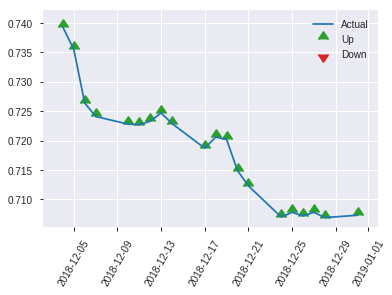


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.29765519108529026
RMSE: 0.5455778506183057
LogLoss: 0.8033946361430804
Mean Per-Class Error: 0.4232758620689655
AUC: 0.5818349753694582
pr_auc: 0.555627992378504
Gini: 0.16366995073891633
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17200774468739305: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    138  0.9857   (138.0/140.0)
1      0    116  0        (0.0/116.0)
Total  2    254  0.5391   (138.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.172008     0.627027  253
max f2                       0.172008     0.807799  253
max f0point5                 0.616015     0.536585  175
max accuracy                 0.827416     0.605469  22
max precision                0.835784     0.857143  13
max recall                   0.172008     1         253
max specificity              0.887235     0.992857  0
max absolute_mcc             0.827416     0.235395  22
max min_per_class_accuracy   0.684033     0.551724  125
max mean_per_class_accuracy  0.756317     0.576724  68

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 64.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.87336            0.735632  0.735632           0.333333         0.882208  0.333333                    0.882208            0.00862069      0.00862069                 -26.4368  -26.4368
    2        0.0234375                   0.862524           2.2069    1.47126            1                0.866325  0.666667                    0.874266            0.0258621       0.0344828                  120.69    47.1264
    3        0.03125                     0.850211           2.2069    1.65517            1                0.857498  0.75                        0.870074            0.0172414       0.0517241                  120.69    65.5172
    4        0.0429688                   0.844462           2.2069    1.80564            1                0.84582   0.818182                    0.86346             0.0258621       0.0775862                  120.69    80.5643
    5        0.0507812                   0.83637            2.2069    1.86737            1                0.8405    0.846154                    0.859927            0.0172414       0.0948276                  120.69    86.7374
    6        0.101562                    0.823111           1.52785   1.69761            0.692308         0.829655  0.769231                    0.844791            0.0775862       0.172414                   52.7851   69.7613
    7        0.152344                    0.796532           0.848806  1.41468            0.384615         0.810583  0.641026                    0.833389            0.0431034       0.215517                   -15.1194  41.4677
    8        0.203125                    0.778451           1.18833   1.35809            0.538462         0.78688   0.615385                    0.821762            0.0603448       0.275862                   18.8329   35.809
    9        0.300781                    0.744723           1.05931   1.26108            0.48             0.761104  0.571429                    0.802068            0.103448        0.37931                    5.93103   26.1084
    10       0.402344                    0.718252           0.763926  1.13559            0.346154         0.729869  0.514563                    0.783843            0.0775862       0.456897                   -23.6074  13.5588
    11       0.5                         0.682796           0.971034  1.10345            0.44             0.700964  0.5                         0.767655            0.0948276       0.551724                   -2.89655  10.3448
    12       0.601562                    0.644268           1.01857   1.08912            0.461538         0.66557   0.493506                    0.75042             0.103448        0.655172                   1.85676   8.91178
    13       0.699219                    0.607598           1.05931   1.08495            0.48             0.626953  0.49162                     0.733176            0.103448        0.758621                   5.93103   8.49547
    14       0.800781                    0.550344           0.679045  1.03347            0.307692         0.580202  0.468293                    0.713775            0.0689655       0.827586                   -32.0955  3.34735
    15       0.898438                    0.409268           0.706207  0.997901           0.32             0.480857  0.452174                    0.688457            0.0689655       0.896552                   -29.3793  -0.209895
    16       1                           0.103642           1.01857   1                  0.461538         0.258515  0.453125                    0.644791       

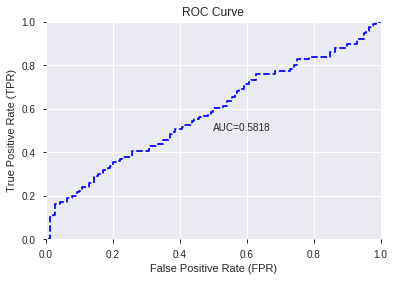

This function is available for GLM models only


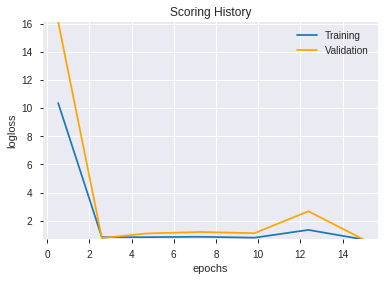

--2019-08-22 15:48:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


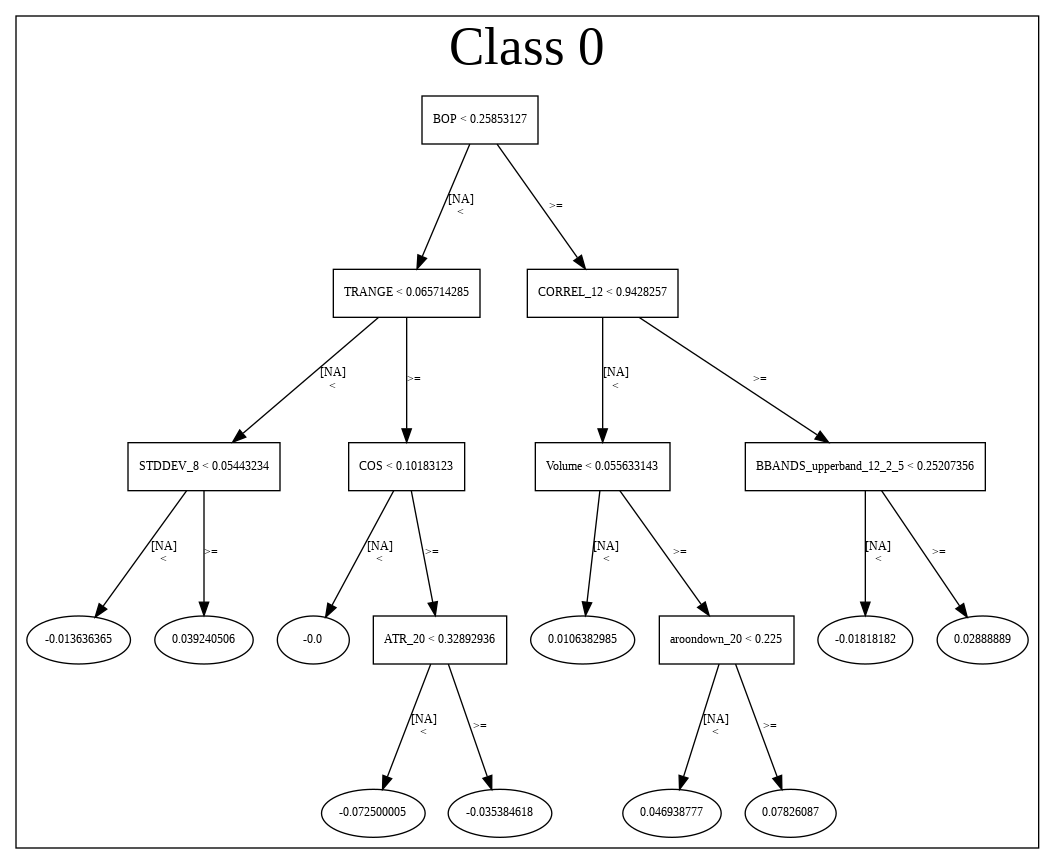

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_151535_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_151535_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_154845_model_5  0.560345  0.692274              0.481527  0.499353  0.249353
1  DeepLearning_grid_1_AutoML_20190822_154845_model_3  0.539224  0.945102              0.492857  0.565832  0.320166
2  DeepLearning_grid_1_AutoML_20190822_154845_model_9  0.538485  0.695608              0.458621  0.501006  0.251007
3               DeepLearning_1_AutoML_20190822_154845  0.538054  0.727661              0.471429  0.512985  0.263154
4  DeepLearning_grid_1_AutoML_20190822_154845_model_8  0.536638  0.765458              0.471429  0.531836  0.282849
5  DeepLearning_grid_1_AutoML_20190822_154845_model_4  0.531897  1.414784              0.500000  0.626830  0.392916
6  DeepLearning_grid_1_AutoML_20190822_154845_model_6  0.525308  0.702712              0.462315  0.503549  0.253562
7  DeepLearning_grid_1_AutoML_20190822_154845_model_2  0.520443  0.808604              0.478571  0.543851  0.295774
8  DeepLearning_grid_1_AutoML_20190822_154845_model_7  0.513608  0.843308              0.475000  0.549483  0.301931
9  DeepLearning_grid_1_AutoML_20190822_154845_model_1  0.508067  1.089016              0.500000  0.600207  0.360248

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.022807
1                    DIV             0.945847           0.945847    0.021572
2                CDLDOJI             0.938074           0.938074    0.021394
3           STOCHF_fastk             0.930217           0.930217    0.021215
4                BETA_30             0.921166           0.921166    0.021009
5         CDLMORNINGSTAR             0.919293           0.919293    0.020966
6    CDLRISEFALL3METHODS             0.918538           0.918538    0.020949
7               CORREL_8             0.906149           0.906149    0.020666
8                 TRANGE             0.904038           0.904038    0.020618
9            CDLHIGHWAVE             0.903831           0.903831    0.020613
10         days_in_month             0.901191           0.901191    0.020553
11            aroonup_30             0.897055           0.897055    0.020459
12                SAREXT             0.893916           0.893916    0.020387
13        CDLRICKSHAWMAN             0.892101           0.892101    0.020346
14             CORREL_30             0.891413           0.891413    0.020330
15           STOCH_slowk             0.888871           0.888871    0.020272
16     CDLGRAVESTONEDOJI             0.887759           0.887759    0.020247
17            aroonup_14             0.887731           0.887731    0.020246
18      CDLDRAGONFLYDOJI             0.881464           0.881464    0.020103
19             dayofyear             0.880648           0.880648    0.020085
20            aroonup_20             0.879965           0.879965    0.020069
21          HT_TRENDMODE             0.879371           0.879371    0.020056
22             dayofweek             0.878585           0.878585    0.020038
23                 month             0.877082           0.877082    0.020003
24        STOCHRSI_fastk             0.876873           0.876873    0.019999
25          weekday_name             0.876815           0.876815    0.019997
26                  DX_8             0.876307           0.876307    0.019986
27                   SUB             0.875550           0.875550    0.019968
28            weekofyear             0.875134           0.875134    0.019959
29      CDLSTICKSANDWICH             0.875125           0.875125    0.019959
30                ULTOSC             0.872995           0.872995    0.019910
31                   day             0.865832           0.865832    0.019747
32         CDLHIKKAKEMOD             0.861794           0.861794    0.019655
33             aroonup_8             0.860265           0.860265    0.019620
34          aroondown_20             0.857983           0.857983    0.019568
35        CDLSPINNINGTOP             0.856136           0.856136    0.019526
36             CDLTAKURI             0.854765           0.854765    0.019494
37             CDLONNECK             0.850860           0.850860    0.019405
38               quarter             0.848652           0.848652    0.019355
39        STOCHRSI_fastd             0.847823           0.847823    0.019336
40            aroonup_12             0.843725           0.843725    0.019243
41           CDLBELTHOLD             0.843490           0.843490    0.019237
42           HT_DCPERIOD             0.842416           0.842416    0.019213
43          aroondown_14             0.841099           0.841099    0.019183
44               weekday             0.839927           0.839927    0.019156
45             CORREL_24             0.837490           0.837490    0.019100
46          STOCHF_fastd             0.836759           0.836759    0.019084
47           AROONOSC_14             0.827571           0.827571    0.018874
48  HT_PHASOR_quadrature             0.798733           0.798733    0.018217
49          CDLSHORTLINE             0.798209           0.798209    0.018205

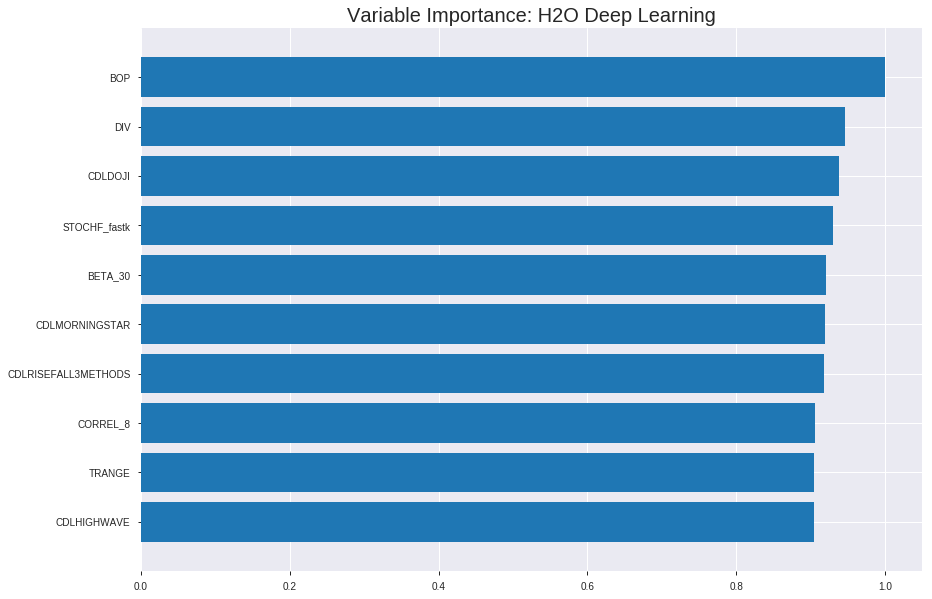

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_154845_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2410361620654036
RMSE: 0.49095433806557165
LogLoss: 0.6748586466686514
Mean Per-Class Error: 0.3928207248174176
AUC: 0.6436788304708934
pr_auc: 0.6188259540065495
Gini: 0.2873576609417867
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27902379841775043: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      203  699   0.7749   (699.0/902.0)
1      80   805   0.0904   (80.0/885.0)
Total  283  1504  0.4359   (779.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.279024     0.673922  306
max f2                       0.159944     0.833964  372
max f0point5                 0.368879     0.606032  235
max accuracy                 0.368879     0.606044  235
max precision                0.736064     0.8       4
max recall                   0.0915099    1         392
max specificity              0.76622      0.998891  0
max absolute_mcc             0.349419     0.223098  251
max min_per_class_accuracy   0.405912     0.590909  200
max mean_per_class_accuracy  0.368879     0.607179  235

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 41.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.694704           1.0096    1.0096             0.5              0.722294  0.5                         0.722294            0.0101695       0.0101695                  0.960452  0.960452
    2        0.0201455                   0.660721           1.79485   1.40223            0.888889         0.674957  0.694444                    0.698626            0.0180791       0.0282486                  79.4852   40.2228
    3        0.0302182                   0.647662           1.68267   1.49571            0.833333         0.653065  0.740741                    0.683439            0.0169492       0.0451977                  68.2674   49.571
    4        0.040291                    0.632371           1.79485   1.5705             0.888889         0.640437  0.777778                    0.672688            0.0180791       0.0632768                  79.4852   57.0496
    5        0.0503637                   0.622879           1.45832   1.54806            0.722222         0.628873  0.766667                    0.663925            0.0146893       0.0779661                  45.8318   54.806
    6        0.100168                    0.584318           1.27051   1.41006            0.629213         0.603236  0.698324                    0.63375             0.0632768       0.141243                   27.0514   41.0062
    7        0.149972                    0.557008           1.42933   1.41646            0.707865         0.5707    0.701493                    0.612812            0.0711864       0.212429                   42.9328   41.646
    8        0.200336                    0.532145           1.14422   1.34802            0.566667         0.544175  0.667598                    0.595557            0.0576271       0.270056                   14.4218   34.8019
    9        0.299944                    0.486663           1.16842   1.28838            0.578652         0.506632  0.63806                     0.566026            0.116384        0.386441                   16.8419   28.8376
    10       0.400112                    0.44043            1.07165   1.23412            0.530726         0.461879  0.611189                    0.539953            0.107345        0.493785                   7.16473   23.4118
    11       0.50028                     0.404954           0.981403  1.18352            0.486034         0.421447  0.58613                     0.516225            0.0983051       0.59209                    -1.85967  18.3518
    12       0.599888                    0.373594           1.14573   1.17724            0.567416         0.388871  0.583022                    0.495079            0.114124        0.706215                   14.5731   17.7244
    13       0.700056                    0.338134           0.91372   1.13954            0.452514         0.356749  0.564349                    0.475286            0.0915254       0.79774                    -8.62797  13.9538
    14       0.799664                    0.299675           0.805415  1.09792            0.398876         0.319268  0.543737                    0.455852            0.080226        0.877966                   -19.4585  9.79184
    15       0.899832                    0.244944           0.68811   1.0523             0.340782         0.273369  0.521144                    0.435538            0.0689266       0.946893                   -31.189   5.22992
    16       1                           0.0330036          0.530183  1                  0.26257          0.185194  0.495243                    0.410462           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25840573533536165
RMSE: 0.5083362423980428
LogLoss: 0.7119088670318092
Mean Per-Class Error: 0.4234355941885779
AUC: 0.5854112306813445
pr_auc: 0.6070325985429746
Gini: 0.17082246136268897
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2825400820793793: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      56   183  0.7657   (183.0/239.0)
1      22   249  0.0812   (22.0/271.0)
Total  78   432  0.402    (205.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.28254      0.708393  338
max f2                       0.152179     0.850596  398
max f0point5                 0.28254      0.622811  338
max accuracy                 0.28254      0.598039  338
max precision                0.756163     1         0
max recall                   0.152179     1         398
max specificity              0.756163     1         0
max absolute_mcc             0.28254      0.212301  338
max min_per_class_accuracy   0.409145     0.538745  210
max mean_per_class_accuracy  0.28254      0.576564  338

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 41.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.687931           1.88192   1.88192            1                0.717272  1                           0.717272            0.0221402       0.0221402                  88.1919   88.1919
    2        0.0215686                   0.666144           1.12915   1.53975            0.6              0.675332  0.818182                    0.698208            0.0110701       0.0332103                  12.9151   53.9752
    3        0.0313725                   0.658674           0.752768  1.29382            0.4              0.660506  0.6875                      0.686426            0.00738007      0.0405904                  -24.7232  29.3819
    4        0.0411765                   0.653153           1.88192   1.43384            1                0.654668  0.761905                    0.678865            0.0184502       0.0590406                  88.1919   43.3843
    5        0.0509804                   0.638603           1.12915   1.37525            0.6              0.645912  0.730769                    0.672528            0.0110701       0.0701107                  12.9151   37.5248
    6        0.1                         0.588486           0.978598  1.18081            0.52             0.613657  0.627451                    0.643669            0.0479705       0.118081                   -2.14022  18.0812
    7        0.15098                     0.567433           1.23049   1.19758            0.653846         0.575948  0.636364                    0.620802            0.0627306       0.180812                   23.0485   19.7585
    8        0.2                         0.532014           1.05387   1.16236            0.56             0.550792  0.617647                    0.603643            0.0516605       0.232472                   5.38745   16.2362
    9        0.3                         0.484994           1.07011   1.13161            0.568627         0.506927  0.601307                    0.571404            0.107011        0.339483                   7.01107   13.1611
    10       0.4                         0.448268           1.14391   1.13469            0.607843         0.467     0.602941                    0.545303            0.114391        0.453875                   14.3911   13.4686
    11       0.5                         0.408658           0.848708  1.07749            0.45098          0.427256  0.572549                    0.521694            0.0848708       0.538745                   -15.1292  7.74908
    12       0.6                         0.372757           1.18081   1.09471            0.627451         0.391839  0.581699                    0.500051            0.118081        0.656827                   18.0812   9.47109
    13       0.7                         0.33685            1.07011   1.0912             0.568627         0.354423  0.579832                    0.479247            0.107011        0.763838                   7.01107   9.11966
    14       0.8                         0.301586           0.885609  1.0655             0.470588         0.318213  0.566176                    0.459118            0.0885609       0.852399                   -11.4391  6.54982
    15       0.9                         0.261364           0.848708  1.04141            0.45098          0.281888  0.553377                    0.439426            0.0848708       0.937269                   -15.1292  4.14104
    16       1                           0.0873601          0.627306  1                  0.333333         0.216834  0.531373                    0.417166         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:51:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:51:32  1 min  5.188 sec  1283 obs/sec      1         1             1787       0.490954         0.674859            0.0357681      0.643679        0.618826           1.0096           0.435926                         0.508336           0.711909              -0.0377083       0.585411          0.607033             1.88192            0.401961
    2019-08-22 15:51:38  1 min 10.813 sec  2223 obs/sec      8         8             14296      0.455173         0.597835            0.171195       0.750759        0.750814           2.01921          0.352546                         0.508782           0.714087              -0.0395291       0.586013          0.568794             0.313653           0.411765
    2019-08-22 15:51:44  1 min 16.821 sec  2559 obs/sec      17        17            30379      0.437284         0.555145            0.235061       0.794266        0.790785           2.01921          0.302182                         0.513023           0.739423              -0.0569295       0.595285          0.587464             0.940959           0.390196
    2019-08-22 15:51:50  1 min 22.551 sec  2726 obs/sec      26        26            46462      0.403385         0.485581            0.349063       0.852772        0.848825           2.01921          0.237269                         0.514983           0.763599              -0.065021        0.585272          0.582698             0.940959           0.437255
    2019-08-22 15:51:56  1 min 28.716 sec  2842 obs/sec      36        36            64332      0.37387          0.423693            0.440834       0.894566        0.889118           2.01921          0.204813                         0.531257           0.839689              -0.133399        0.568899          0.56997              0.940959           0.427451
    2019-08-22 15:52:02  1 min 34.790 sec  2920 obs/sec      46        46            82202      0.345891         0.372195            0.521393       0.933991        0.928814           2.01921          0.155008                         0.533746           0.888342              -0.144042        0.583875          0.573157             0.627306           0.42549
    2019-08-22 15:52:02  1 min 35.360 sec  2918 obs/sec      46        46            82202      0.490954         0.674859            0.0357681      0.643679        0.618826           1.0096           0.435926                         0.508336           0.711909              -0.0377083       0.585411          0.607033             1.88192            0.401961

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  --------------------
BOP                   1.0                    1.0                  0.022806769417137752
DIV                   0.9458470344543457     0.9458470344543457   0.02157171521868381
CDLDOJI               0.9380744099617004     0.9380744099617004   0.02139444676411405
STOCHF_fastk          0.9302170872688293     0.9302170872688293   0.021215246617221697
BETA_30               0.9211664199829102     0.9211664199829102   0.021008830135360507
---                   ---                    ---                  ---
CORREL_24             0.8374902009963989     0.8374902009963989   0.01910044590323722
STOCHF_fastd          0.836759090423584      0.836759090423584    0.019083771632984598
AROONOSC_14           0.8275710940361023     0.8275710940361023   0.018874223117969807
HT_PHASOR_quadrature  0.7987332344055176     0.7987332344055176   0.018216524702891278
CDLSHORTLINE          0.7982088327407837     0.7982088327407837   0.01820456479504173


See the whole table with table.as_data_frame()


('accuracy', 0.56640625)

('F1', 0.6256983240223465)

('auc', 0.560344827586207)

('logloss', 0.6922735876268369)

('mean_per_class_error', 0.4379310344827586)

('rmse', 0.4993529308441259)

('mse', 0.2493533495426184)

deeplearning prediction progress: |███████████████████████████████████████| 100%


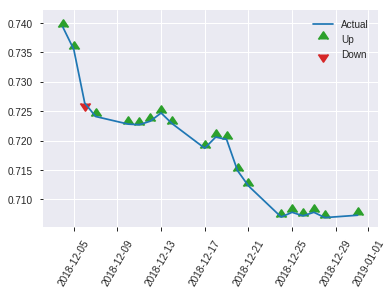


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2493533495426184
RMSE: 0.4993529308441259
LogLoss: 0.6922735876268369
Mean Per-Class Error: 0.4379310344827586
AUC: 0.560344827586207
pr_auc: 0.5101351518770117
Gini: 0.12068965517241392
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27865562564272006: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   130  0.9286   (130.0/140.0)
1      4    112  0.0345   (4.0/116.0)
Total  14   242  0.5234   (134.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.278656     0.625698  241
max f2                       0.213794     0.806676  254
max f0point5                 0.426717     0.532995  167
max accuracy                 0.70875      0.566406  4
max precision                0.752724     1         0
max recall                   0.213794     1         254
max specificity              0.752724     1         0
max absolute_mcc             0.70875      0.155054  4
max min_per_class_accuracy   0.483263     0.557143  126
max mean_per_class_accuracy  0.426717     0.562069  167

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 47.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.710988           2.2069    2.2069             1                0.732514  1                           0.732514            0.0258621       0.0258621                  120.69    120.69
    2        0.0234375                   0.703368           1.47126   1.83908            0.666667         0.70711   0.833333                    0.719812            0.0172414       0.0431034                  47.1264   83.908
    3        0.03125                     0.682792           0         1.37931            0                0.692438  0.625                       0.712969            0               0.0431034                  -100      37.931
    4        0.0429688                   0.67662            1.47126   1.40439            0.666667         0.67965   0.636364                    0.703882            0.0172414       0.0603448                  47.1264   40.4389
    5        0.0507812                   0.667789           1.10345   1.35809            0.5              0.673399  0.615385                    0.699192            0.00862069      0.0689655                  10.3448   35.809
    6        0.101562                    0.625328           0.848806  1.10345            0.384615         0.644583  0.5                         0.671887            0.0431034       0.112069                   -15.1194  10.3448
    7        0.152344                    0.593742           1.01857   1.07515            0.461538         0.61041   0.487179                    0.651395            0.0517241       0.163793                   1.85676   7.51547
    8        0.203125                    0.576412           1.52785   1.18833            0.692308         0.583974  0.538462                    0.63454             0.0775862       0.241379                   52.7851   18.8329
    9        0.300781                    0.537784           0.971034  1.11778            0.44             0.558373  0.506494                    0.60981             0.0948276       0.336207                   -2.89655  11.7779
    10       0.402344                    0.509498           1.10345   1.11416            0.5              0.521792  0.504854                    0.587592            0.112069        0.448276                   10.3448   11.4161
    11       0.5                         0.480458           1.14759   1.12069            0.52             0.497127  0.507812                    0.569923            0.112069        0.560345                   14.7586   12.069
    12       0.601562                    0.449453           0.848806  1.07479            0.384615         0.464904  0.487013                    0.552193            0.0862069       0.646552                   -15.1194  7.47873
    13       0.699219                    0.397108           0.882759  1.04797            0.4              0.426842  0.47486                     0.534685            0.0862069       0.732759                   -11.7241  4.79676
    14       0.800781                    0.349862           1.18833   1.06577            0.538462         0.373802  0.482927                    0.514281            0.12069         0.853448                   18.8329   6.57696
    15       0.898438                    0.306703           0.617931  1.01709            0.28             0.325102  0.46087                     0.493718            0.0603448       0.913793                   -38.2069  1.70915
    16       1                           0.188268           0.848806  1                  0.384615         0.268295  0.453125                    0.470823            0.

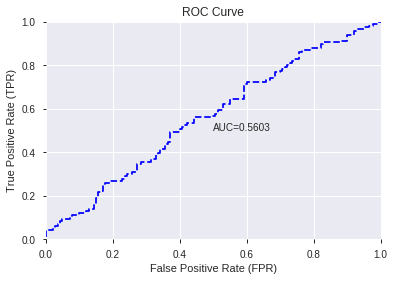

This function is available for GLM models only


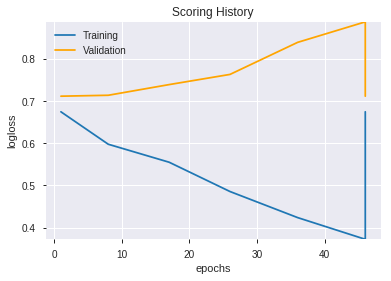

--2019-08-22 15:55:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


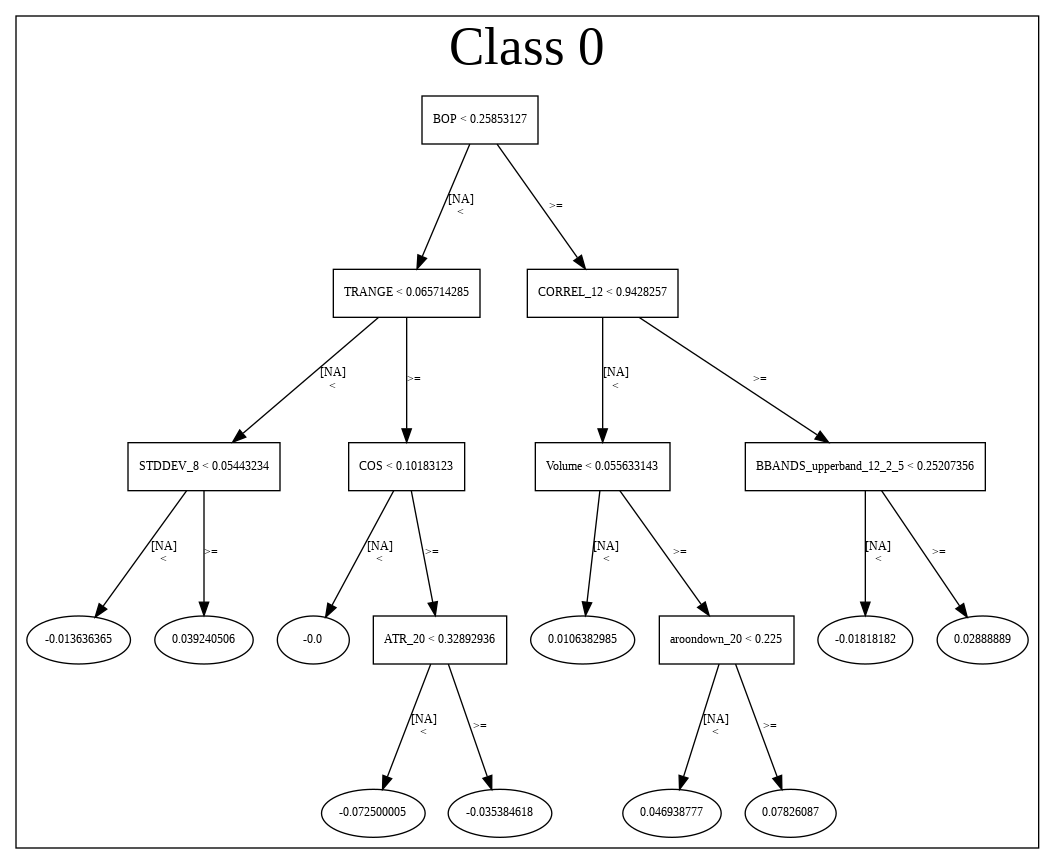

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_154845_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_154845_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'CDLDOJI',
 'STOCHF_fastk',
 'BETA_30',
 'CDLMORNINGSTAR',
 'CDLRISEFALL3METHODS',
 'CORREL_8',
 'TRANGE',
 'CDLHIGHWAVE',
 'days_in_month',
 'aroonup_30',
 'SAREXT',
 'CDLRICKSHAWMAN',
 'CORREL_30',
 'STOCH_slowk',
 'CDLGRAVESTONEDOJI',
 'aroonup_14',
 'CDLDRAGONFLYDOJI',
 'dayofyear',
 'aroonup_20',
 'HT_TRENDMODE',
 'dayofweek',
 'month',
 'STOCHRSI_fastk',
 'weekday_name',
 'DX_8',
 'SUB',
 'weekofyear',
 'CDLSTICKSANDWICH',
 'ULTOSC',
 'day',
 'CDLHIKKAKEMOD',
 'aroonup_8',
 'aroondown_20',
 'CDLSPINNINGTOP',
 'CDLTAKURI',
 'CDLONNECK',
 'quarter',
 'STOCHRSI_fastd',
 'aroonup_12',
 'CDLBELTHOLD',
 'HT_DCPERIOD',
 'aroondown_14',
 'weekday',
 'CORREL_24',
 'STOCHF_fastd',
 'AROONOSC_14',
 'HT_PHASOR_quadrature',
 'CDLSHORTLINE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_155605_model_1  0.562315  0.697647              0.462192  0.502084  0.252089

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.267590           1.000000    0.092526
1         CDLRICKSHAWMAN             0.128477           0.480127    0.044424
2                    SUB             0.118752           0.443783    0.041062
3           STOCHF_fastk             0.111082           0.415120    0.038410
4              aroonup_8             0.110081           0.411379    0.038063
5             aroonup_12             0.105106           0.392788    0.036343
6               CORREL_8             0.103888           0.388236    0.035922
7           CDLSHORTLINE             0.101606           0.379707    0.035133
8      CDLGRAVESTONEDOJI             0.099710           0.372621    0.034477
9                    DIV             0.091571           0.342206    0.031663
10            aroonup_14             0.088375           0.330263    0.030558
11                SAREXT             0.084872           0.317171    0.029347
12                  DX_8             0.078341           0.292764    0.027088
13          aroondown_20             0.077885           0.291061    0.026931
14             CDLONNECK             0.076700           0.286632    0.026521
15      CDLSTICKSANDWICH             0.069621           0.260178    0.024073
16               CDLDOJI             0.068545           0.256157    0.023701
17             dayofweek             0.066615           0.248945    0.023034
18               weekday             0.066500           0.248515    0.022994
19           AROONOSC_14             0.061691           0.230541    0.021331
20                TRANGE             0.058560           0.218842    0.020249
21             CORREL_24             0.057005           0.213030    0.019711
22            aroonup_20             0.055139           0.206057    0.019066
23         days_in_month             0.052272           0.195344    0.018074
24      CDLDRAGONFLYDOJI             0.047199           0.176386    0.016320
25             CORREL_30             0.045661           0.170639    0.015789
26           STOCH_slowk             0.045653           0.170607    0.015786
27          STOCHF_fastd             0.045554           0.170238    0.015751
28             CDLTAKURI             0.042866           0.160193    0.014822
29   CDLRISEFALL3METHODS             0.038829           0.145106    0.013426
30          HT_TRENDMODE             0.037672           0.140781    0.013026
31                ULTOSC             0.036993           0.138245    0.012791
32           CDLHIGHWAVE             0.036818           0.137592    0.012731
33           CDLBELTHOLD             0.028909           0.108033    0.009996
34  HT_PHASOR_quadrature             0.026690           0.099743    0.009229
35        CDLMORNINGSTAR             0.026084           0.097476    0.009019
36          weekday_name             0.025890           0.096753    0.008952
37         CDLHIKKAKEMOD             0.024744           0.092468    0.008556
38        STOCHRSI_fastk             0.023979           0.089611    0.008291
39          aroondown_14             0.023838           0.089083    0.008243
40           HT_DCPERIOD             0.022766           0.085077    0.007872
41               BETA_30             0.021719           0.081166    0.007510
42               quarter             0.020453           0.076436    0.007072
43                   day             0.017064           0.063768    0.005900
44        STOCHRSI_fastd             0.012199           0.045588    0.004218
45             dayofyear             0.010245           0.038287    0.003543
46                 month             0.007923           0.029607    0.002739
47        CDLSPINNINGTOP             0.007817           0.029214    0.002703
48            aroonup_30             0.007446           0.027827    0.002575
49            weekofyear             0.007050           0.026345    0.002438

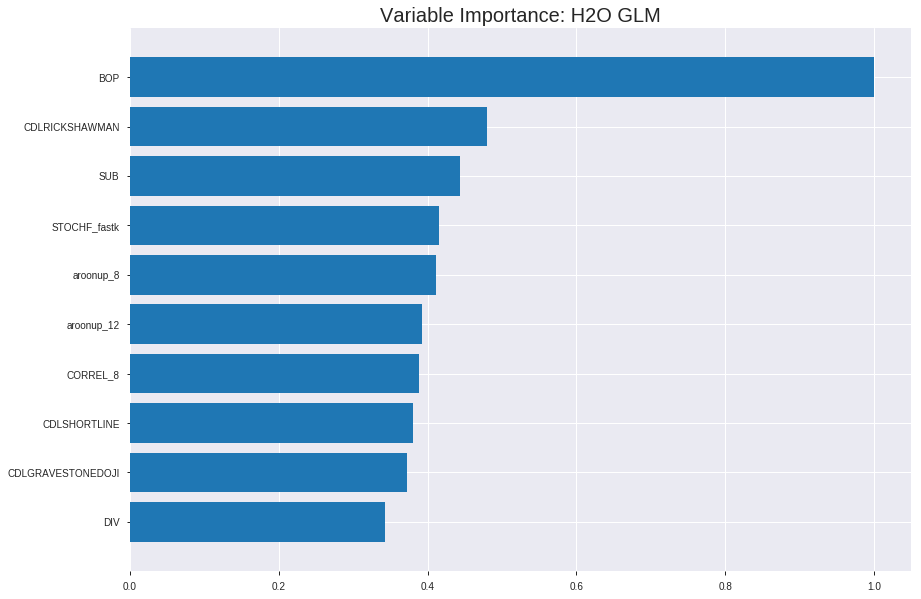

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_155605_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22471510770709138
RMSE: 0.4740412510605922
LogLoss: 0.6394517529633029
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2477.1462973227917
Residual deviance: 2285.4005650908443
AIC: 2387.4005650908443
AUC: 0.6822077743119497
pr_auc: 0.6645276992549531
Gini: 0.36441554862389935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37955471757316195: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      246  656   0.7273   (656.0/902.0)
1      80   805   0.0904   (80.0/885.0)
Total  326  1461  0.4119   (736.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379555     0.686275  292
max f2                       0.269156     0.839061  352
max f0point5                 0.517939     0.632668  179
max accuracy                 0.517939     0.635702  179
max precision                0.928803     1         0
max recall                   0.172771     1         387
max specificity              0.928803     1         0
max absolute_mcc             0.517939     0.271584  179
max min_per_class_accuracy   0.504139     0.633898  191
max mean_per_class_accuracy  0.504139     0.635685  191

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.797959           1.90703   1.90703            0.944444         0.854757  0.944444                    0.854757            0.019209        0.019209                   90.7031   90.7031
    2        0.0201455                   0.740533           1.45832   1.68267            0.722222         0.769494  0.833333                    0.812125            0.0146893       0.0338983                  45.8318   68.2674
    3        0.0302182                   0.71726            1.5705    1.64528            0.777778         0.727726  0.814815                    0.783992            0.0158192       0.0497175                  57.0496   64.5281
    4        0.040291                    0.705628           1.5705    1.62659            0.777778         0.711499  0.805556                    0.765869            0.0158192       0.0655367                  57.0496   62.6585
    5        0.0503637                   0.690081           1.5705    1.61537            0.777778         0.697297  0.8                         0.752154            0.0158192       0.0813559                  57.0496   61.5367
    6        0.100168                    0.654581           1.36126   1.48903            0.674157         0.669236  0.73743                     0.710927            0.0677966       0.149153                   36.1265   48.9026
    7        0.149972                    0.625318           1.45202   1.47673            0.719101         0.638734  0.731343                    0.686952            0.0723164       0.221469                   45.2015   47.6735
    8        0.200336                    0.605099           1.39101   1.45518            0.688889         0.615363  0.72067                     0.668955            0.0700565       0.291525                   39.1011   45.5184
    9        0.299944                    0.568804           1.2932    1.40139            0.640449         0.586158  0.69403                     0.641459            0.128814        0.420339                   29.3201   40.1391
    10       0.400112                    0.533252           1.04909   1.31319            0.519553         0.551721  0.65035                     0.618993            0.105085        0.525424                   4.90863   31.3192
    11       0.50028                     0.50324            1.10549   1.2716             0.547486         0.518522  0.629754                    0.598876            0.110734        0.636158                   10.5489   27.1605
    12       0.599888                    0.468289           0.873478  1.2055             0.432584         0.485757  0.597015                    0.580093            0.0870056       0.723164                   -12.6522  20.5498
    13       0.700056                    0.431348           0.846037  1.15406            0.418994         0.449829  0.571543                    0.561454            0.0847458       0.80791                    -15.3963  15.4064
    14       0.799664                    0.38675            0.839446  1.11487            0.41573          0.410342  0.552134                    0.542631            0.0836158       0.891525                   -16.0554  11.4875
    15       0.899832                    0.319065           0.721952  1.07114            0.357542         0.35737   0.530473                    0.522008            0.0723164       0.963842                   -27.8048  7.11351
    16       1                           0.0597545          0.360976  1                  0.178771         0.254807  0.495243                    0.495243         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23486196589099875
RMSE: 0.4846255935162718
LogLoss: 0.663744044388656
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 707.665141278386
Residual deviance: 677.0189252764291
AIC: 779.0189252764291
AUC: 0.6391560777532461
pr_auc: 0.6212573858693847
Gini: 0.27831215550649224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34192559842199327: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      31   208  0.8703   (208.0/239.0)
1      5    266  0.0185   (5.0/271.0)
Total  36   474  0.4176   (213.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341926     0.714094  365
max f2                       0.32627      0.858328  374
max f0point5                 0.49818      0.64311   215
max accuracy                 0.454209     0.62549   271
max precision                0.718523     0.777778  8
max recall                   0.280647     1         386
max specificity              0.918119     0.995816  0
max absolute_mcc             0.454209     0.248931  271
max min_per_class_accuracy   0.511153     0.60251   195
max mean_per_class_accuracy  0.49818      0.61822   215

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.745315           1.25461   1.25461            0.666667         0.809148  0.666667                    0.809148            0.0147601       0.0147601                  25.4613   25.4613
    2        0.0215686                   0.712117           1.50554   1.36867            0.8              0.723898  0.727273                    0.770398            0.0147601       0.0295203                  50.5535   36.8668
    3        0.0313725                   0.702222           0.752768  1.1762             0.4              0.704719  0.625                       0.749873            0.00738007      0.0369004                  -24.7232  17.6199
    4        0.0411765                   0.688278           0.752768  1.07538            0.4              0.696638  0.571429                    0.737198            0.00738007      0.0442804                  -24.7232  7.53822
    5        0.0509804                   0.681111           1.12915   1.08572            0.6              0.682811  0.576923                    0.726739            0.0110701       0.0553506                  12.9151   8.57224
    6        0.1                         0.644176           1.35498   1.21771            0.72             0.662781  0.647059                    0.695387            0.0664207       0.121771                   35.4982   21.7712
    7        0.15098                     0.618489           1.08572   1.17314            0.576923         0.631761  0.623377                    0.673903            0.0553506       0.177122                   8.57224   17.3144
    8        0.2                         0.602305           1.2797    1.19926            0.68             0.610917  0.637255                    0.658465            0.0627306       0.239852                   27.9705   19.9262
    9        0.3                         0.575598           1.21771   1.20541            0.647059         0.588745  0.640523                    0.635225            0.121771        0.361624                   21.7712   20.5412
    10       0.4                         0.542599           1.29151   1.22694            0.686275         0.556098  0.651961                    0.615443            0.129151        0.490775                   29.1513   22.6937
    11       0.5                         0.512737           1.03321   1.18819            0.54902          0.527901  0.631373                    0.597935            0.103321        0.594096                   3.32103   18.8192
    12       0.6                         0.487615           1.07011   1.16851            0.568627         0.500547  0.620915                    0.581703            0.107011        0.701107                   7.01107   16.8512
    13       0.7                         0.462654           0.922509  1.13337            0.490196         0.474468  0.602241                    0.566384            0.0922509       0.793358                   -7.74908  13.3368
    14       0.8                         0.415667           0.885609  1.1024             0.470588         0.438803  0.585784                    0.550436            0.0885609       0.881919                   -11.4391  10.2399
    15       0.9                         0.363576           0.664207  1.05371            0.352941         0.390555  0.559913                    0.532672            0.0664207       0.948339                   -33.5793  5.37105
    16       1                           0.184272           0.516605  1                  0.27451          0.305651  0.531373                    0.50997          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 15:56:05  0.000 sec   2            8         51            1.37601           1.37981
    2019-08-22 15:56:05  0.014 sec   4            5         51            1.37072           1.37585
    2019-08-22 15:56:05  0.028 sec   6            3.1       51            1.36335           1.37042
    2019-08-22 15:56:05  0.041 sec   8            1.9       51            1.35372           1.36352
    2019-08-22 15:56:05  0.055 sec   10           1.2       51            1.34208           1.35553
    2019-08-22 15:56:05  0.068 sec   12           0.74      51            1.32922           1.34729
    2019-08-22 15:56:05  0.082 sec   14           0.46      51            1.31628           1.33982
    2019-08-22 15:56:05  0.095 sec   16           0.28      51            1.30425           1.33388
    2019-08-22 15:56:05  0.109 sec   18           0.18      51            1.29386           1.32986
    2019-08-22 15:56:05  0.123 sec   20           0.11      51            1.2854            1.32779
    2019-08-22 15:56:05  0.137 sec   22           0.068     51            1.2789            1.32749
    2019-08-22 15:56:05  0.153 sec   24           0.042     51            1.27415           1.32868
    2019-08-22 15:56:05  0.168 sec   26           0.026     51            1.27083           1.33101
    2019-08-22 15:56:05  0.184 sec   28           0.016     51            1.26861           1.33412
    2019-08-22 15:56:05  0.198 sec   30           0.01      51            1.26719           1.33766
    2019-08-22 15:56:05  0.212 sec   32           0.0063    51            1.26632           1.34135

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57421875)

('F1', 0.6386554621848739)

('auc', 0.5623152709359606)

('logloss', 0.6976470115032061)

('mean_per_class_error', 0.44507389162561584)

('rmse', 0.5020844960987964)

('mse', 0.25208884122278225)

glm prediction progress: |████████████████████████████████████████████████| 100%


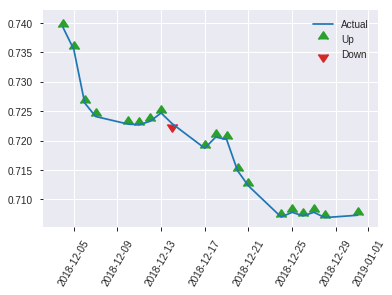


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25208884122278225
RMSE: 0.5020844960987964
LogLoss: 0.6976470115032061
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.4578805022527
Residual deviance: 357.1952698896415
AIC: 459.1952698896415
AUC: 0.5623152709359606
pr_auc: 0.5110049851601951
Gini: 0.12463054187192113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31991730761210735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   127  0.9071   (127.0/140.0)
1      2    114  0.0172   (2.0/116.0)
Total  15   241  0.5039   (129.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319917     0.638655  240
max f2                       0.245233     0.808926  252
max f0point5                 0.319917     0.527778  240
max accuracy                 0.624786     0.574219  52
max precision                0.717052     0.857143  6
max recall                   0.245233     1         252
max specificity              0.793529     0.992857  0
max absolute_mcc             0.319917     0.16027   240
max min_per_class_accuracy   0.520826     0.542857  126
max mean_per_class_accuracy  0.553196     0.554926  105

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 52.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.738251           1.47126   1.47126            0.666667         0.764871  0.666667                    0.764871            0.0172414       0.0172414                  47.1264   47.1264
    2        0.0234375                   0.719928           2.2069    1.83908            1                0.72917   0.833333                    0.747021            0.0258621       0.0431034                  120.69    83.908
    3        0.03125                     0.716043           1.10345   1.65517            0.5              0.716708  0.75                        0.739442            0.00862069      0.0517241                  10.3448   65.5172
    4        0.0429688                   0.706089           0.735632  1.40439            0.333333         0.709883  0.636364                    0.731381            0.00862069      0.0603448                  -26.4368  40.4389
    5        0.0507812                   0.703137           0         1.18833            0                0.705298  0.538462                    0.727368            0               0.0603448                  -100      18.8329
    6        0.101562                    0.682052           1.35809   1.27321            0.615385         0.693073  0.576923                    0.710221            0.0689655       0.12931                    35.809    27.321
    7        0.152344                    0.657855           1.01857   1.18833            0.461538         0.670816  0.538462                    0.697086            0.0517241       0.181034                   1.85676   18.8329
    8        0.203125                    0.625581           1.35809   1.23077            0.615385         0.639658  0.557692                    0.682729            0.0689655       0.25                       35.809    23.0769
    9        0.300781                    0.58917            0.971034  1.14644            0.44             0.607496  0.519481                    0.658303            0.0948276       0.344828                   -2.89655  14.644
    10       0.402344                    0.556479           1.01857   1.11416            0.461538         0.573656  0.504854                    0.636935            0.103448        0.448276                   1.85676   11.4161
    11       0.5                         0.518099           0.971034  1.08621            0.44             0.537392  0.492188                    0.617493            0.0948276       0.543103                   -2.89655  8.62069
    12       0.601562                    0.492664           0.933687  1.06046            0.423077         0.506534  0.480519                    0.59876             0.0948276       0.637931                   -6.6313   6.04568
    13       0.699219                    0.467494           1.05931   1.0603             0.48             0.479284  0.480447                    0.582073            0.103448        0.741379                   5.93103   6.02967
    14       0.800781                    0.42416            0.848806  1.03347            0.384615         0.445721  0.468293                    0.56478             0.0862069       0.827586                   -15.1194  3.34735
    15       0.898438                    0.359233           1.05931   1.03628            0.48             0.391213  0.469565                    0.545914            0.103448        0.931034                   5.93103   3.62819
    16       1                           0.153993           0.679045  1                  0.307692         0.297173  0.453125                    0.520651            

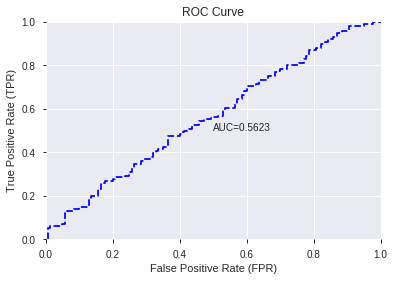

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


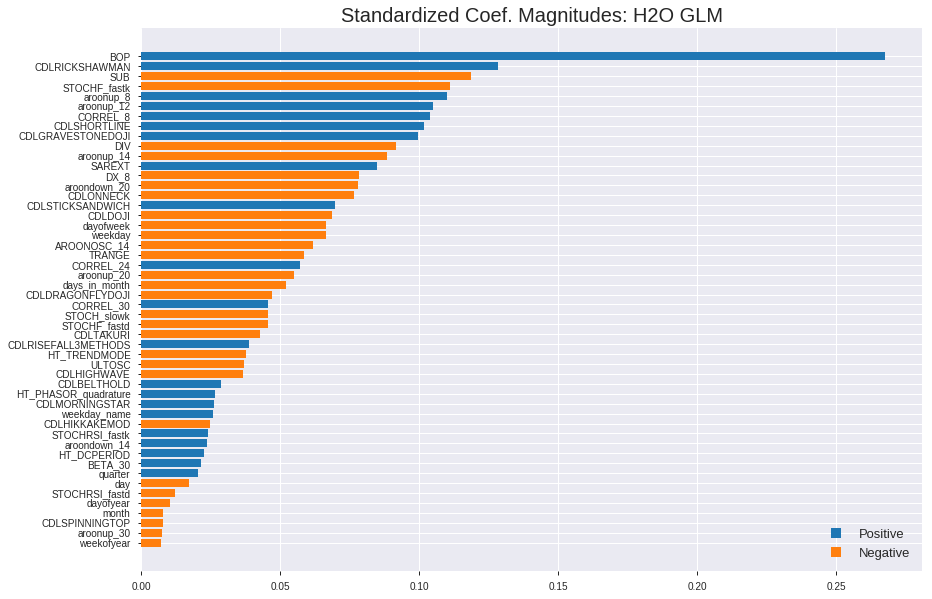

'log_likelihood'
--2019-08-22 15:56:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.201.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.201.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


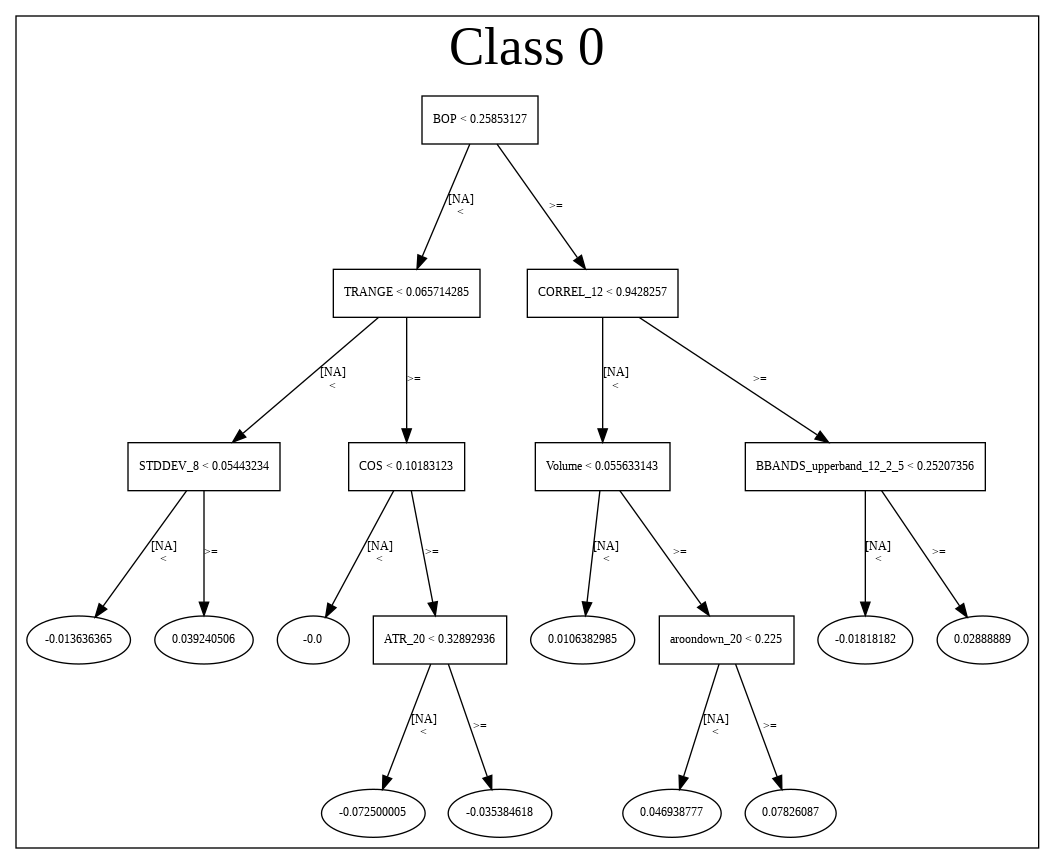

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_155605_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_155605_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLRICKSHAWMAN',
 'SUB',
 'STOCHF_fastk',
 'aroonup_8',
 'aroonup_12',
 'CORREL_8',
 'CDLSHORTLINE',
 'CDLGRAVESTONEDOJI',
 'DIV',
 'aroonup_14',
 'SAREXT',
 'DX_8',
 'aroondown_20',
 'CDLONNECK',
 'CDLSTICKSANDWICH',
 'CDLDOJI',
 'dayofweek',
 'weekday',
 'AROONOSC_14',
 'TRANGE',
 'CORREL_24',
 'aroonup_20',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'CORREL_30',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'HT_TRENDMODE',
 'ULTOSC',
 'CDLHIGHWAVE',
 'CDLBELTHOLD',
 'HT_PHASOR_quadrature',
 'CDLMORNINGSTAR',
 'weekday_name',
 'CDLHIKKAKEMOD',
 'STOCHRSI_fastk',
 'aroondown_14',
 'HT_DCPERIOD',
 'BETA_30',
 'quarter',
 'day',
 'STOCHRSI_fastd',
 'dayofyear',
 'month',
 'CDLSPINNINGTOP',
 'aroonup_30',
 'weekofyear']

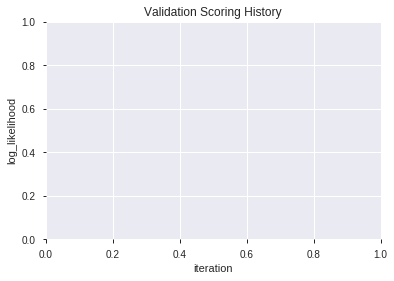

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_155620_model_6  0.574015  0.703637              0.457882  0.504298  0.254316
1  XGBoost_grid_1_AutoML_20190822_155620_model_4  0.570259  0.695381              0.455049  0.501063  0.251064
2  XGBoost_grid_1_AutoML_20190822_155620_model_7  0.565394  0.713661              0.432882  0.509278  0.259364
3               XGBoost_3_AutoML_20190822_155620  0.562438  0.708361              0.465025  0.506636  0.256680
4  XGBoost_grid_1_AutoML_20190822_155620_model_5  0.562069  0.741748              0.467241  0.518720  0.269070
5               XGBoost_1_AutoML_20190822_155620  0.556897  0.713879              0.453695  0.509356  0.259444
6  XGBoost_grid_1_AutoML_20190822_155620_model_1  0.550739  0.711409              0.444335  0.507993  0.258057
7  XGBoost_grid_1_AutoML_20190822_155620_model_2  0.546244  0.704356              0.445074  0.505268  0.255296
8  XGBoost_grid_1_AutoML_20190822_155620_model_3  0.546059  0.712072              0.468596  0.508554  0.258627
9               XGBoost_2_AutoML_20190822_155620  0.537869  0.718553              0.459360  0.511213  0.261339

variable  relative_importance  scaled_importance  percentage
0                    BOP           769.924805           1.000000    0.101612
1                 ULTOSC           502.931213           0.653221    0.066375
2           STOCHF_fastk           473.709625           0.615267    0.062519
3                    SUB           463.373901           0.601843    0.061155
4                    DIV           408.526581           0.530606    0.053916
5                BETA_30           343.207581           0.445768    0.045295
6   HT_PHASOR_quadrature           268.368073           0.348564    0.035418
7            HT_DCPERIOD           263.553070           0.342310    0.034783
8                 TRANGE           263.193146           0.341843    0.034735
9                 SAREXT           261.794495           0.340026    0.034551
10             dayofyear           253.014923           0.328623    0.033392
11        STOCHRSI_fastd           249.274002           0.323764    0.032898
12                  DX_8           244.437576           0.317482    0.032260
13              CORREL_8           238.040649           0.309174    0.031416
14             CORREL_30           229.957184           0.298675    0.030349
15           STOCH_slowk           205.300766           0.266650    0.027095
16                   day           202.152328           0.262561    0.026679
17             CORREL_24           192.787140           0.250397    0.025443
18             dayofweek           162.140488           0.210593    0.021399
19           AROONOSC_14           124.025154           0.161087    0.016368
20        STOCHRSI_fastk           112.534271           0.146163    0.014852
21          STOCHF_fastd           111.119110           0.144325    0.014665
22        CDLRICKSHAWMAN           109.731667           0.142523    0.014482
23          aroondown_14           102.222992           0.132770    0.013491
24     CDLGRAVESTONEDOJI            99.468491           0.129192    0.013128
25            aroonup_12            91.982246           0.119469    0.012140
26          aroondown_20            90.618019           0.117697    0.011959
27            aroonup_20            87.401443           0.113519    0.011535
28            aroonup_30            85.473053           0.111015    0.011280
29          CDLSHORTLINE            80.413864           0.104444    0.010613
30             aroonup_8            78.145462           0.101498    0.010313
31            aroonup_14            72.329308           0.093943    0.009546
32          weekday_name            66.065506           0.085808    0.008719
33         days_in_month            43.327160           0.056275    0.005718
34      CDLDRAGONFLYDOJI            42.625813           0.055364    0.005626
35               weekday            32.041973           0.041617    0.004229
36            weekofyear            30.507374           0.039624    0.004026
37        CDLSPINNINGTOP            29.851681           0.038772    0.003940
38          HT_TRENDMODE            24.369534           0.031652    0.003216
39             CDLTAKURI            20.126692           0.026141    0.002656
40           CDLHIGHWAVE            17.207150           0.022349    0.002271
41                 month            13.682028           0.017771    0.001806
42               CDLDOJI             8.503270           0.011044    0.001122
43           CDLBELTHOLD             5.072277           0.006588    0.000669
44               quarter             2.546855           0.003308    0.000336

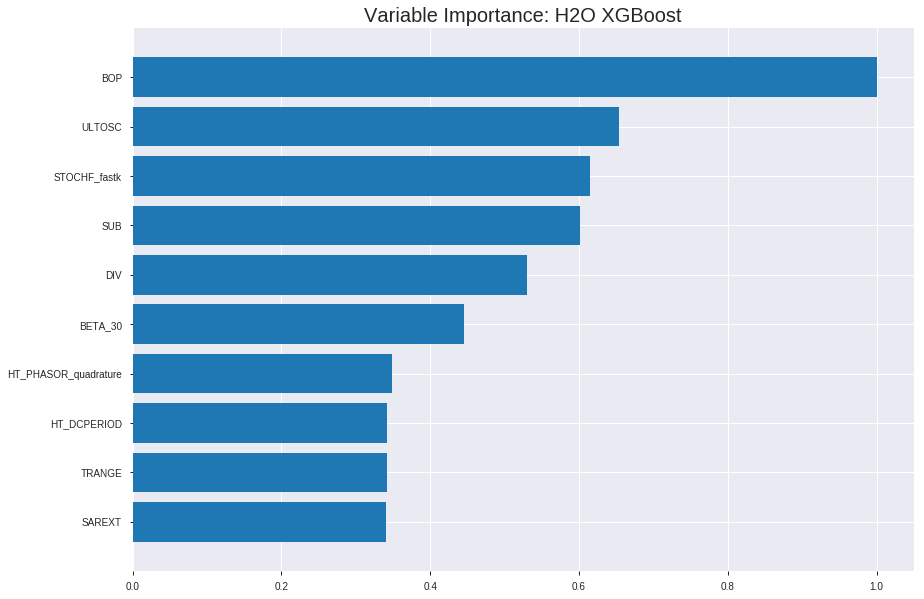

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_155620_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17012634344908723
RMSE: 0.41246374804228214
LogLoss: 0.5242125687334515
Mean Per-Class Error: 0.17266964811404661
AUC: 0.9023832788404925
pr_auc: 0.9026209014466196
Gini: 0.804766557680985
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48399747535586357: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      712  190  0.2106   (190.0/902.0)
1      133  752  0.1503   (133.0/885.0)
Total  845  942  0.1807   (323.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483997     0.823207  204
max f2                       0.392664     0.882414  272
max f0point5                 0.515424     0.838852  181
max accuracy                 0.508188     0.827644  186
max precision                0.848835     1         0
max recall                   0.279792     1         341
max specificity              0.848835     1         0
max absolute_mcc             0.508188     0.656343  186
max min_per_class_accuracy   0.493143     0.821469  196
max mean_per_class_accuracy  0.508188     0.82733   186

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.802742           2.01921    2.01921            1                0.816945  1                           0.816945            0.020339        0.020339                   101.921   101.921
    2        0.0201455                   0.779687           2.01921    2.01921            1                0.795021  1                           0.805983            0.020339        0.040678                   101.921   101.921
    3        0.0302182                   0.769018           2.01921    2.01921            1                0.772504  1                           0.794824            0.020339        0.0610169                  101.921   101.921
    4        0.040291                    0.75839            1.90703    1.99116            0.944444         0.763374  0.986111                    0.786961            0.019209        0.080226                   90.7031   99.1164
    5        0.0503637                   0.744622           2.01921    1.99677            1                0.751595  0.988889                    0.779888            0.020339        0.100565                   101.921   99.6773
    6        0.100168                    0.698941           1.99652    1.99665            0.988764         0.719492  0.988827                    0.749859            0.099435        0.2                        99.6521   99.6648
    7        0.149972                    0.664046           1.90577    1.96647            0.94382          0.681749  0.973881                    0.72724             0.0949153       0.294915                   90.577    96.6469
    8        0.200336                    0.631409           1.8846     1.94589            0.933333         0.646461  0.963687                    0.706933            0.0949153       0.389831                   88.4595   94.5886
    9        0.299944                    0.583661           1.71292    1.86852            0.848315         0.606227  0.925373                    0.673489            0.170621        0.560452                   71.2925   86.8522
    10       0.400112                    0.534832           1.45518    1.76504            0.72067          0.558404  0.874126                    0.644678            0.145763        0.706215                   45.5184   76.5043
    11       0.50028                     0.491228           1.17317    1.64654            0.581006         0.513332  0.815436                    0.618379            0.117514        0.823729                   17.3172   64.6536
    12       0.599888                    0.453707           0.748695   1.49745            0.370787         0.474211  0.741604                    0.594441            0.0745763       0.898305                   -25.1305  49.7454
    13       0.700056                    0.4082             0.485061   1.3526             0.240223         0.428511  0.669864                    0.570699            0.0485876       0.946893                   -51.4939  35.2596
    14       0.799664                    0.365708           0.385692   1.23216            0.191011         0.386625  0.610217                    0.54777             0.0384181       0.985311                   -61.4308  23.2156
    15       0.899832                    0.293838           0.135366   1.11006            0.0670391        0.332592  0.549751                    0.523817            0.0135593       0.99887                    -86.4634  11.0063
    16       1                           0.125976           0.0112805  1                  0.00558659       0.230463  0.495243                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2337818330796164
RMSE: 0.4835099100117974
LogLoss: 0.6590117866609759
Mean Per-Class Error: 0.39626210069632073
AUC: 0.6410860133705939
pr_auc: 0.6600197532820107
Gini: 0.2821720267411878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3410152643918991: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   200  0.8368   (200.0/239.0)
1      11   260  0.0406   (11.0/271.0)
Total  50   460  0.4137   (211.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341015     0.711354  354
max f2                       0.282553     0.858138  385
max f0point5                 0.384599     0.626639  315
max accuracy                 0.384599     0.603922  315
max precision                0.810093     1         0
max recall                   0.282553     1         385
max specificity              0.810093     1         0
max absolute_mcc             0.548095     0.215104  136
max min_per_class_accuracy   0.498281     0.590406  198
max mean_per_class_accuracy  0.520955     0.603738  166

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 49.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.774756           1.56827   1.56827            0.833333         0.791457  0.833333                    0.791457            0.0184502       0.0184502                  56.8266   56.8266
    2        0.0215686                   0.75078            1.88192   1.71084            1                0.754409  0.909091                    0.774617            0.0184502       0.0369004                  88.1919   71.0835
    3        0.0313725                   0.742967           0.752768  1.41144            0.4              0.745339  0.75                        0.765468            0.00738007      0.0442804                  -24.7232  41.1439
    4        0.0411765                   0.723182           1.88192   1.52346            1                0.729238  0.809524                    0.756842            0.0184502       0.0627306                  88.1919   52.3458
    5        0.0509804                   0.711393           1.50554   1.52001            0.8              0.720587  0.807692                    0.74987             0.0147601       0.0774908                  50.5535   52.0011
    6        0.1                         0.636903           1.50554   1.51292            0.8              0.667937  0.803922                    0.709707            0.0738007       0.151292                   50.5535   51.2915
    7        0.15098                     0.61744            1.23049   1.41755            0.653846         0.626709  0.753247                    0.681682            0.0627306       0.214022                   23.0485   41.7549
    8        0.2                         0.594782           1.05387   1.32841            0.56             0.606371  0.705882                    0.663223            0.0516605       0.265683                   5.38745   32.8413
    9        0.3                         0.555336           1.14391   1.26691            0.607843         0.572393  0.673203                    0.632946            0.114391        0.380074                   14.3911   26.6913
    10       0.4                         0.524439           1.07011   1.21771            0.568627         0.540776  0.647059                    0.609904            0.107011        0.487085                   7.01107   21.7712
    11       0.5                         0.495152           1.03321   1.18081            0.54902          0.510901  0.627451                    0.590103            0.103321        0.590406                   3.32103   18.0812
    12       0.6                         0.461088           0.774908  1.11316            0.411765         0.474816  0.591503                    0.570889            0.0774908       0.667897                   -22.5092  11.3161
    13       0.7                         0.424652           1.07011   1.10701            0.568627         0.442622  0.588235                    0.552565            0.107011        0.774908                   7.01107   10.7011
    14       0.8                         0.387147           1.03321   1.09779            0.54902          0.405779  0.583333                    0.534217            0.103321        0.878229                   3.32103   9.7786
    15       0.9                         0.341089           0.774908  1.06191            0.411765         0.36371   0.56427                     0.515272            0.0774908       0.95572                    -22.5092  6.19106
    16       1                           0.207781           0.442804  1                  0.235294         0.294058  0.531373                    0.49315           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:56:32  8.020 sec   0                  0.5              0.693147            0.5             0                  1                0.504757                         0.5                0.693147              0.5               0                    1                  0.468627
    2019-08-22 15:56:32  8.147 sec   5                  0.483987         0.661493            0.774951        0.775053           2.01921          0.299944                         0.493995           0.681177              0.63904           0.642827             1.34423            0.403922
    2019-08-22 15:56:32  8.213 sec   10                 0.471997         0.638059            0.802815        0.808876           2.01921          0.328483                         0.489614           0.672435              0.657143          0.653314             0.940959           0.398039
    2019-08-22 15:56:32  8.282 sec   15                 0.46064          0.616024            0.82258         0.827561           2.01921          0.268047                         0.486235           0.665622              0.655854          0.658549             0.940959           0.392157
    2019-08-22 15:56:32  8.354 sec   20                 0.452053         0.599419            0.835043        0.84057            2.01921          0.265249                         0.485079           0.663182              0.648011          0.657801             1.25461            0.392157
    2019-08-22 15:56:32  8.432 sec   25                 0.442842         0.581882            0.8581          0.859801           2.01921          0.232792                         0.483359           0.6597                0.654765          0.65692              0.940959           0.37451
    2019-08-22 15:56:32  8.505 sec   30                 0.43595          0.568637            0.869519        0.872027           2.01921          0.230554                         0.482641           0.658081              0.654047          0.654193             1.25461            0.390196
    2019-08-22 15:56:33  8.575 sec   35                 0.429839         0.55698             0.878141        0.880644           2.01921          0.213206                         0.481975           0.656565              0.65465           0.660014             0.940959           0.407843
    2019-08-22 15:56:33  8.651 sec   40                 0.422949         0.54414             0.891134        0.893405           2.01921          0.195299                         0.483138           0.658705              0.645556          0.659793             1.25461            0.411765
    2019-08-22 15:56:33  8.727 sec   45                 0.417108         0.533067            0.898121        0.899218           2.01921          0.182988                         0.483279           0.658682              0.642252          0.659145             1.56827            0.419608
    2019-08-22 15:56:33  8.799 sec   50                 0.412464         0.524213            0.902383        0.902621           2.01921          0.18075                          0.48351            0.659012              0.641086          0.66002              1.56827            0.413725

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           769.9248046875         1.0                    0.101612337620751
ULTOSC        502.93121337890625     0.6532212111065027     0.06637533424398981
STOCHF_fastk  473.7096252441406      0.615267390217947      0.06251875778186437
SUB           463.3739013671875      0.6018430612263018     0.06115468033203329
DIV           408.5265808105469      0.530605818027075      0.05391609752490191
---           ---                    ---                    ---
CDLHIGHWAVE   17.207149505615234     0.022349129942110826   0.0022709473372078005
month         13.682027816772461     0.017770602704930093   0.0018057124817775876
CDLDOJI       8.503270149230957      0.011044286529620638   0.0011222357716281248
CDLBELTHOLD   5.072276592254639      0.0065880155586276945  0.0006694236611940378
quarter       2.5468549728393555     0.003307926900566715   0.0003361261850451495


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6424581005586593)

('auc', 0.5740147783251232)

('logloss', 0.7036367882007051)

('mean_per_class_error', 0.41847290640394097)

('rmse', 0.5042978694716213)

('mse', 0.25431634115361634)

xgboost prediction progress: |████████████████████████████████████████████| 100%


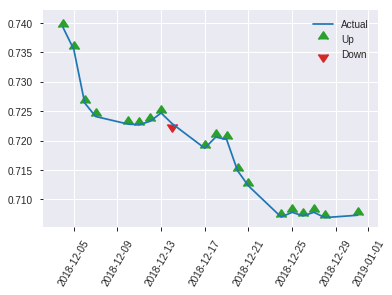


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25431634115361634
RMSE: 0.5042978694716213
LogLoss: 0.7036367882007051
Mean Per-Class Error: 0.41847290640394097
AUC: 0.5740147783251232
pr_auc: 0.494295063587111
Gini: 0.1480295566502463
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3555271029472351: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   127  0.9071   (127.0/140.0)
1      1    115  0.0086   (1.0/116.0)
Total  14   242  0.5      (128.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355527     0.642458  241
max f2                       0.355527     0.814448  241
max f0point5                 0.575287     0.541958  113
max accuracy                 0.581352     0.585938  107
max precision                0.727227     0.611111  17
max recall                   0.263617     1         253
max specificity              0.804957     0.992857  0
max absolute_mcc             0.355527     0.184426  241
max min_per_class_accuracy   0.555336     0.551724  125
max mean_per_class_accuracy  0.575287     0.581527  113

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 54.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.779759           0         0                  0                0.791645  0                           0.791645            0               0                          -100      -100
    2        0.0234375                   0.772864           0.735632  0.367816           0.333333         0.775566  0.166667                    0.783606            0.00862069      0.00862069                 -26.4368  -63.2184
    3        0.03125                     0.766038           2.2069    0.827586           1                0.769095  0.375                       0.779978            0.0172414       0.0258621                  120.69    -17.2414
    4        0.0429688                   0.739825           2.2069    1.20376            1                0.750706  0.545455                    0.771995            0.0258621       0.0517241                  120.69    20.3762
    5        0.0507812                   0.738038           1.10345   1.18833            0.5              0.73925   0.538462                    0.766957            0.00862069      0.0603448                  10.3448   18.8329
    6        0.101562                    0.697413           1.01857   1.10345            0.461538         0.721129  0.5                         0.744043            0.0517241       0.112069                   1.85676   10.3448
    7        0.152344                    0.664558           1.01857   1.07515            0.461538         0.681687  0.487179                    0.723258            0.0517241       0.163793                   1.85676   7.51547
    8        0.203125                    0.656171           1.35809   1.14589            0.615385         0.660399  0.519231                    0.707543            0.0689655       0.232759                   35.809    14.5889
    9        0.300781                    0.614882           1.05931   1.11778            0.48             0.633826  0.506494                    0.683609            0.103448        0.336207                   5.93103   11.7779
    10       0.402344                    0.584742           1.35809   1.17844            0.615385         0.600663  0.533981                    0.662671            0.137931        0.474138                   35.809    17.844
    11       0.5                         0.550186           0.882759  1.12069            0.4              0.569311  0.507812                    0.644437            0.0862069       0.560345                   -11.7241  12.069
    12       0.601562                    0.51844            0.933687  1.08912            0.423077         0.533506  0.493506                    0.625708            0.0948276       0.655172                   -6.6313   8.91178
    13       0.699219                    0.476172           0.882759  1.0603             0.4              0.499843  0.480447                    0.608129            0.0862069       0.741379                   -11.7241  6.02967
    14       0.800781                    0.439011           1.10345   1.06577            0.5              0.459708  0.482927                    0.589305            0.112069        0.853448                   10.3448   6.57696
    15       0.898438                    0.383079           0.971034  1.05547            0.44             0.410421  0.478261                    0.569861            0.0948276       0.948276                   -2.89655  5.54723
    16       1                           0.187297           0.509284  1                  0.230769         0.330373  0.453125                    0.545538            

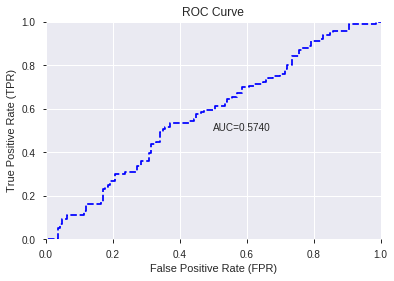

This function is available for GLM models only


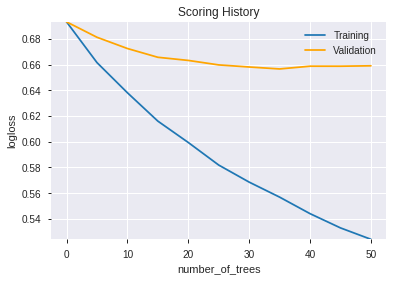

--2019-08-22 15:56:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

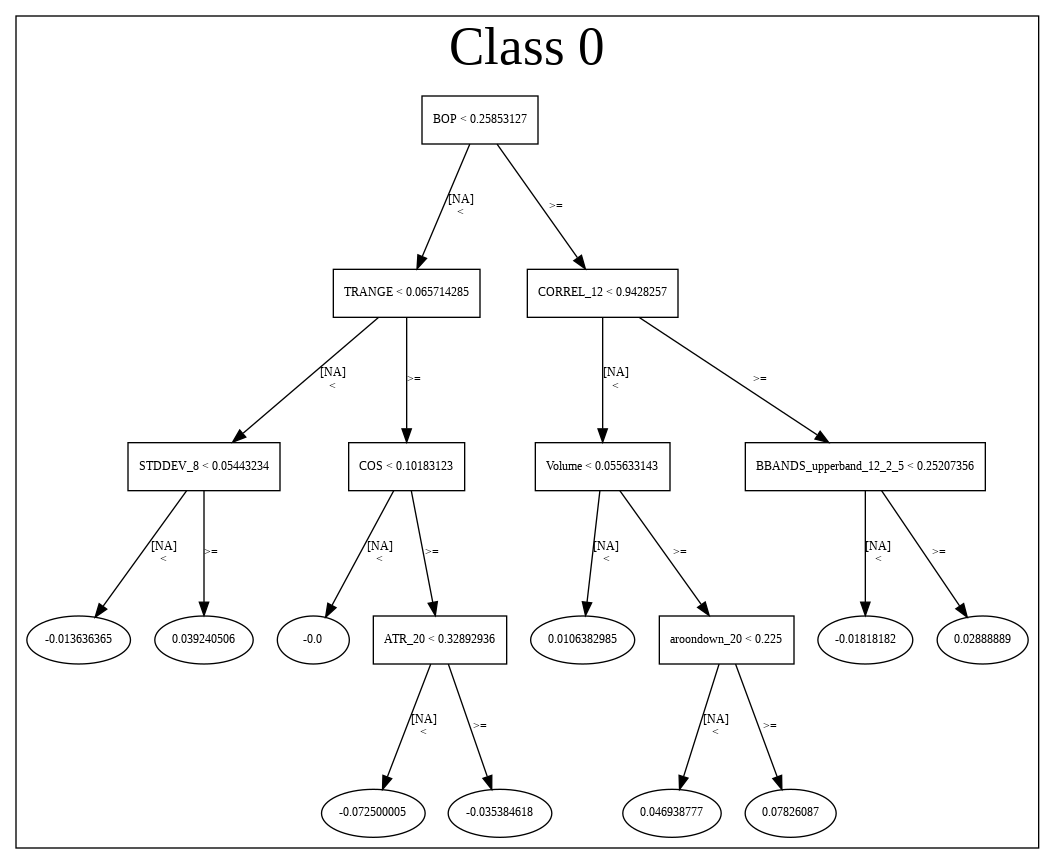

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_155620_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_155620_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'ULTOSC',
 'STOCHF_fastk',
 'SUB',
 'DIV',
 'BETA_30',
 'HT_PHASOR_quadrature',
 'HT_DCPERIOD',
 'TRANGE',
 'SAREXT',
 'dayofyear',
 'STOCHRSI_fastd',
 'DX_8',
 'CORREL_8',
 'CORREL_30',
 'STOCH_slowk',
 'day',
 'CORREL_24',
 'dayofweek',
 'AROONOSC_14',
 'STOCHRSI_fastk',
 'STOCHF_fastd',
 'CDLRICKSHAWMAN',
 'aroondown_14',
 'CDLGRAVESTONEDOJI',
 'aroonup_12',
 'aroondown_20',
 'aroonup_20',
 'aroonup_30',
 'CDLSHORTLINE',
 'aroonup_8',
 'aroonup_14',
 'weekday_name',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'weekday',
 'weekofyear',
 'CDLSPINNINGTOP',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'CDLHIGHWAVE',
 'month',
 'CDLDOJI',
 'CDLBELTHOLD',
 'quarter']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_155650_model_1  0.570443  0.686023              0.449384  0.496783  0.246793

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.199543           1.000000  3.327520e-02
1                          SUB             0.121827           0.610527  2.031542e-02
2                          DIV             0.114034           0.571477  1.901600e-02
3               CDLRICKSHAWMAN             0.099308           0.497677  1.656031e-02
4                       TRANGE             0.082763           0.414764  1.380135e-02
...                        ...                  ...                ...           ...
1021                    ADX_14             0.000009           0.000046  1.541833e-06
1022   BBANDS_upperband_20_6_2             0.000007           0.000035  1.150157e-06
1023  BBANDS_middleband_20_1_3             0.000004           0.000020  6.525946e-07
1024                    WMA_20             0.000003           0.000016  5.212624e-07
1025   BBANDS_middleband_8_2_2             0.000003           0.000015  5.101981e-07

[1026 rows x 4 columns]

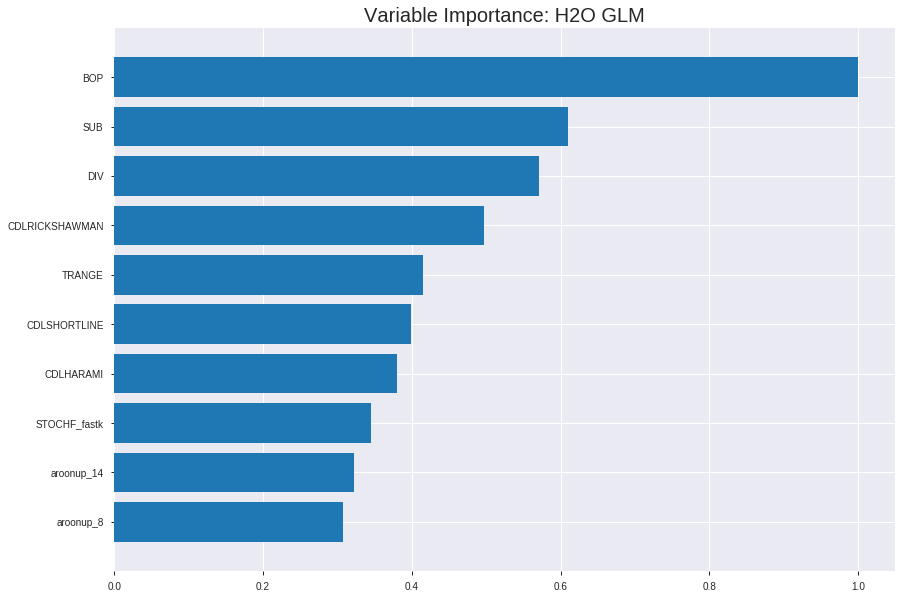

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_155650_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21970203233536725
RMSE: 0.4687238337607415
LogLoss: 0.6287720477226195
Null degrees of freedom: 1786
Residual degrees of freedom: 760
Null deviance: 2477.1462973227917
Residual deviance: 2247.2312985606422
AIC: 4301.231298560642
AUC: 0.703933506207173
pr_auc: 0.691377507239393
Gini: 0.407867012414346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3957676532702695: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      297  605   0.6707   (605.0/902.0)
1      90   795   0.1017   (90.0/885.0)
Total  387  1400  0.3889   (695.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395768     0.695842  270
max f2                       0.303751     0.840077  333
max f0point5                 0.524444     0.644734  167
max accuracy                 0.524444     0.646894  167
max precision                0.889134     1         0
max recall                   0.154906     1         390
max specificity              0.889134     1         0
max absolute_mcc             0.524444     0.294085  167
max min_per_class_accuracy   0.508396     0.639548  179
max mean_per_class_accuracy  0.523005     0.646527  168

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.783493           1.90703   1.90703            0.944444         0.83005   0.944444                    0.83005             0.019209        0.019209                   90.7031    90.7031
    2        0.0201455                   0.7385             1.68267   1.79485            0.833333         0.756573  0.888889                    0.793311            0.0169492       0.0361582                  68.2674    79.4852
    3        0.0302182                   0.717807           1.79485   1.79485            0.888889         0.728026  0.888889                    0.77155             0.0180791       0.0542373                  79.4852    79.4852
    4        0.040291                    0.706436           1.90703   1.8229             0.944444         0.712848  0.902778                    0.756874            0.019209        0.0734463                  90.7031    82.2897
    5        0.0503637                   0.68688            1.34614   1.72755            0.666667         0.695041  0.855556                    0.744507            0.0135593       0.0870056                  34.6139    72.7546
    6        0.100168                    0.646667           1.56545   1.64695            0.775281         0.665718  0.815642                    0.705333            0.0779661       0.164972                   56.5454    64.6953
    7        0.149972                    0.618679           1.2932    1.52948            0.640449         0.633292  0.757463                    0.681409            0.0644068       0.229379                   29.3201    52.9476
    8        0.200336                    0.600555           1.39101   1.49467            0.688889         0.609926  0.740223                    0.663438            0.0700565       0.299435                   39.1011    49.4666
    9        0.299944                    0.568161           1.25917   1.41646            0.623596         0.584253  0.701493                    0.637142            0.125424        0.424859                   25.917     41.646
    10       0.400112                    0.540897           1.12805   1.34426            0.558659         0.554012  0.665734                    0.61633             0.112994        0.537853                   12.805     34.4257
    11       0.50028                     0.507258           1.03781   1.2829             0.513966         0.525045  0.635347                    0.598053            0.103955        0.641808                   3.78058    28.2898
    12       0.599888                    0.470273           0.998261  1.23564            0.494382         0.489736  0.61194                     0.580067            0.099435        0.741243                   -0.173935  23.5635
    13       0.700056                    0.433848           0.891159  1.18635            0.441341         0.452567  0.58753                     0.561824            0.0892655       0.830508                   -10.8841   18.6346
    14       0.799664                    0.386571           0.760039  1.13324            0.376404         0.411914  0.561232                    0.543151            0.0757062       0.906215                   -23.9961   13.3244
    15       0.899832                    0.322881           0.631708  1.07741            0.312849         0.355576  0.533582                    0.52227             0.0632768       0.969492                   -36.8292   7.74138
    16       1                           0.0467524          0.304573  1                  0.150838         0.252456  0.495243                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2311097632842735
RMSE: 0.4807387682351752
LogLoss: 0.6547520348847311
Null degrees of freedom: 509
Residual degrees of freedom: -517
Null deviance: 707.665141278386
Residual deviance: 667.8470755824256
AIC: 2721.8470755824255
AUC: 0.6662755330482175
pr_auc: 0.6447529788199928
Gini: 0.33255106609643503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37424453871985647: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      54   185  0.7741   (185.0/239.0)
1      15   256  0.0554   (15.0/271.0)
Total  69   441  0.3922   (200.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374245     0.719101  338
max f2                       0.249544     0.85597   388
max f0point5                 0.518257     0.660295  175
max accuracy                 0.479857     0.635294  229
max precision                0.688708     0.75      11
max recall                   0.249544     1         388
max specificity              0.86775      0.995816  0
max absolute_mcc             0.518257     0.278458  175
max min_per_class_accuracy   0.500206     0.623431  201
max mean_per_class_accuracy  0.518257     0.638183  175

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 49.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.738613           0.940959  0.940959           0.5              0.800761  0.5                         0.800761            0.0110701       0.0110701                  -5.90406   -5.90406
    2        0.0215686                   0.695476           1.88192   1.36867            1                0.704744  0.727273                    0.757117            0.0184502       0.0295203                  88.1919    36.8668
    3        0.0313725                   0.678462           1.12915   1.29382            0.6              0.68392   0.6875                      0.734243            0.0110701       0.0405904                  12.9151    29.3819
    4        0.0411765                   0.669738           1.12915   1.25461            0.6              0.672426  0.666667                    0.719525            0.0110701       0.0516605                  12.9151    25.4613
    5        0.0509804                   0.664042           0.752768  1.1581             0.4              0.667055  0.615385                    0.709434            0.00738007      0.0590406                  -24.7232   15.8104
    6        0.1                         0.629428           1.2797    1.21771            0.68             0.644889  0.647059                    0.677795            0.0627306       0.121771                   27.9705    21.7712
    7        0.15098                     0.609699           1.30287   1.24647            0.692308         0.617985  0.662338                    0.657599            0.0664207       0.188192                   30.2867    24.6466
    8        0.2                         0.586462           1.35498   1.27306            0.72             0.597393  0.676471                    0.642843            0.0664207       0.254613                   35.4982    27.3063
    9        0.3                         0.556284           1.36531   1.30381            0.72549          0.572856  0.69281                     0.619514            0.136531        0.391144                   36.5314    30.3813
    10       0.4                         0.528873           1.29151   1.30074            0.686275         0.542372  0.691176                    0.600229            0.129151        0.520295                   29.1513    30.0738
    11       0.5                         0.502794           0.99631   1.23985            0.529412         0.514028  0.658824                    0.582988            0.099631        0.619926                   -0.369004  23.9852
    12       0.6                         0.475986           0.99631   1.19926            0.529412         0.489663  0.637255                    0.567434            0.099631        0.719557                   -0.369004  19.9262
    13       0.7                         0.449896           0.848708  1.14918            0.45098          0.462018  0.610644                    0.552375            0.0848708       0.804428                   -15.1292   14.9183
    14       0.8                         0.413495           0.848708  1.11162            0.45098          0.435245  0.590686                    0.537734            0.0848708       0.889299                   -15.1292   11.1624
    15       0.9                         0.350165           0.664207  1.06191            0.352941         0.383886  0.56427                     0.520639            0.0664207       0.95572                    -33.5793   6.19106
    16       1                           0.139813           0.442804  1                  0.235294         0.295262  0.531373                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 15:56:54  0.000 sec   2            8         1003          1.37097           1.37446
    2019-08-22 15:56:56  2.344 sec   4            5.8       1010          1.36652           1.37112
    2019-08-22 15:56:59  4.597 sec   6            4.2       1017          1.36103           1.36699
    2019-08-22 15:57:01  6.930 sec   8            3.1       1017          1.35437           1.36205
    2019-08-22 15:57:03  9.230 sec   10           2.2       1017          1.34656           1.35629
    2019-08-22 15:57:05  11.478 sec  12           1.6       1018          1.33764           1.34983
    2019-08-22 15:57:08  13.745 sec  14           1.2       1024          1.32781           1.34291
    2019-08-22 15:57:10  16.083 sec  16           0.86      1027          1.31737           1.33585
    2019-08-22 15:57:12  18.378 sec  18           0.63      1027          1.30662           1.32902
    2019-08-22 15:57:15  20.657 sec  20           0.46      1027          1.2959            1.32281
    2019-08-22 15:57:17  22.924 sec  22           0.33      1027          1.28547           1.31756
    2019-08-22 15:57:19  25.166 sec  24           0.24      1027          1.27552           1.3135
    2019-08-22 15:57:21  27.449 sec  26           0.18      1027          1.26618           1.31079
    2019-08-22 15:57:24  29.684 sec  28           0.13      1027          1.25754           1.3095
    2019-08-22 15:57:26  32.067 sec  30           0.093     1027          1.24959           1.30957
    2019-08-22 15:57:28  34.348 sec  32           0.068     1027          1.2423            1.31093
    2019-08-22 15:57:31  36.615 sec  34           0.05      1027          1.23562           1.3135
    2019-08-22 15:57:33  38.961 sec  36           0.036     1027          1.22947           1.3172
    2019-08-22 15:57:35  41.243 sec  38           0.026     1027          1.22385           1.32195

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.58984375)

('F1', 0.6418338108882522)

('auc', 0.5704433497536946)

('logloss', 0.6860228247254714)

('mean_per_class_error', 0.4294334975369458)

('rmse', 0.49678296169709274)

('mse', 0.24679331103253513)

glm prediction progress: |████████████████████████████████████████████████| 100%


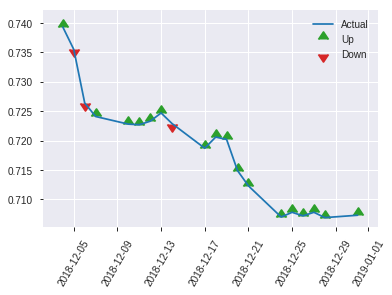


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24679331103253513
RMSE: 0.49678296169709274
LogLoss: 0.6860228247254714
Null degrees of freedom: 255
Residual degrees of freedom: -771
Null deviance: 354.4578805022527
Residual deviance: 351.24368625944135
AIC: 2405.2436862594413
AUC: 0.5704433497536946
pr_auc: 0.5150076335577524
Gini: 0.1408866995073892
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31169251104365525: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   121  0.8643   (121.0/140.0)
1      4    112  0.0345   (4.0/116.0)
Total  23   233  0.4883   (125.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311693     0.641834  232
max f2                       0.269709     0.812325  249
max f0point5                 0.311693     0.534351  232
max accuracy                 0.618835     0.589844  38
max precision                0.69376      0.75      7
max recall                   0.269709     1         249
max specificity              0.727212     0.992857  0
max absolute_mcc             0.311693     0.176225  232
max min_per_class_accuracy   0.495363     0.535714  127
max mean_per_class_accuracy  0.533055     0.570567  94

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 48.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.705128           0.735632  0.735632           0.333333         0.716859  0.333333                    0.716859            0.00862069      0.00862069                 -26.4368  -26.4368
    2        0.0234375                   0.696517           2.2069    1.47126            1                0.698987  0.666667                    0.707923            0.0258621       0.0344828                  120.69    47.1264
    3        0.03125                     0.693066           2.2069    1.65517            1                0.694376  0.75                        0.704536            0.0172414       0.0517241                  120.69    65.5172
    4        0.0429688                   0.683023           1.47126   1.60502            0.666667         0.686811  0.727273                    0.699702            0.0172414       0.0689655                  47.1264   60.5016
    5        0.0507812                   0.673694           0         1.35809            0                0.679445  0.615385                    0.696586            0               0.0689655                  -100      35.809
    6        0.101562                    0.646689           1.18833   1.27321            0.538462         0.660391  0.576923                    0.678488            0.0603448       0.12931                    18.8329   27.321
    7        0.152344                    0.617133           1.69761   1.41468            0.769231         0.629088  0.641026                    0.662021            0.0862069       0.215517                   69.7613   41.4677
    8        0.203125                    0.5984             0.509284  1.18833            0.230769         0.603775  0.538462                    0.64746             0.0258621       0.241379                   -49.0716  18.8329
    9        0.300781                    0.554656           0.882759  1.08912            0.4              0.572469  0.493506                    0.623112            0.0862069       0.327586                   -11.7241  8.91178
    10       0.402344                    0.524196           1.35809   1.15701            0.615385         0.538293  0.524272                    0.601702            0.137931        0.465517                   35.809    15.7014
    11       0.5                         0.494852           0.794483  1.08621            0.36             0.509478  0.492188                    0.583689            0.0775862       0.543103                   -20.5517  8.62069
    12       0.601562                    0.465468           0.933687  1.06046            0.423077         0.480696  0.480519                    0.566301            0.0948276       0.637931                   -6.6313   6.04568
    13       0.699219                    0.423173           1.14759   1.07263            0.52             0.444266  0.486034                    0.549257            0.112069        0.75                       14.7586   7.26257
    14       0.800781                    0.392859           0.848806  1.04424            0.384615         0.406699  0.473171                    0.531176            0.0862069       0.836207                   -15.1194  4.42389
    15       0.898438                    0.325088           1.05931   1.04588            0.48             0.363279  0.473913                    0.512926            0.103448        0.939655                   5.93103   4.58771
    16       1                           0.157197           0.594164  1                  0.269231         0.276002  0.453125                    0.488864          

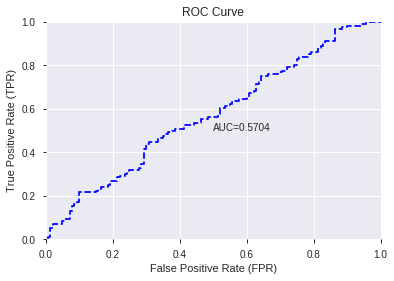

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


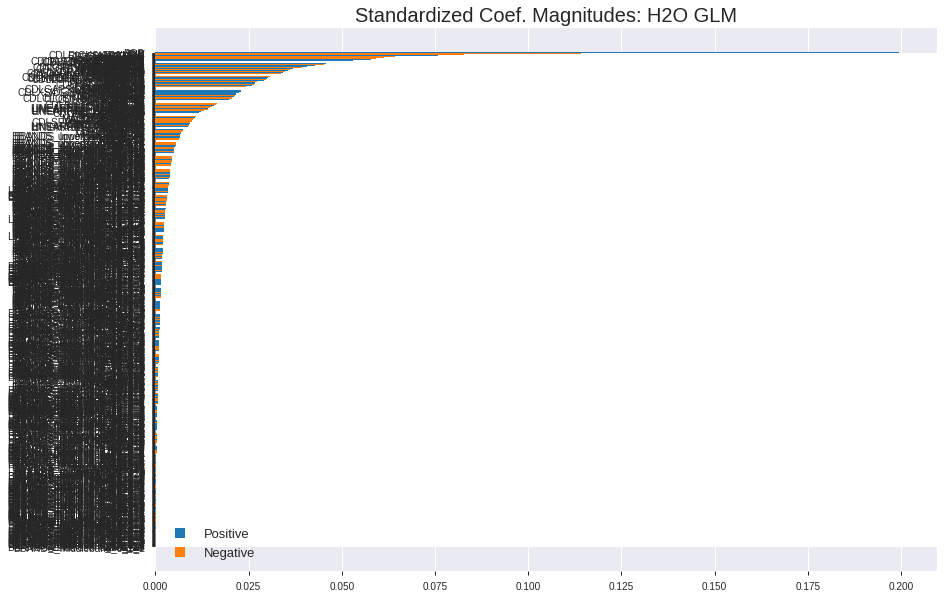

'log_likelihood'
--2019-08-22 15:58:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


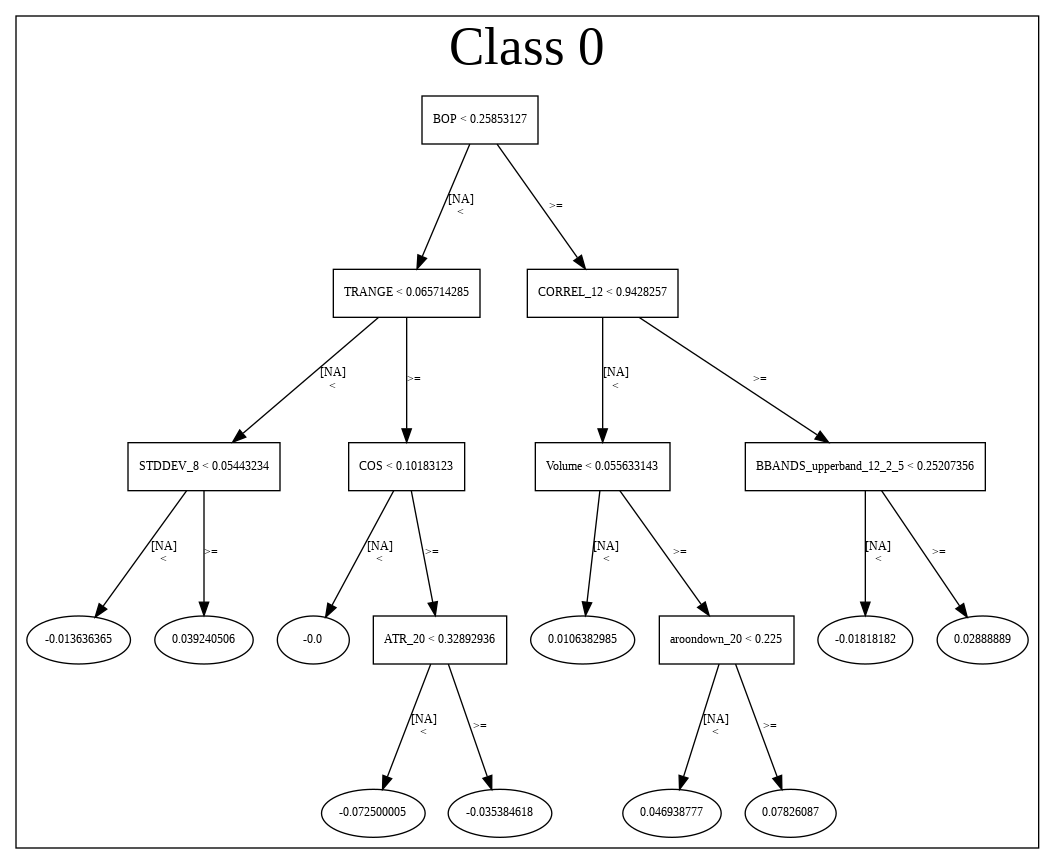

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_155650_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_155650_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

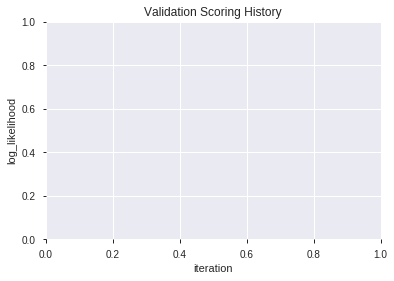

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190822_155815  0.591195  0.693371              0.452217  0.499183  0.249184
1  XGBoost_grid_1_AutoML_20190822_155815_model_3  0.587746  0.692867              0.439532  0.499465  0.249465
2  XGBoost_grid_1_AutoML_20190822_155815_model_6  0.584729  0.695120              0.462192  0.500477  0.250477
3  XGBoost_grid_1_AutoML_20190822_155815_model_4  0.573399  0.691065              0.447906  0.499184  0.249184
4  XGBoost_grid_1_AutoML_20190822_155815_model_7  0.572660  0.718917              0.445074  0.509935  0.260034
5  XGBoost_grid_1_AutoML_20190822_155815_model_1  0.570567  0.704259              0.450739  0.504444  0.254464
6  XGBoost_grid_1_AutoML_20190822_155815_model_5  0.568781  0.747414              0.464409  0.520899  0.271336
7  XGBoost_grid_1_AutoML_20190822_155815_model_2  0.566379  0.702281              0.443596  0.503969  0.253985
8               XGBoost_2_AutoML_20190822_155815  0.565948  0.709644              0.457882  0.506992  0.257040
9               XGBoost_1_AutoML_20190822_155815  0.542241  0.726622              0.468596  0.514354  0.264560

variable  relative_importance  scaled_importance  percentage
0                        BOP           576.231934           1.000000    0.082218
1                        SUB           329.159729           0.571228    0.046965
2                     ULTOSC           293.503754           0.509350    0.041878
3                        DIV           249.371735           0.432763    0.035581
4               STOCHF_fastk           191.301041           0.331986    0.027295
..                       ...                  ...                ...         ...
289                    Close             1.328774           0.002306    0.000190
290              MINUS_DM_14             0.892990           0.001550    0.000127
291  BBANDS_lowerband_20_3_2             0.757179           0.001314    0.000108
292                  ROCP_14             0.485893           0.000843    0.000069
293               PLUS_DI_20             0.060787           0.000105    0.000009

[294 rows x 4 columns]

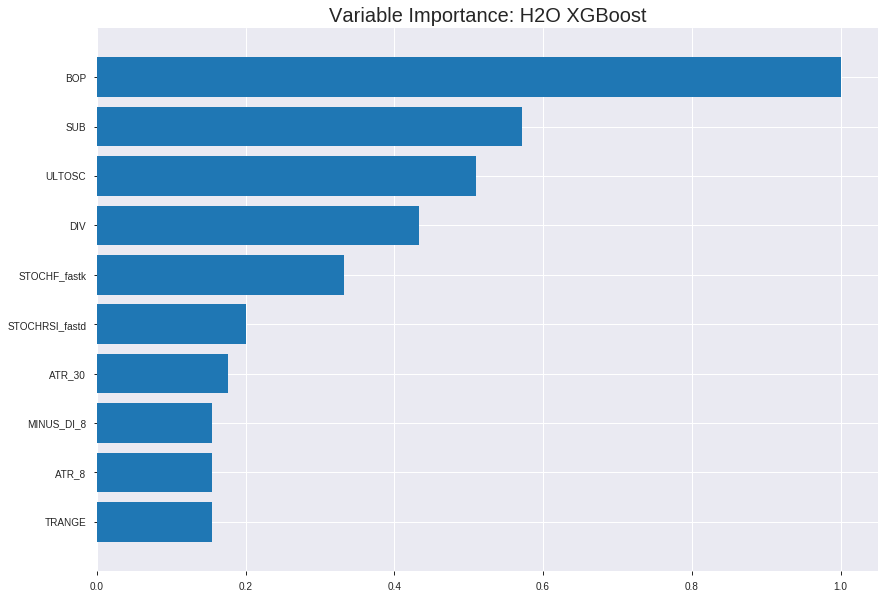

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190822_155815


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1568844763272704
RMSE: 0.396086450572688
LogLoss: 0.4963565720161722
Mean Per-Class Error: 0.1452315632555401
AUC: 0.940060380572989
pr_auc: 0.9424273250219914
Gini: 0.880120761145978
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4895711913704872: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      746  156  0.1729   (156.0/902.0)
1      104  781  0.1175   (104.0/885.0)
Total  850  937  0.1455   (260.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489571     0.8573    201
max f2                       0.409497     0.908517  254
max f0point5                 0.575154     0.884903  142
max accuracy                 0.493722     0.854505  198
max precision                0.832744     1         0
max recall                   0.313149     1         317
max specificity              0.832744     1         0
max absolute_mcc             0.489571     0.710347  201
max min_per_class_accuracy   0.501536     0.849224  192
max mean_per_class_accuracy  0.489571     0.854768  201

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.795233           2.01921    2.01921            1                0.80811   1                           0.80811             0.020339        0.020339                   101.921   101.921
    2        0.0201455                   0.774277           2.01921    2.01921            1                0.785073  1                           0.796592            0.020339        0.040678                   101.921   101.921
    3        0.0302182                   0.760387           2.01921    2.01921            1                0.768204  1                           0.787129            0.020339        0.0610169                  101.921   101.921
    4        0.040291                    0.74859            2.01921    2.01921            1                0.75365   1                           0.778759            0.020339        0.0813559                  101.921   101.921
    5        0.0503637                   0.741382           2.01921    2.01921            1                0.744336  1                           0.771875            0.020339        0.101695                   101.921   101.921
    6        0.100168                    0.70784            2.01921    2.01921            1                0.72364   1                           0.747892            0.100565        0.20226                    101.921   101.921
    7        0.149972                    0.67772            2.01921    2.01921            1                0.691125  1                           0.72904             0.100565        0.302825                   101.921   101.921
    8        0.200336                    0.649523           1.97434    2.00793            0.977778         0.664158  0.994413                    0.712729            0.099435        0.40226                    97.4338   100.793
    9        0.299944                    0.594342           1.89443    1.97024            0.938202         0.621487  0.975746                    0.682429            0.188701        0.59096                    89.4426   97.0236
    10       0.400112                    0.547392           1.51159    1.85541            0.748603         0.571156  0.918881                    0.654572            0.151412        0.742373                   51.1587   85.5413
    11       0.50028                     0.500445           1.12805    1.70978            0.558659         0.523747  0.846756                    0.628377            0.112994        0.855367                   12.805    70.9778
    12       0.599888                    0.4481             0.782727   1.55585            0.38764          0.475905  0.770522                    0.60306             0.0779661       0.933333                   -21.7273  55.5846
    13       0.700056                    0.401086           0.45122    1.39779            0.223464         0.422356  0.692246                    0.577204            0.0451977       0.978531                   -54.878   39.779
    14       0.799664                    0.347979           0.181502   1.24629            0.0898876        0.376581  0.617215                    0.552214            0.0180791       0.99661                    -81.8498  24.6286
    15       0.899832                    0.27952            0.0338415  1.11132            0.0167598        0.31471   0.550373                    0.525775            0.00338983      1                          -96.6159  11.1318
    16       1                           0.122342           0          1                  0                0.225159  0.495243                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2337424884790611
RMSE: 0.48346922185291286
LogLoss: 0.6588662161744834
Mean Per-Class Error: 0.3858636075900508
AUC: 0.6590884528092144
pr_auc: 0.6561763499420589
Gini: 0.3181769056184287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3586059510707855: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      65   174  0.728    (174.0/239.0)
1      16   255  0.059    (16.0/271.0)
Total  81   429  0.3725   (190.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358606     0.728571  326
max f2                       0.309543     0.861076  367
max f0point5                 0.369411     0.643411  316
max accuracy                 0.369411     0.629412  316
max precision                0.748417     0.857143  6
max recall                   0.241773     1         391
max specificity              0.796224     0.995816  0
max absolute_mcc             0.358606     0.290697  326
max min_per_class_accuracy   0.458522     0.598326  204
max mean_per_class_accuracy  0.419429     0.614136  257

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 46.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.762173           1.56827   1.56827            0.833333         0.778776  0.833333                    0.778776            0.0184502       0.0184502                  56.8266    56.8266
    2        0.0215686                   0.724231           1.12915   1.36867            0.6              0.738337  0.727273                    0.760395            0.0110701       0.0295203                  12.9151    36.8668
    3        0.0313725                   0.698934           1.50554   1.41144            0.8              0.706167  0.75                        0.743448            0.0147601       0.0442804                  50.5535    41.1439
    4        0.0411765                   0.687948           1.12915   1.34423            0.6              0.692778  0.714286                    0.731384            0.0110701       0.0553506                  12.9151    34.4228
    5        0.0509804                   0.666894           1.50554   1.37525            0.8              0.680972  0.730769                    0.72169             0.0147601       0.0701107                  50.5535    37.5248
    6        0.1                         0.618898           1.2797    1.32841            0.68             0.635103  0.705882                    0.679245            0.0627306       0.132841                   27.9705    32.8413
    7        0.15098                     0.584476           1.37525   1.34423            0.730769         0.603467  0.714286                    0.653658            0.0701107       0.202952                   37.5248    34.4228
    8        0.2                         0.562913           1.43026   1.36531            0.76             0.573076  0.72549                     0.633907            0.0701107       0.273063                   43.0258    36.5314
    9        0.3                         0.52572            1.14391   1.29151            0.607843         0.545406  0.686275                    0.604407            0.114391        0.387454                   14.3911    29.1513
    10       0.4                         0.491211           1.03321   1.22694            0.54902          0.508129  0.651961                    0.580338            0.103321        0.490775                   3.32103    22.6937
    11       0.5                         0.459756           0.99631   1.18081            0.529412         0.474615  0.627451                    0.559193            0.099631        0.590406                   -0.369004  18.0812
    12       0.6                         0.430486           1.10701   1.16851            0.588235         0.446824  0.620915                    0.540465            0.110701        0.701107                   10.7011    16.8512
    13       0.7                         0.404625           0.885609  1.1281             0.470588         0.419723  0.59944                     0.523216            0.0885609       0.789668                   -11.4391   12.8097
    14       0.8                         0.376138           1.07011   1.12085            0.568627         0.390839  0.595588                    0.506669            0.107011        0.896679                   7.01107    12.0849
    15       0.9                         0.330852           0.738007  1.07831            0.392157         0.354604  0.572985                    0.489773            0.0738007       0.97048                    -26.1993   7.83108
    16       1                           0.177352           0.295203  1                  0.156863         0.282179  0.531373                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:58:29  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.504757                         0.5                0.693147              0.5               0                    1                  0.468627
    2019-08-22 15:58:30  1.384 sec   5                  0.482184         0.658041            0.821295        0.818295           2.01921          0.271964                         0.494371           0.681916              0.618583          0.620647             0.627306           0.380392
    2019-08-22 15:58:30  1.646 sec   10                 0.466229         0.627241            0.855596        0.857711           2.01921          0.243984                         0.491046           0.675238              0.633876          0.641651             0.940959           0.396078
    2019-08-22 15:58:31  1.909 sec   15                 0.452492         0.601045            0.873288        0.877379           2.01921          0.224958                         0.486421           0.665912              0.652828          0.658656             1.25461            0.378431
    2019-08-22 15:58:31  2.168 sec   20                 0.443042         0.583236            0.893225        0.896142           2.01921          0.199217                         0.484853           0.662642              0.65878           0.657249             1.56827            0.382353
    2019-08-22 15:58:31  2.446 sec   25                 0.4333           0.564695            0.897612        0.900365           2.01921          0.193061                         0.483491           0.659675              0.659081          0.658966             1.56827            0.376471
    2019-08-22 15:58:31  2.703 sec   30                 0.425049         0.549191            0.905908        0.908812           2.01921          0.184107                         0.481377           0.655316              0.663821          0.663259             1.56827            0.366667
    2019-08-22 15:58:32  2.997 sec   35                 0.416942         0.534177            0.915312        0.918149           2.01921          0.174594                         0.482261           0.656952              0.660239          0.66258              1.25461            0.370588
    2019-08-22 15:58:32  3.278 sec   40                 0.408876         0.51948             0.927623        0.929692           2.01921          0.160604                         0.483465           0.65912               0.653924          0.656291             1.56827            0.390196
    2019-08-22 15:58:32  3.547 sec   45                 0.402337         0.507751            0.934974        0.937122           2.01921          0.160604                         0.483268           0.658663              0.65983           0.657869             1.25461            0.372549
    2019-08-22 15:58:32  3.818 sec   50                 0.396086         0.496357            0.94006         0.942427           2.01921          0.145495                         0.483469           0.658866              0.659088          0.656176             1.56827            0.372549

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ---------------------
BOP                      576.23193359375        1.0                     0.08221770970099279
SUB                      329.15972900390625     0.571227850825719       0.046965045612310984
ULTOSC                   293.5037536621094      0.5093500317339803      0.041877593045295855
DIV                      249.37173461914062     0.4327627819303581      0.035580764774144236
STOCHF_fastk             191.30104064941406     0.3319861838554117      0.02729514368896466
---                      ---                    ---                     ---
Close                    1.3287739753723145     0.0023059707348831436   0.0001895916324596073
MINUS_DM_14              0.8929901123046875     0.0015497060475899546   0.0001274132819426238
BBANDS_lowerband_20_3_2  0.7571792602539062     0.0013140182209820503   0.0001080355686345172
ROCP_14                  0.48589324951171875    0.0008432251341597444   6.932803929292656e-05
PLUS_DI_20               0.060787200927734375   0.00010549085773262617  8.67321671716979e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6015625)

('F1', 0.6420454545454546)

('auc', 0.5911945812807882)

('logloss', 0.6933710098947208)

('mean_per_class_error', 0.40701970443349755)

('rmse', 0.4991834780894388)

('mse', 0.24918414479746925)

xgboost prediction progress: |████████████████████████████████████████████| 100%


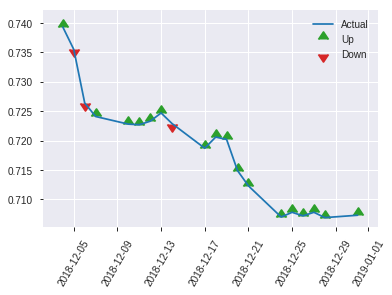


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24918414479746925
RMSE: 0.4991834780894388
LogLoss: 0.6933710098947208
Mean Per-Class Error: 0.40701970443349755
AUC: 0.5911945812807882
pr_auc: 0.5141324943721779
Gini: 0.18238916256157633
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3171303868293762: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   123  0.8786   (123.0/140.0)
1      3    113  0.0259   (3.0/116.0)
Total  20   236  0.4922   (126.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31713      0.642045  235
max f2                       0.284093     0.809859  245
max f0point5                 0.53096      0.554577  112
max accuracy                 0.561912     0.601562  89
max precision                0.825392     0.666667  2
max recall                   0.203916     1         253
max specificity              0.841804     0.992857  0
max absolute_mcc             0.53096      0.186426  112
max min_per_class_accuracy   0.520656     0.571429  126
max mean_per_class_accuracy  0.53096      0.59298   112

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 51.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.815202           1.47126   1.47126            0.666667         0.832939  0.666667                    0.832939            0.0172414       0.0172414                  47.1264   47.1264
    2        0.0234375                   0.790965           1.47126   1.47126            0.666667         0.798204  0.666667                    0.815571            0.0172414       0.0344828                  47.1264   47.1264
    3        0.03125                     0.762153           0         1.10345            0                0.77634   0.5                         0.805763            0               0.0344828                  -100      10.3448
    4        0.0429688                   0.743716           1.47126   1.20376            0.666667         0.755451  0.545455                    0.792042            0.0172414       0.0517241                  47.1264   20.3762
    5        0.0507812                   0.735583           0         1.01857            0                0.739354  0.461538                    0.783936            0               0.0517241                  -100      1.85676
    6        0.101562                    0.683035           1.35809   1.18833            0.615385         0.71215   0.538462                    0.748043            0.0689655       0.12069                    35.809    18.8329
    7        0.152344                    0.662857           1.35809   1.24492            0.615385         0.675485  0.564103                    0.723857            0.0689655       0.189655                   35.809    24.4916
    8        0.203125                    0.638169           1.01857   1.18833            0.461538         0.652914  0.538462                    0.706121            0.0517241       0.241379                   1.85676   18.8329
    9        0.300781                    0.585507           1.14759   1.1751             0.52             0.610717  0.532468                    0.675146            0.112069        0.353448                   14.7586   17.5101
    10       0.402344                    0.544533           1.35809   1.22129            0.615385         0.56506   0.553398                    0.647357            0.137931        0.491379                   35.809    22.1292
    11       0.5                         0.519455           0.971034  1.17241            0.44             0.531002  0.53125                     0.624632            0.0948276       0.586207                   -2.89655  17.2414
    12       0.601562                    0.477538           0.679045  1.08912            0.307692         0.496589  0.493506                    0.603014            0.0689655       0.655172                   -32.0955  8.91178
    13       0.699219                    0.446976           1.05931   1.08495            0.48             0.462786  0.49162                     0.583429            0.103448        0.758621                   5.93103   8.49547
    14       0.800781                    0.392593           0.848806  1.055              0.384615         0.421137  0.478049                    0.562846            0.0862069       0.844828                   -15.1194  5.50042
    15       0.898438                    0.338661           1.05931   1.05547            0.48             0.365294  0.478261                    0.541373            0.103448        0.948276                   5.93103   5.54723
    16       1                           0.155555           0.509284  1                  0.230769         0.28037   0.453125                    0.514865         

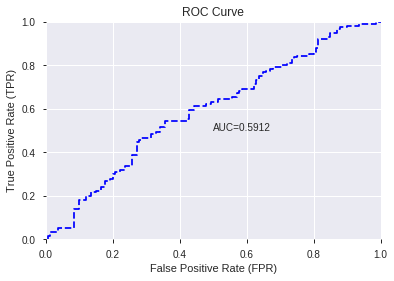

This function is available for GLM models only


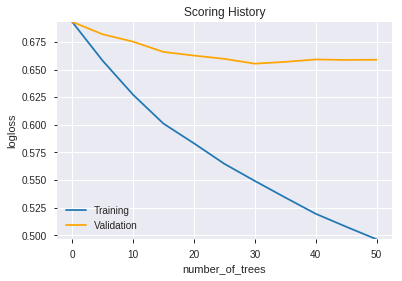

--2019-08-22 15:59:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

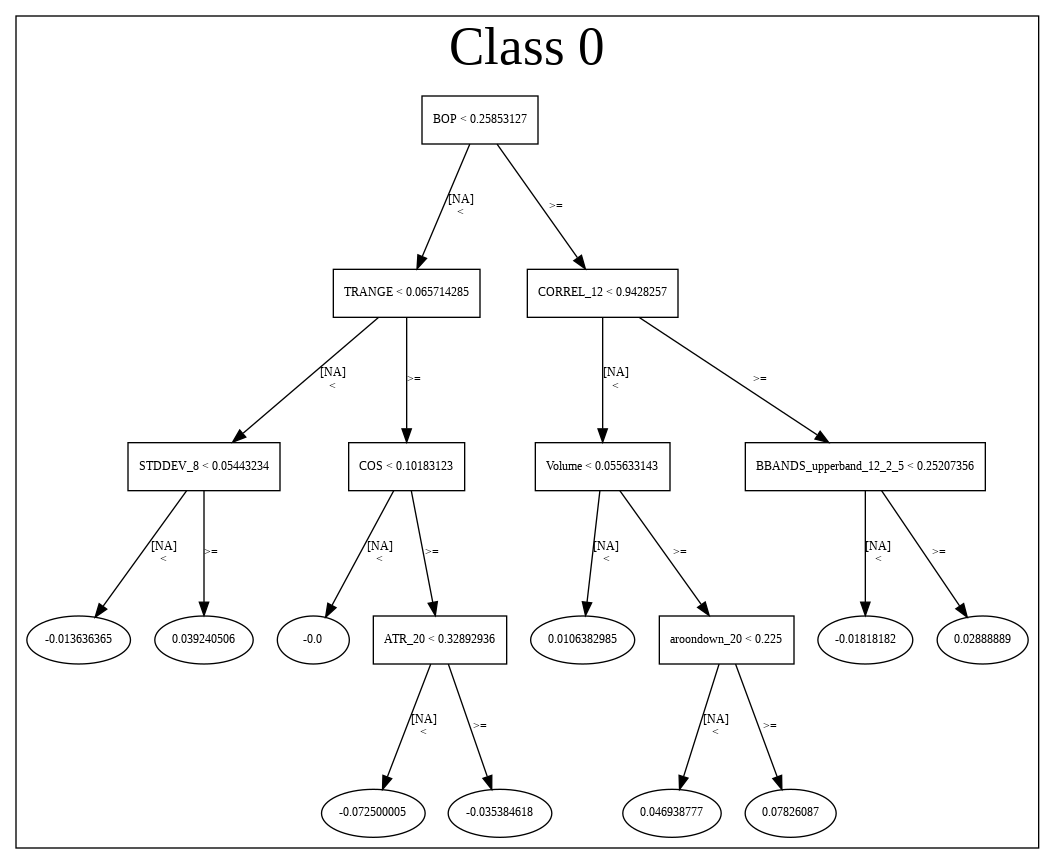

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190822_155815',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190822_155815',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b4a5',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_155928_model_9  0.562746  0.690579              0.445813  0.498918  0.248920
1  DeepLearning_grid_1_AutoML_20190822_155928_model_6  0.549323  0.753829              0.469335  0.515977  0.266232
2  DeepLearning_grid_1_AutoML_20190822_155928_model_5  0.545998  0.741179              0.479310  0.520317  0.270729
3  DeepLearning_grid_1_AutoML_20190822_155928_model_7  0.544397  0.872316              0.472906  0.543040  0.294892
4  DeepLearning_grid_1_AutoML_20190822_155928_model_8  0.540579  0.740439              0.475123  0.519141  0.269507
5               DeepLearning_1_AutoML_20190822_155928  0.537131  0.739475              0.490025  0.517298  0.267597
6  DeepLearning_grid_1_AutoML_20190822_155928_model_1  0.537007  1.053846              0.496429  0.577307  0.333284
7  DeepLearning_grid_1_AutoML_20190822_155928_model_3  0.530419  0.945617              0.477217  0.568075  0.322709
8  DeepLearning_grid_1_AutoML_20190822_155928_model_2  0.515702  0.925890              0.492857  0.572794  0.328093
9  DeepLearning_grid_1_AutoML_20190822_155928_model_4  0.493966  0.999021              0.483621  0.587719  0.345413

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.024772
1                    DIV             0.933120           0.933120    0.023116
2         CDLRICKSHAWMAN             0.918857           0.918857    0.022762
3                 TRANGE             0.906813           0.906813    0.022464
4                    SUB             0.894105           0.894105    0.022149
5      CDLGRAVESTONEDOJI             0.877343           0.877343    0.021734
6                 SAREXT             0.869515           0.869515    0.021540
7          days_in_month             0.847728           0.847728    0.021000
8               CORREL_8             0.841746           0.841746    0.020852
9           CDLSHORTLINE             0.837064           0.837064    0.020736
10        CDLSPINNINGTOP             0.820993           0.820993    0.020338
11                  DX_8             0.816816           0.816816    0.020235
12             aroonup_8             0.815653           0.815653    0.020206
13                 month             0.814718           0.814718    0.020183
14           CDLHIGHWAVE             0.813497           0.813497    0.020152
15            aroonup_20             0.810816           0.810816    0.020086
16            aroonup_12             0.809699           0.809699    0.020058
17            aroonup_30             0.806248           0.806248    0.019973
18   CDLRISEFALL3METHODS             0.803167           0.803167    0.019896
19        CDLMORNINGSTAR             0.802216           0.802216    0.019873
20                   day             0.801854           0.801854    0.019864
21          STOCHF_fastk             0.801258           0.801258    0.019849
22               BETA_30             0.800698           0.800698    0.019835
23           STOCH_slowk             0.799766           0.799766    0.019812
24             dayofyear             0.798038           0.798038    0.019769
25             CDLONNECK             0.796944           0.796944    0.019742
26             CDLTAKURI             0.796589           0.796589    0.019733
27      CDLDRAGONFLYDOJI             0.792002           0.792002    0.019620
28        STOCHRSI_fastk             0.791896           0.791896    0.019617
29          aroondown_14             0.789617           0.789617    0.019561
30        STOCHRSI_fastd             0.789471           0.789471    0.019557
31             dayofweek             0.785180           0.785180    0.019451
32            aroonup_14             0.782091           0.782091    0.019374
33          HT_TRENDMODE             0.781928           0.781928    0.019370
34               weekday             0.778366           0.778366    0.019282
35            weekofyear             0.778173           0.778173    0.019277
36               quarter             0.777690           0.777690    0.019265
37             CORREL_30             0.774881           0.774881    0.019196
38          STOCHF_fastd             0.773718           0.773718    0.019167
39          aroondown_20             0.772395           0.772395    0.019134
40           HT_DCPERIOD             0.769062           0.769062    0.019052
41           CDLBELTHOLD             0.767311           0.767311    0.019008
42                ULTOSC             0.765519           0.765519    0.018964
43               CDLDOJI             0.762858           0.762858    0.018898
44      CDLSTICKSANDWICH             0.762653           0.762653    0.018893
45         CDLHIKKAKEMOD             0.760784           0.760784    0.018846
46           AROONOSC_14             0.753447           0.753447    0.018665
47          weekday_name             0.751214           0.751214    0.018609
48             CORREL_24             0.748212           0.748212    0.018535
49  HT_PHASOR_quadrature             0.723692           0.723692    0.017928

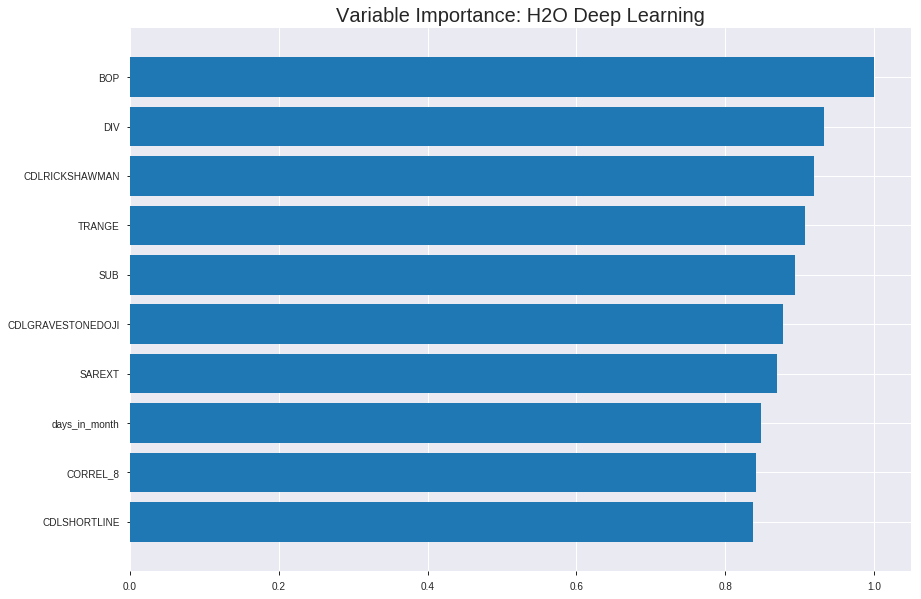

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_155928_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23047309865989793
RMSE: 0.48007613839879393
LogLoss: 0.6519656972869997
Mean Per-Class Error: 0.3792501284026708
AUC: 0.6657897703784434
pr_auc: 0.6526612582819009
Gini: 0.3315795407568869
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.360190198722472: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      140  762   0.8448   (762.0/902.0)
1      20   865   0.0226   (20.0/885.0)
Total  160  1627  0.4376   (782.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36019      0.688694  309
max f2                       0.351131     0.838479  315
max f0point5                 0.501283     0.617358  176
max accuracy                 0.507493     0.620034  167
max precision                0.674846     1         0
max recall                   0.132993     1         388
max specificity              0.674846     1         0
max absolute_mcc             0.501283     0.244189  176
max min_per_class_accuracy   0.513873     0.611299  158
max mean_per_class_accuracy  0.501283     0.62075   176

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.645574           1.68267   1.68267            0.833333         0.654595  0.833333                    0.654595            0.0169492       0.0169492                  68.2674   68.2674
    2        0.0201455                   0.633722           1.5705    1.62659            0.777778         0.639327  0.805556                    0.646961            0.0158192       0.0327684                  57.0496   62.6585
    3        0.0302182                   0.624443           1.90703   1.72007            0.944444         0.630297  0.851852                    0.641406            0.019209        0.0519774                  90.7031   72.0067
    4        0.040291                    0.617996           1.90703   1.76681            0.944444         0.621706  0.875                       0.636481            0.019209        0.0711864                  90.7031   76.6808
    5        0.0503637                   0.612725           1.5705    1.72755            0.777778         0.615244  0.855556                    0.632234            0.0158192       0.0870056                  57.0496   72.7546
    6        0.100168                    0.592849           1.31589   1.52287            0.651685         0.603003  0.75419                     0.6177              0.0655367       0.152542                   31.5889   52.2867
    7        0.149972                    0.581508           1.24783   1.43153            0.617978         0.587184  0.708955                    0.607566            0.0621469       0.214689                   24.7826   43.1529
    8        0.200336                    0.568977           1.23396   1.38186            0.611111         0.575197  0.684358                    0.599429            0.0621469       0.276836                   23.3961   38.1861
    9        0.299944                    0.549475           1.24783   1.33735            0.617978         0.559049  0.662313                    0.586019            0.124294        0.40113                    24.7826   33.7349
    10       0.400112                    0.5302             1.08293   1.27365            0.536313         0.539953  0.630769                    0.574486            0.108475        0.509605                   8.29278   27.3655
    11       0.50028                     0.513362           1.03781   1.22643            0.513966         0.52133   0.607383                    0.563843            0.103955        0.613559                   3.78058   22.6432
    12       0.599888                    0.495458           1.0096    1.19043            0.5              0.505208  0.589552                    0.554107            0.100565        0.714124                   0.960452  19.0429
    13       0.700056                    0.468808           0.846037  1.14115            0.418994         0.483283  0.565148                    0.543973            0.0847458       0.79887                    -15.3963  14.1152
    14       0.799664                    0.438628           0.862134  1.1064             0.426966         0.455047  0.547936                    0.532896            0.0858757       0.884746                   -13.7866  10.6397
    15       0.899832                    0.376793           0.834757  1.07616            0.413408         0.413188  0.53296                     0.519571            0.0836158       0.968362                   -16.5243  7.61581
    16       1                           0.0516279          0.315854  1                  0.156425         0.276813  0.495243                    0.495254         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23584642634487257
RMSE: 0.4856402231537999
LogLoss: 0.6640116670523963
Mean Per-Class Error: 0.3815328320647223
AUC: 0.6361994163874692
pr_auc: 0.6215721656079787
Gini: 0.2723988327749385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42886312312261077: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   201  0.841    (201.0/239.0)
1      9    262  0.0332   (9.0/271.0)
Total  47   463  0.4118   (210.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428863     0.713896  355
max f2                       0.395699     0.858328  373
max f0point5                 0.506495     0.644444  242
max accuracy                 0.506495     0.62549   242
max precision                0.651791     1         0
max recall                   0.358736     1         385
max specificity              0.651791     1         0
max absolute_mcc             0.502745     0.244709  252
max min_per_class_accuracy   0.523446     0.606695  195
max mean_per_class_accuracy  0.517357     0.618467  213

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 51.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.639296           1.56827   1.56827            0.833333         0.646781  0.833333                    0.646781            0.0184502       0.0184502                  56.8266   56.8266
    2        0.0215686                   0.62507            0.752768  1.19758            0.4              0.62983   0.636364                    0.639076            0.00738007      0.0258303                  -24.7232  19.7585
    3        0.0313725                   0.621006           0.376384  0.940959           0.2              0.623219  0.5                         0.63412             0.00369004      0.0295203                  -62.3616  -5.90406
    4        0.0411765                   0.619001           1.88192   1.165              1                0.619871  0.619048                    0.630728            0.0184502       0.0479705                  88.1919   16.4997
    5        0.0509804                   0.614666           1.50554   1.23049            0.8              0.617322  0.653846                    0.62815             0.0147601       0.0627306                  50.5535   23.0485
    6        0.1                         0.597482           1.2797    1.25461            0.68             0.604361  0.666667                    0.616489            0.0627306       0.125461                   27.9705   25.4613
    7        0.15098                     0.588883           1.23049   1.24647            0.653846         0.592536  0.662338                    0.608401            0.0627306       0.188192                   23.0485   24.6466
    8        0.2                         0.575139           1.05387   1.19926            0.56             0.580105  0.637255                    0.601466            0.0516605       0.239852                   5.38745   19.9262
    9        0.3                         0.559072           1.18081   1.19311            0.627451         0.567222  0.633987                    0.590051            0.118081        0.357934                   18.0812   19.3112
    10       0.4                         0.541182           1.25461   1.20849            0.666667         0.549876  0.642157                    0.580007            0.125461        0.483395                   25.4613   20.8487
    11       0.5                         0.523963           1.18081   1.20295            0.627451         0.531632  0.639216                    0.570332            0.118081        0.601476                   18.0812   20.2952
    12       0.6                         0.511912           0.95941   1.16236            0.509804         0.518411  0.617647                    0.561679            0.095941        0.697417                   -4.05904  16.2362
    13       0.7                         0.497398           1.03321   1.14391            0.54902          0.50518   0.607843                    0.553607            0.103321        0.800738                   3.32103   14.3911
    14       0.8                         0.473939           0.811808  1.1024             0.431373         0.485942  0.585784                    0.545149            0.0811808       0.881919                   -18.8192  10.2399
    15       0.9                         0.433253           0.701107  1.05781            0.372549         0.456135  0.562092                    0.535259            0.0701107       0.95203                    -29.8893  5.78106
    16       1                           0.171519           0.479705  1                  0.254902         0.368123  0.531373                    0.518545        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:05:53  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:05:55  2 min 18.045 sec  506 obs/sec       0.56967   1             1018       0.530594         0.789385            -0.12622       0.598006        0.570839           1.23396          0.481813                         0.536043           0.805549              -0.153911        0.569331          0.591506             1.25461            0.454902
    2019-08-22 16:06:06  2 min 28.558 sec  795 obs/sec       5.13262   9             9172       0.480076         0.651966            0.0780242      0.66579         0.652661           1.68267          0.437605                         0.48564            0.664012              0.0528856        0.636199          0.621572             1.56827            0.411765
    2019-08-22 16:06:16  2 min 38.649 sec  935 obs/sec       10.789    19            19280      0.476037         0.642405            0.093472       0.675848        0.66469            1.68267          0.437605                         0.487276           0.668358              0.0464935        0.623979          0.607487             0.627306           0.409804
    2019-08-22 16:06:26  2 min 49.159 sec  1043 obs/sec      17.5865   31            31427      0.471768         0.63304             0.109658       0.68998         0.681997           2.01921          0.419698                         0.490074           0.672547              0.0355135        0.627955          0.613163             1.25461            0.415686
    2019-08-22 16:06:37  2 min 59.476 sec  1133 obs/sec      24.9983   44            44672      0.467726         0.626774            0.12485        0.703989        0.697824           1.90703          0.414661                         0.490133           0.67621               0.0352811        0.632162          0.611487             1.25461            0.419608
    2019-08-22 16:06:47  3 min  9.730 sec  1211 obs/sec      32.9787   58            58933      0.461078         0.610834            0.14955        0.71762         0.711431           1.90703          0.392837                         0.488371           0.670928              0.0422056        0.633011          0.609609             0.940959           0.37451
    2019-08-22 16:06:58  3 min 20.406 sec  1274 obs/sec      41.5786   73            74301      0.456466         0.599939            0.166478       0.733421        0.731608           1.90703          0.368215                         0.490633           0.67699               0.0333131        0.62015           0.603063             1.25461            0.386275
    2019-08-22 16:06:59  3 min 21.492 sec  1273 obs/sec      41.5786   73            74301      0.480076         0.651966            0.0780242      0.66579         0.652661           1.68267          0.437605                         0.48564            0.664012              0.0528856        0.636199          0.621572             1.56827            0.411765

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  --------------------
BOP                   1.0                    1.0                  0.024772449077384847
DIV                   0.9331201910972595     0.9331201910972595   0.02311567241703648
CDLRICKSHAWMAN        0.9188571572303772     0.9188571572303772   0.022762342136880123
TRANGE                0.9068132638931274     0.9068132638931274   0.022463985402489648
SUB                   0.8941054940223694     0.8941054940223694   0.022149182820479167
---                   ---                    ---                  ---
CDLHIKKAKEMOD         0.7607842087745667     0.7607842087745667   0.018846488070746476
AROONOSC_14           0.7534469962120056     0.7534469962120056   0.018664727346170484
weekday_name          0.751214325428009      0.751214325428009    0.018609418622867364
CORREL_24             0.7482120394706726     0.7482120394706726   0.0185350446468735
HT_PHASOR_quadrature  0.7236916422843933     0.7236916422843933   0.017927614356219146


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.59375)

('F1', 0.6436781609195403)

('auc', 0.5627463054187192)

('logloss', 0.6905794591068435)

('mean_per_class_error', 0.4408866995073891)

('rmse', 0.4989184560659225)

('mse', 0.24891962580320384)

deeplearning prediction progress: |███████████████████████████████████████| 100%


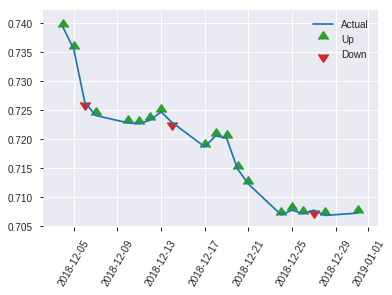


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24891962580320384
RMSE: 0.4989184560659225
LogLoss: 0.6905794591068435
Mean Per-Class Error: 0.4408866995073891
AUC: 0.5627463054187192
pr_auc: 0.5141082405410546
Gini: 0.12549261083743835
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44223655834372083: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   120  0.8571   (120.0/140.0)
1      4    112  0.0345   (4.0/116.0)
Total  24   232  0.4844   (124.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442237     0.643678  231
max f2                       0.396132     0.815752  246
max f0point5                 0.442237     0.536398  231
max accuracy                 0.613182     0.59375   31
max precision                0.656524     0.75      3
max recall                   0.396132     1         246
max specificity              0.672113     0.992857  0
max absolute_mcc             0.442237     0.185084  231
max min_per_class_accuracy   0.542426     0.543103  124
max mean_per_class_accuracy  0.613182     0.559113  31

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 53.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.65662            1.47126   1.47126            0.666667         0.665205  0.666667                    0.665205            0.0172414       0.0172414                  47.1264   47.1264
    2        0.0234375                   0.644966           1.47126   1.47126            0.666667         0.650786  0.666667                    0.657996            0.0172414       0.0344828                  47.1264   47.1264
    3        0.03125                     0.644351           2.2069    1.65517            1                0.644416  0.75                        0.654601            0.0172414       0.0517241                  120.69    65.5172
    4        0.0429688                   0.640547           0.735632  1.40439            0.333333         0.642036  0.636364                    0.651174            0.00862069      0.0603448                  -26.4368  40.4389
    5        0.0507812                   0.639512           0         1.18833            0                0.639854  0.538462                    0.649433            0               0.0603448                  -100      18.8329
    6        0.101562                    0.620283           1.69761   1.44297            0.769231         0.628278  0.653846                    0.638855            0.0862069       0.146552                   69.7613   44.2971
    7        0.152344                    0.60553            1.01857   1.3015             0.461538         0.612705  0.589744                    0.630139            0.0517241       0.198276                   1.85676   30.1503
    8        0.203125                    0.593458           0.509284  1.10345            0.230769         0.598214  0.5                         0.622158            0.0258621       0.224138                   -49.0716  10.3448
    9        0.300781                    0.576282           1.14759   1.11778            0.52             0.585384  0.506494                    0.610218            0.112069        0.336207                   14.7586   11.7779
    10       0.402344                    0.556772           0.933687  1.07131            0.423077         0.567907  0.485437                    0.599538            0.0948276       0.431034                   -6.6313   7.1309
    11       0.5                         0.541665           1.14759   1.08621            0.52             0.547836  0.492188                    0.58944             0.112069        0.543103                   14.7586   8.62069
    12       0.601562                    0.525824           0.763926  1.0318             0.346154         0.533309  0.467532                    0.579963            0.0775862       0.62069                    -23.6074  3.17958
    13       0.699219                    0.506734           1.32414   1.07263            0.6              0.515578  0.486034                    0.570971            0.12931         0.75                       32.4138   7.26257
    14       0.800781                    0.476838           0.763926  1.03347            0.346154         0.494367  0.468293                    0.561255            0.0775862       0.827586                   -23.6074  3.34735
    15       0.898438                    0.443206           1.23586   1.05547            0.56             0.463533  0.478261                    0.550633            0.12069         0.948276                   23.5862   5.54723
    16       1                           0.218913           0.509284  1                  0.230769         0.384792  0.453125                    0.53379           

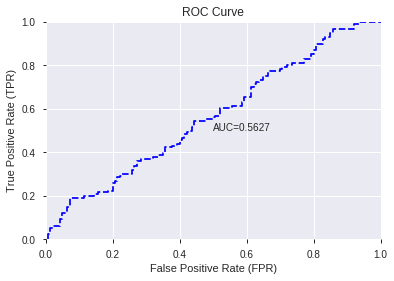

This function is available for GLM models only


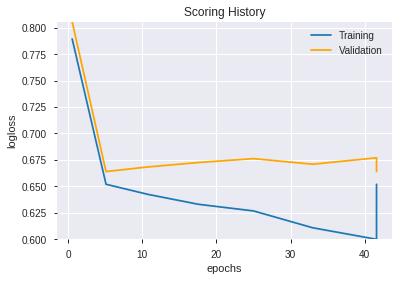

--2019-08-22 16:07:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


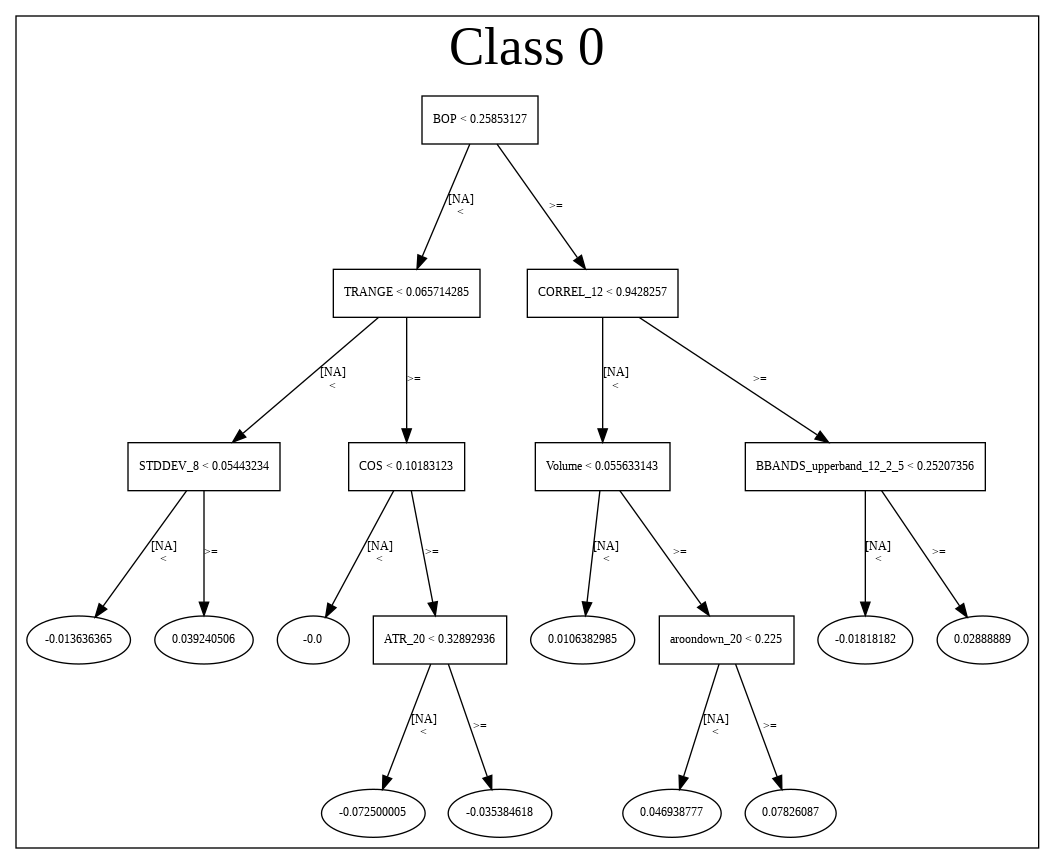

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_155928_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_155928_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'CDLRICKSHAWMAN',
 'TRANGE',
 'SUB',
 'CDLGRAVESTONEDOJI',
 'SAREXT',
 'days_in_month',
 'CORREL_8',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'DX_8',
 'aroonup_8',
 'month',
 'CDLHIGHWAVE',
 'aroonup_20',
 'aroonup_12',
 'aroonup_30',
 'CDLRISEFALL3METHODS',
 'CDLMORNINGSTAR',
 'day',
 'STOCHF_fastk',
 'BETA_30',
 'STOCH_slowk',
 'dayofyear',
 'CDLONNECK',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'STOCHRSI_fastk',
 'aroondown_14',
 'STOCHRSI_fastd',
 'dayofweek',
 'aroonup_14',
 'HT_TRENDMODE',
 'weekday',
 'weekofyear',
 'quarter',
 'CORREL_30',
 'STOCHF_fastd',
 'aroondown_20',
 'HT_DCPERIOD',
 'CDLBELTHOLD',
 'ULTOSC',
 'CDLDOJI',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'AROONOSC_14',
 'weekday_name',
 'CORREL_24',
 'HT_PHASOR_quadrature']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_160716_model_1  0.562315  0.697647              0.462192  0.502084  0.252089

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.267590           1.000000    0.092526
1         CDLRICKSHAWMAN             0.128477           0.480127    0.044424
2                    SUB             0.118752           0.443783    0.041062
3           STOCHF_fastk             0.111082           0.415120    0.038410
4              aroonup_8             0.110081           0.411379    0.038063
5             aroonup_12             0.105106           0.392788    0.036343
6               CORREL_8             0.103888           0.388236    0.035922
7           CDLSHORTLINE             0.101606           0.379707    0.035133
8      CDLGRAVESTONEDOJI             0.099710           0.372621    0.034477
9                    DIV             0.091571           0.342206    0.031663
10            aroonup_14             0.088375           0.330263    0.030558
11                SAREXT             0.084872           0.317171    0.029347
12                  DX_8             0.078341           0.292764    0.027088
13          aroondown_20             0.077885           0.291061    0.026931
14             CDLONNECK             0.076700           0.286632    0.026521
15      CDLSTICKSANDWICH             0.069621           0.260178    0.024073
16               CDLDOJI             0.068545           0.256157    0.023701
17             dayofweek             0.066615           0.248945    0.023034
18               weekday             0.066500           0.248515    0.022994
19           AROONOSC_14             0.061691           0.230541    0.021331
20                TRANGE             0.058560           0.218842    0.020249
21             CORREL_24             0.057005           0.213030    0.019711
22            aroonup_20             0.055139           0.206057    0.019066
23         days_in_month             0.052272           0.195344    0.018074
24      CDLDRAGONFLYDOJI             0.047199           0.176386    0.016320
25             CORREL_30             0.045661           0.170639    0.015789
26           STOCH_slowk             0.045653           0.170607    0.015786
27          STOCHF_fastd             0.045554           0.170238    0.015751
28             CDLTAKURI             0.042866           0.160193    0.014822
29   CDLRISEFALL3METHODS             0.038829           0.145106    0.013426
30          HT_TRENDMODE             0.037672           0.140781    0.013026
31                ULTOSC             0.036993           0.138245    0.012791
32           CDLHIGHWAVE             0.036818           0.137592    0.012731
33           CDLBELTHOLD             0.028909           0.108033    0.009996
34  HT_PHASOR_quadrature             0.026690           0.099743    0.009229
35        CDLMORNINGSTAR             0.026084           0.097476    0.009019
36          weekday_name             0.025890           0.096753    0.008952
37         CDLHIKKAKEMOD             0.024744           0.092468    0.008556
38        STOCHRSI_fastk             0.023979           0.089611    0.008291
39          aroondown_14             0.023838           0.089083    0.008243
40           HT_DCPERIOD             0.022766           0.085077    0.007872
41               BETA_30             0.021719           0.081166    0.007510
42               quarter             0.020453           0.076436    0.007072
43                   day             0.017064           0.063768    0.005900
44        STOCHRSI_fastd             0.012199           0.045588    0.004218
45             dayofyear             0.010245           0.038287    0.003543
46                 month             0.007923           0.029607    0.002739
47        CDLSPINNINGTOP             0.007817           0.029214    0.002703
48            aroonup_30             0.007446           0.027827    0.002575
49            weekofyear             0.007050           0.026345    0.002438

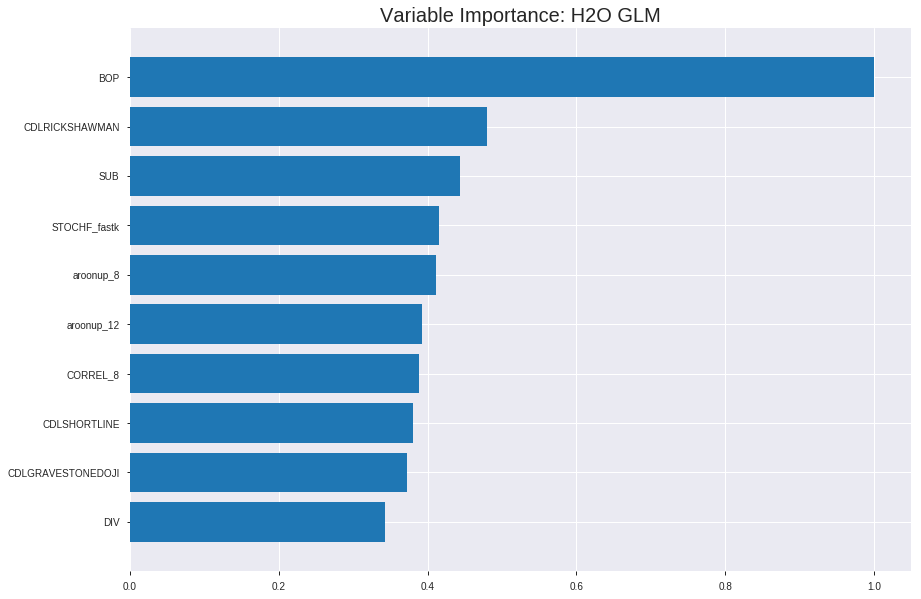

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_160716_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22471510770709138
RMSE: 0.4740412510605922
LogLoss: 0.6394517529633029
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2477.1462973227917
Residual deviance: 2285.4005650908443
AIC: 2387.4005650908443
AUC: 0.6822077743119497
pr_auc: 0.6645276992549531
Gini: 0.36441554862389935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37955471757316195: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      246  656   0.7273   (656.0/902.0)
1      80   805   0.0904   (80.0/885.0)
Total  326  1461  0.4119   (736.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379555     0.686275  292
max f2                       0.269156     0.839061  352
max f0point5                 0.517939     0.632668  179
max accuracy                 0.517939     0.635702  179
max precision                0.928803     1         0
max recall                   0.172771     1         387
max specificity              0.928803     1         0
max absolute_mcc             0.517939     0.271584  179
max min_per_class_accuracy   0.504139     0.633898  191
max mean_per_class_accuracy  0.504139     0.635685  191

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.797959           1.90703   1.90703            0.944444         0.854757  0.944444                    0.854757            0.019209        0.019209                   90.7031   90.7031
    2        0.0201455                   0.740533           1.45832   1.68267            0.722222         0.769494  0.833333                    0.812125            0.0146893       0.0338983                  45.8318   68.2674
    3        0.0302182                   0.71726            1.5705    1.64528            0.777778         0.727726  0.814815                    0.783992            0.0158192       0.0497175                  57.0496   64.5281
    4        0.040291                    0.705628           1.5705    1.62659            0.777778         0.711499  0.805556                    0.765869            0.0158192       0.0655367                  57.0496   62.6585
    5        0.0503637                   0.690081           1.5705    1.61537            0.777778         0.697297  0.8                         0.752154            0.0158192       0.0813559                  57.0496   61.5367
    6        0.100168                    0.654581           1.36126   1.48903            0.674157         0.669236  0.73743                     0.710927            0.0677966       0.149153                   36.1265   48.9026
    7        0.149972                    0.625318           1.45202   1.47673            0.719101         0.638734  0.731343                    0.686952            0.0723164       0.221469                   45.2015   47.6735
    8        0.200336                    0.605099           1.39101   1.45518            0.688889         0.615363  0.72067                     0.668955            0.0700565       0.291525                   39.1011   45.5184
    9        0.299944                    0.568804           1.2932    1.40139            0.640449         0.586158  0.69403                     0.641459            0.128814        0.420339                   29.3201   40.1391
    10       0.400112                    0.533252           1.04909   1.31319            0.519553         0.551721  0.65035                     0.618993            0.105085        0.525424                   4.90863   31.3192
    11       0.50028                     0.50324            1.10549   1.2716             0.547486         0.518522  0.629754                    0.598876            0.110734        0.636158                   10.5489   27.1605
    12       0.599888                    0.468289           0.873478  1.2055             0.432584         0.485757  0.597015                    0.580093            0.0870056       0.723164                   -12.6522  20.5498
    13       0.700056                    0.431348           0.846037  1.15406            0.418994         0.449829  0.571543                    0.561454            0.0847458       0.80791                    -15.3963  15.4064
    14       0.799664                    0.38675            0.839446  1.11487            0.41573          0.410342  0.552134                    0.542631            0.0836158       0.891525                   -16.0554  11.4875
    15       0.899832                    0.319065           0.721952  1.07114            0.357542         0.35737   0.530473                    0.522008            0.0723164       0.963842                   -27.8048  7.11351
    16       1                           0.0597545          0.360976  1                  0.178771         0.254807  0.495243                    0.495243         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23486196589099875
RMSE: 0.4846255935162718
LogLoss: 0.663744044388656
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 707.665141278386
Residual deviance: 677.0189252764291
AIC: 779.0189252764291
AUC: 0.6391560777532461
pr_auc: 0.6212573858693847
Gini: 0.27831215550649224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34192559842199327: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      31   208  0.8703   (208.0/239.0)
1      5    266  0.0185   (5.0/271.0)
Total  36   474  0.4176   (213.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341926     0.714094  365
max f2                       0.32627      0.858328  374
max f0point5                 0.49818      0.64311   215
max accuracy                 0.454209     0.62549   271
max precision                0.718523     0.777778  8
max recall                   0.280647     1         386
max specificity              0.918119     0.995816  0
max absolute_mcc             0.454209     0.248931  271
max min_per_class_accuracy   0.511153     0.60251   195
max mean_per_class_accuracy  0.49818      0.61822   215

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.745315           1.25461   1.25461            0.666667         0.809148  0.666667                    0.809148            0.0147601       0.0147601                  25.4613   25.4613
    2        0.0215686                   0.712117           1.50554   1.36867            0.8              0.723898  0.727273                    0.770398            0.0147601       0.0295203                  50.5535   36.8668
    3        0.0313725                   0.702222           0.752768  1.1762             0.4              0.704719  0.625                       0.749873            0.00738007      0.0369004                  -24.7232  17.6199
    4        0.0411765                   0.688278           0.752768  1.07538            0.4              0.696638  0.571429                    0.737198            0.00738007      0.0442804                  -24.7232  7.53822
    5        0.0509804                   0.681111           1.12915   1.08572            0.6              0.682811  0.576923                    0.726739            0.0110701       0.0553506                  12.9151   8.57224
    6        0.1                         0.644176           1.35498   1.21771            0.72             0.662781  0.647059                    0.695387            0.0664207       0.121771                   35.4982   21.7712
    7        0.15098                     0.618489           1.08572   1.17314            0.576923         0.631761  0.623377                    0.673903            0.0553506       0.177122                   8.57224   17.3144
    8        0.2                         0.602305           1.2797    1.19926            0.68             0.610917  0.637255                    0.658465            0.0627306       0.239852                   27.9705   19.9262
    9        0.3                         0.575598           1.21771   1.20541            0.647059         0.588745  0.640523                    0.635225            0.121771        0.361624                   21.7712   20.5412
    10       0.4                         0.542599           1.29151   1.22694            0.686275         0.556098  0.651961                    0.615443            0.129151        0.490775                   29.1513   22.6937
    11       0.5                         0.512737           1.03321   1.18819            0.54902          0.527901  0.631373                    0.597935            0.103321        0.594096                   3.32103   18.8192
    12       0.6                         0.487615           1.07011   1.16851            0.568627         0.500547  0.620915                    0.581703            0.107011        0.701107                   7.01107   16.8512
    13       0.7                         0.462654           0.922509  1.13337            0.490196         0.474468  0.602241                    0.566384            0.0922509       0.793358                   -7.74908  13.3368
    14       0.8                         0.415667           0.885609  1.1024             0.470588         0.438803  0.585784                    0.550436            0.0885609       0.881919                   -11.4391  10.2399
    15       0.9                         0.363576           0.664207  1.05371            0.352941         0.390555  0.559913                    0.532672            0.0664207       0.948339                   -33.5793  5.37105
    16       1                           0.184272           0.516605  1                  0.27451          0.305651  0.531373                    0.50997          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 16:07:16  0.000 sec   2            8         51            1.37601           1.37981
    2019-08-22 16:07:16  0.014 sec   4            5         51            1.37072           1.37585
    2019-08-22 16:07:16  0.029 sec   6            3.1       51            1.36335           1.37042
    2019-08-22 16:07:16  0.043 sec   8            1.9       51            1.35372           1.36352
    2019-08-22 16:07:17  0.057 sec   10           1.2       51            1.34208           1.35553
    2019-08-22 16:07:17  0.075 sec   12           0.74      51            1.32922           1.34729
    2019-08-22 16:07:17  0.095 sec   14           0.46      51            1.31628           1.33982
    2019-08-22 16:07:17  0.109 sec   16           0.28      51            1.30425           1.33388
    2019-08-22 16:07:17  0.123 sec   18           0.18      51            1.29386           1.32986
    2019-08-22 16:07:17  0.138 sec   20           0.11      51            1.2854            1.32779
    2019-08-22 16:07:17  0.153 sec   22           0.068     51            1.2789            1.32749
    2019-08-22 16:07:17  0.170 sec   24           0.042     51            1.27415           1.32868
    2019-08-22 16:07:17  0.190 sec   26           0.026     51            1.27083           1.33101
    2019-08-22 16:07:17  0.205 sec   28           0.016     51            1.26861           1.33412
    2019-08-22 16:07:17  0.222 sec   30           0.01      51            1.26719           1.33766
    2019-08-22 16:07:17  0.237 sec   32           0.0063    51            1.26632           1.34135

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57421875)

('F1', 0.6386554621848739)

('auc', 0.5623152709359606)

('logloss', 0.6976470115032061)

('mean_per_class_error', 0.44507389162561584)

('rmse', 0.5020844960987964)

('mse', 0.25208884122278225)

glm prediction progress: |████████████████████████████████████████████████| 100%


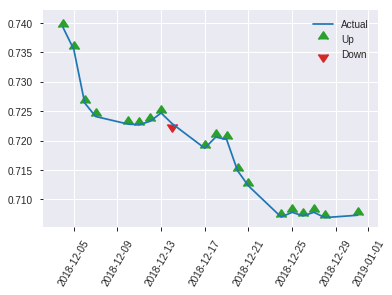


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25208884122278225
RMSE: 0.5020844960987964
LogLoss: 0.6976470115032061
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.4578805022527
Residual deviance: 357.1952698896415
AIC: 459.1952698896415
AUC: 0.5623152709359606
pr_auc: 0.5110049851601951
Gini: 0.12463054187192113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31991730761210735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   127  0.9071   (127.0/140.0)
1      2    114  0.0172   (2.0/116.0)
Total  15   241  0.5039   (129.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319917     0.638655  240
max f2                       0.245233     0.808926  252
max f0point5                 0.319917     0.527778  240
max accuracy                 0.624786     0.574219  52
max precision                0.717052     0.857143  6
max recall                   0.245233     1         252
max specificity              0.793529     0.992857  0
max absolute_mcc             0.319917     0.16027   240
max min_per_class_accuracy   0.520826     0.542857  126
max mean_per_class_accuracy  0.553196     0.554926  105

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 52.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.738251           1.47126   1.47126            0.666667         0.764871  0.666667                    0.764871            0.0172414       0.0172414                  47.1264   47.1264
    2        0.0234375                   0.719928           2.2069    1.83908            1                0.72917   0.833333                    0.747021            0.0258621       0.0431034                  120.69    83.908
    3        0.03125                     0.716043           1.10345   1.65517            0.5              0.716708  0.75                        0.739442            0.00862069      0.0517241                  10.3448   65.5172
    4        0.0429688                   0.706089           0.735632  1.40439            0.333333         0.709883  0.636364                    0.731381            0.00862069      0.0603448                  -26.4368  40.4389
    5        0.0507812                   0.703137           0         1.18833            0                0.705298  0.538462                    0.727368            0               0.0603448                  -100      18.8329
    6        0.101562                    0.682052           1.35809   1.27321            0.615385         0.693073  0.576923                    0.710221            0.0689655       0.12931                    35.809    27.321
    7        0.152344                    0.657855           1.01857   1.18833            0.461538         0.670816  0.538462                    0.697086            0.0517241       0.181034                   1.85676   18.8329
    8        0.203125                    0.625581           1.35809   1.23077            0.615385         0.639658  0.557692                    0.682729            0.0689655       0.25                       35.809    23.0769
    9        0.300781                    0.58917            0.971034  1.14644            0.44             0.607496  0.519481                    0.658303            0.0948276       0.344828                   -2.89655  14.644
    10       0.402344                    0.556479           1.01857   1.11416            0.461538         0.573656  0.504854                    0.636935            0.103448        0.448276                   1.85676   11.4161
    11       0.5                         0.518099           0.971034  1.08621            0.44             0.537392  0.492188                    0.617493            0.0948276       0.543103                   -2.89655  8.62069
    12       0.601562                    0.492664           0.933687  1.06046            0.423077         0.506534  0.480519                    0.59876             0.0948276       0.637931                   -6.6313   6.04568
    13       0.699219                    0.467494           1.05931   1.0603             0.48             0.479284  0.480447                    0.582073            0.103448        0.741379                   5.93103   6.02967
    14       0.800781                    0.42416            0.848806  1.03347            0.384615         0.445721  0.468293                    0.56478             0.0862069       0.827586                   -15.1194  3.34735
    15       0.898438                    0.359233           1.05931   1.03628            0.48             0.391213  0.469565                    0.545914            0.103448        0.931034                   5.93103   3.62819
    16       1                           0.153993           0.679045  1                  0.307692         0.297173  0.453125                    0.520651            

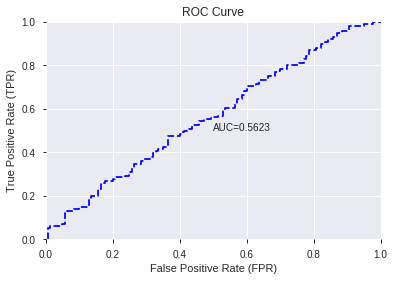

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


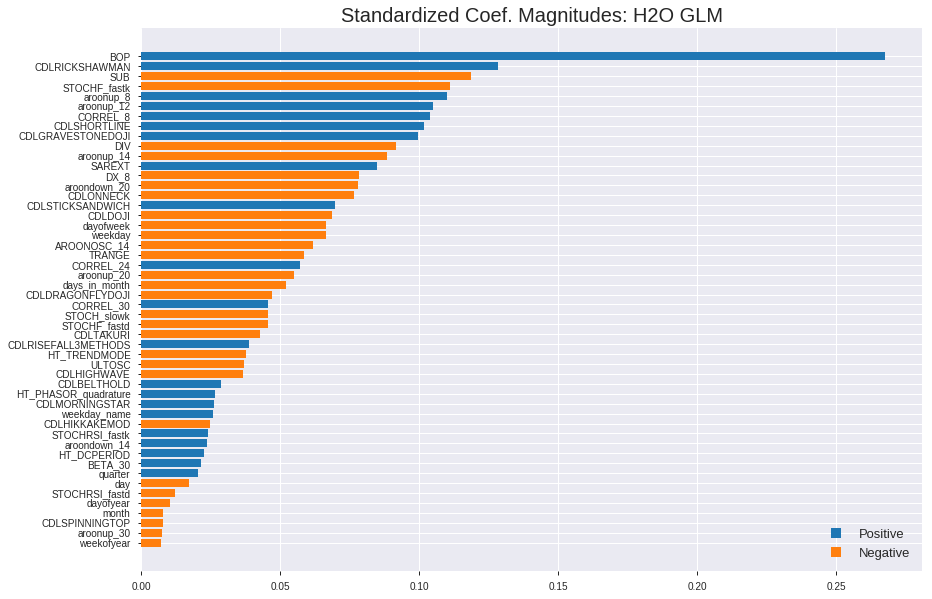

'log_likelihood'
--2019-08-22 16:07:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


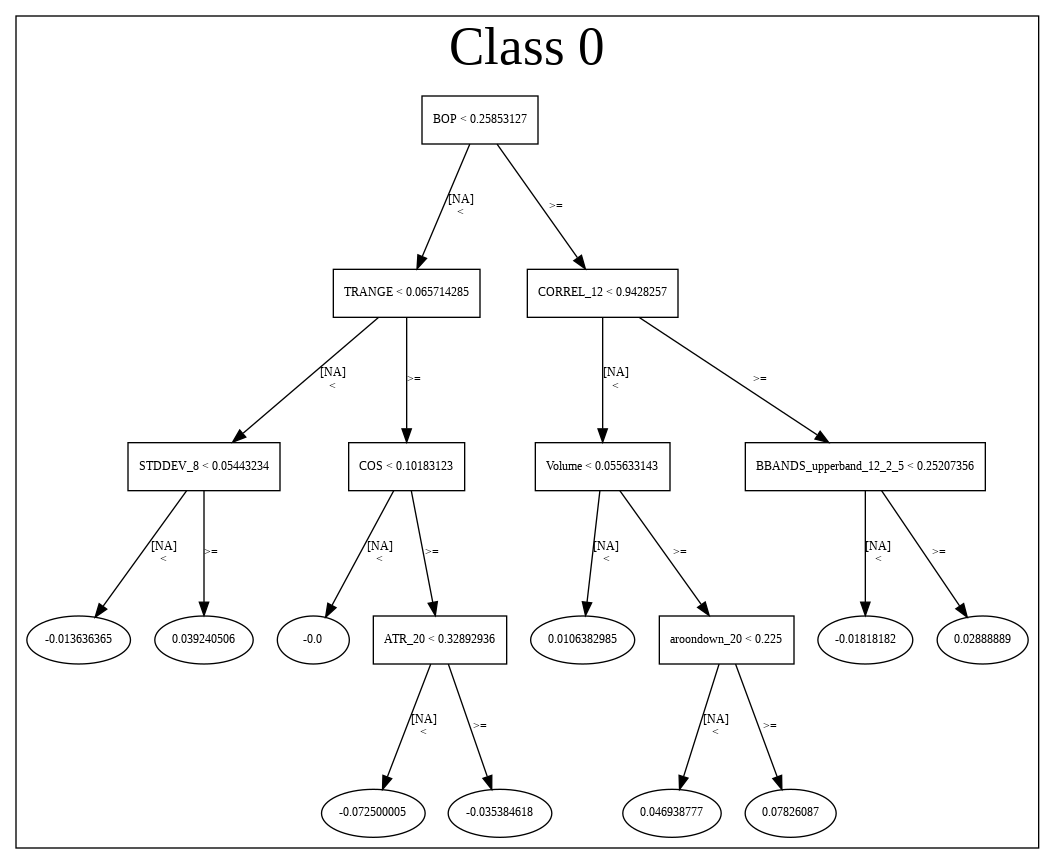

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_160716_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_160716_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLRICKSHAWMAN',
 'SUB',
 'STOCHF_fastk',
 'aroonup_8',
 'aroonup_12',
 'CORREL_8',
 'CDLSHORTLINE',
 'CDLGRAVESTONEDOJI',
 'DIV',
 'aroonup_14',
 'SAREXT',
 'DX_8',
 'aroondown_20',
 'CDLONNECK',
 'CDLSTICKSANDWICH',
 'CDLDOJI',
 'dayofweek',
 'weekday',
 'AROONOSC_14',
 'TRANGE',
 'CORREL_24',
 'aroonup_20',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'CORREL_30',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'HT_TRENDMODE',
 'ULTOSC',
 'CDLHIGHWAVE',
 'CDLBELTHOLD',
 'HT_PHASOR_quadrature',
 'CDLMORNINGSTAR',
 'weekday_name',
 'CDLHIKKAKEMOD',
 'STOCHRSI_fastk',
 'aroondown_14',
 'HT_DCPERIOD',
 'BETA_30',
 'quarter',
 'day',
 'STOCHRSI_fastd',
 'dayofyear',
 'month',
 'CDLSPINNINGTOP',
 'aroonup_30',
 'weekofyear']

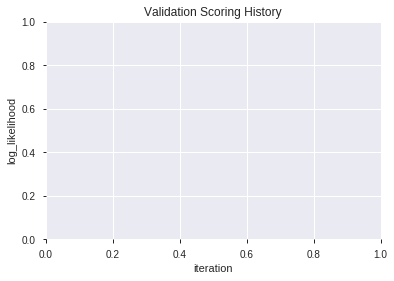

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_160733_model_6  0.574015  0.703637              0.457882  0.504298  0.254316
1  XGBoost_grid_1_AutoML_20190822_160733_model_4  0.570259  0.695381              0.455049  0.501063  0.251064
2  XGBoost_grid_1_AutoML_20190822_160733_model_7  0.565394  0.713661              0.432882  0.509278  0.259364
3               XGBoost_3_AutoML_20190822_160733  0.562438  0.708361              0.465025  0.506636  0.256680
4  XGBoost_grid_1_AutoML_20190822_160733_model_5  0.562069  0.741748              0.467241  0.518720  0.269070
5               XGBoost_1_AutoML_20190822_160733  0.556897  0.713879              0.453695  0.509356  0.259444
6  XGBoost_grid_1_AutoML_20190822_160733_model_1  0.550739  0.711409              0.444335  0.507993  0.258057
7  XGBoost_grid_1_AutoML_20190822_160733_model_2  0.546244  0.704356              0.445074  0.505268  0.255296
8  XGBoost_grid_1_AutoML_20190822_160733_model_3  0.546059  0.712072              0.468596  0.508554  0.258627
9               XGBoost_2_AutoML_20190822_160733  0.537869  0.718553              0.459360  0.511213  0.261339

variable  relative_importance  scaled_importance  percentage
0                    BOP           769.924805           1.000000    0.101612
1                 ULTOSC           502.931213           0.653221    0.066375
2           STOCHF_fastk           473.709625           0.615267    0.062519
3                    SUB           463.373901           0.601843    0.061155
4                    DIV           408.526581           0.530606    0.053916
5                BETA_30           343.207581           0.445768    0.045295
6   HT_PHASOR_quadrature           268.368073           0.348564    0.035418
7            HT_DCPERIOD           263.553070           0.342310    0.034783
8                 TRANGE           263.193146           0.341843    0.034735
9                 SAREXT           261.794495           0.340026    0.034551
10             dayofyear           253.014923           0.328623    0.033392
11        STOCHRSI_fastd           249.274002           0.323764    0.032898
12                  DX_8           244.437576           0.317482    0.032260
13              CORREL_8           238.040649           0.309174    0.031416
14             CORREL_30           229.957184           0.298675    0.030349
15           STOCH_slowk           205.300766           0.266650    0.027095
16                   day           202.152328           0.262561    0.026679
17             CORREL_24           192.787140           0.250397    0.025443
18             dayofweek           162.140488           0.210593    0.021399
19           AROONOSC_14           124.025154           0.161087    0.016368
20        STOCHRSI_fastk           112.534271           0.146163    0.014852
21          STOCHF_fastd           111.119110           0.144325    0.014665
22        CDLRICKSHAWMAN           109.731667           0.142523    0.014482
23          aroondown_14           102.222992           0.132770    0.013491
24     CDLGRAVESTONEDOJI            99.468491           0.129192    0.013128
25            aroonup_12            91.982246           0.119469    0.012140
26          aroondown_20            90.618019           0.117697    0.011959
27            aroonup_20            87.401443           0.113519    0.011535
28            aroonup_30            85.473053           0.111015    0.011280
29          CDLSHORTLINE            80.413864           0.104444    0.010613
30             aroonup_8            78.145462           0.101498    0.010313
31            aroonup_14            72.329308           0.093943    0.009546
32          weekday_name            66.065506           0.085808    0.008719
33         days_in_month            43.327160           0.056275    0.005718
34      CDLDRAGONFLYDOJI            42.625813           0.055364    0.005626
35               weekday            32.041973           0.041617    0.004229
36            weekofyear            30.507374           0.039624    0.004026
37        CDLSPINNINGTOP            29.851681           0.038772    0.003940
38          HT_TRENDMODE            24.369534           0.031652    0.003216
39             CDLTAKURI            20.126692           0.026141    0.002656
40           CDLHIGHWAVE            17.207150           0.022349    0.002271
41                 month            13.682028           0.017771    0.001806
42               CDLDOJI             8.503270           0.011044    0.001122
43           CDLBELTHOLD             5.072277           0.006588    0.000669
44               quarter             2.546855           0.003308    0.000336

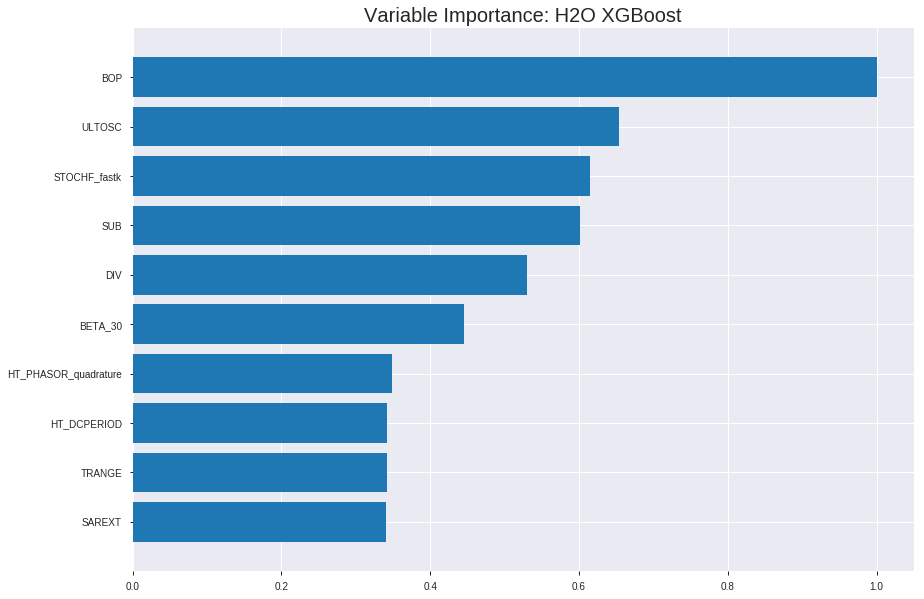

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_160733_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17012634344908723
RMSE: 0.41246374804228214
LogLoss: 0.5242125687334515
Mean Per-Class Error: 0.17266964811404661
AUC: 0.9023832788404925
pr_auc: 0.9026209014466196
Gini: 0.804766557680985
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48399747535586357: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      712  190  0.2106   (190.0/902.0)
1      133  752  0.1503   (133.0/885.0)
Total  845  942  0.1807   (323.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483997     0.823207  204
max f2                       0.392664     0.882414  272
max f0point5                 0.515424     0.838852  181
max accuracy                 0.508188     0.827644  186
max precision                0.848835     1         0
max recall                   0.279792     1         341
max specificity              0.848835     1         0
max absolute_mcc             0.508188     0.656343  186
max min_per_class_accuracy   0.493143     0.821469  196
max mean_per_class_accuracy  0.508188     0.82733   186

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.44 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.802742           2.01921    2.01921            1                0.816945  1                           0.816945            0.020339        0.020339                   101.921   101.921
    2        0.0201455                   0.779687           2.01921    2.01921            1                0.795021  1                           0.805983            0.020339        0.040678                   101.921   101.921
    3        0.0302182                   0.769018           2.01921    2.01921            1                0.772504  1                           0.794824            0.020339        0.0610169                  101.921   101.921
    4        0.040291                    0.75839            1.90703    1.99116            0.944444         0.763374  0.986111                    0.786961            0.019209        0.080226                   90.7031   99.1164
    5        0.0503637                   0.744622           2.01921    1.99677            1                0.751595  0.988889                    0.779888            0.020339        0.100565                   101.921   99.6773
    6        0.100168                    0.698941           1.99652    1.99665            0.988764         0.719492  0.988827                    0.749859            0.099435        0.2                        99.6521   99.6648
    7        0.149972                    0.664046           1.90577    1.96647            0.94382          0.681749  0.973881                    0.72724             0.0949153       0.294915                   90.577    96.6469
    8        0.200336                    0.631409           1.8846     1.94589            0.933333         0.646461  0.963687                    0.706933            0.0949153       0.389831                   88.4595   94.5886
    9        0.299944                    0.583661           1.71292    1.86852            0.848315         0.606227  0.925373                    0.673489            0.170621        0.560452                   71.2925   86.8522
    10       0.400112                    0.534832           1.45518    1.76504            0.72067          0.558404  0.874126                    0.644678            0.145763        0.706215                   45.5184   76.5043
    11       0.50028                     0.491228           1.17317    1.64654            0.581006         0.513332  0.815436                    0.618379            0.117514        0.823729                   17.3172   64.6536
    12       0.599888                    0.453707           0.748695   1.49745            0.370787         0.474211  0.741604                    0.594441            0.0745763       0.898305                   -25.1305  49.7454
    13       0.700056                    0.4082             0.485061   1.3526             0.240223         0.428511  0.669864                    0.570699            0.0485876       0.946893                   -51.4939  35.2596
    14       0.799664                    0.365708           0.385692   1.23216            0.191011         0.386625  0.610217                    0.54777             0.0384181       0.985311                   -61.4308  23.2156
    15       0.899832                    0.293838           0.135366   1.11006            0.0670391        0.332592  0.549751                    0.523817            0.0135593       0.99887                    -86.4634  11.0063
    16       1                           0.125976           0.0112805  1                  0.00558659       0.230463  0.495243                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2337818330796164
RMSE: 0.4835099100117974
LogLoss: 0.6590117866609759
Mean Per-Class Error: 0.39626210069632073
AUC: 0.6410860133705939
pr_auc: 0.6600197532820107
Gini: 0.2821720267411878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3410152643918991: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   200  0.8368   (200.0/239.0)
1      11   260  0.0406   (11.0/271.0)
Total  50   460  0.4137   (211.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341015     0.711354  354
max f2                       0.282553     0.858138  385
max f0point5                 0.384599     0.626639  315
max accuracy                 0.384599     0.603922  315
max precision                0.810093     1         0
max recall                   0.282553     1         385
max specificity              0.810093     1         0
max absolute_mcc             0.548095     0.215104  136
max min_per_class_accuracy   0.498281     0.590406  198
max mean_per_class_accuracy  0.520955     0.603738  166

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 49.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.774756           1.56827   1.56827            0.833333         0.791457  0.833333                    0.791457            0.0184502       0.0184502                  56.8266   56.8266
    2        0.0215686                   0.75078            1.88192   1.71084            1                0.754409  0.909091                    0.774617            0.0184502       0.0369004                  88.1919   71.0835
    3        0.0313725                   0.742967           0.752768  1.41144            0.4              0.745339  0.75                        0.765468            0.00738007      0.0442804                  -24.7232  41.1439
    4        0.0411765                   0.723182           1.88192   1.52346            1                0.729238  0.809524                    0.756842            0.0184502       0.0627306                  88.1919   52.3458
    5        0.0509804                   0.711393           1.50554   1.52001            0.8              0.720587  0.807692                    0.74987             0.0147601       0.0774908                  50.5535   52.0011
    6        0.1                         0.636903           1.50554   1.51292            0.8              0.667937  0.803922                    0.709707            0.0738007       0.151292                   50.5535   51.2915
    7        0.15098                     0.61744            1.23049   1.41755            0.653846         0.626709  0.753247                    0.681682            0.0627306       0.214022                   23.0485   41.7549
    8        0.2                         0.594782           1.05387   1.32841            0.56             0.606371  0.705882                    0.663223            0.0516605       0.265683                   5.38745   32.8413
    9        0.3                         0.555336           1.14391   1.26691            0.607843         0.572393  0.673203                    0.632946            0.114391        0.380074                   14.3911   26.6913
    10       0.4                         0.524439           1.07011   1.21771            0.568627         0.540776  0.647059                    0.609904            0.107011        0.487085                   7.01107   21.7712
    11       0.5                         0.495152           1.03321   1.18081            0.54902          0.510901  0.627451                    0.590103            0.103321        0.590406                   3.32103   18.0812
    12       0.6                         0.461088           0.774908  1.11316            0.411765         0.474816  0.591503                    0.570889            0.0774908       0.667897                   -22.5092  11.3161
    13       0.7                         0.424652           1.07011   1.10701            0.568627         0.442622  0.588235                    0.552565            0.107011        0.774908                   7.01107   10.7011
    14       0.8                         0.387147           1.03321   1.09779            0.54902          0.405779  0.583333                    0.534217            0.103321        0.878229                   3.32103   9.7786
    15       0.9                         0.341089           0.774908  1.06191            0.411765         0.36371   0.56427                     0.515272            0.0774908       0.95572                    -22.5092  6.19106
    16       1                           0.207781           0.442804  1                  0.235294         0.294058  0.531373                    0.49315           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:07:46  8.646 sec   0                  0.5              0.693147            0.5             0                  1                0.504757                         0.5                0.693147              0.5               0                    1                  0.468627
    2019-08-22 16:07:46  8.772 sec   5                  0.483987         0.661493            0.774951        0.775053           2.01921          0.299944                         0.493995           0.681177              0.63904           0.642827             1.34423            0.403922
    2019-08-22 16:07:46  8.840 sec   10                 0.471997         0.638059            0.802815        0.808876           2.01921          0.328483                         0.489614           0.672435              0.657143          0.653314             0.940959           0.398039
    2019-08-22 16:07:46  8.921 sec   15                 0.46064          0.616024            0.82258         0.827561           2.01921          0.268047                         0.486235           0.665622              0.655854          0.658549             0.940959           0.392157
    2019-08-22 16:07:46  8.999 sec   20                 0.452053         0.599419            0.835043        0.84057            2.01921          0.265249                         0.485079           0.663182              0.648011          0.657801             1.25461            0.392157
    2019-08-22 16:07:46  9.082 sec   25                 0.442842         0.581882            0.8581          0.859801           2.01921          0.232792                         0.483359           0.6597                0.654765          0.65692              0.940959           0.37451
    2019-08-22 16:07:47  9.154 sec   30                 0.43595          0.568637            0.869519        0.872027           2.01921          0.230554                         0.482641           0.658081              0.654047          0.654193             1.25461            0.390196
    2019-08-22 16:07:47  9.234 sec   35                 0.429839         0.55698             0.878141        0.880644           2.01921          0.213206                         0.481975           0.656565              0.65465           0.660014             0.940959           0.407843
    2019-08-22 16:07:47  9.315 sec   40                 0.422949         0.54414             0.891134        0.893405           2.01921          0.195299                         0.483138           0.658705              0.645556          0.659793             1.25461            0.411765
    2019-08-22 16:07:47  9.411 sec   45                 0.417108         0.533067            0.898121        0.899218           2.01921          0.182988                         0.483279           0.658682              0.642252          0.659145             1.56827            0.419608
    2019-08-22 16:07:47  9.488 sec   50                 0.412464         0.524213            0.902383        0.902621           2.01921          0.18075                          0.48351            0.659012              0.641086          0.66002              1.56827            0.413725

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           769.9248046875         1.0                    0.101612337620751
ULTOSC        502.93121337890625     0.6532212111065027     0.06637533424398981
STOCHF_fastk  473.7096252441406      0.615267390217947      0.06251875778186437
SUB           463.3739013671875      0.6018430612263018     0.06115468033203329
DIV           408.5265808105469      0.530605818027075      0.05391609752490191
---           ---                    ---                    ---
CDLHIGHWAVE   17.207149505615234     0.022349129942110826   0.0022709473372078005
month         13.682027816772461     0.017770602704930093   0.0018057124817775876
CDLDOJI       8.503270149230957      0.011044286529620638   0.0011222357716281248
CDLBELTHOLD   5.072276592254639      0.0065880155586276945  0.0006694236611940378
quarter       2.5468549728393555     0.003307926900566715   0.0003361261850451495


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6424581005586593)

('auc', 0.5740147783251232)

('logloss', 0.7036367882007051)

('mean_per_class_error', 0.41847290640394097)

('rmse', 0.5042978694716213)

('mse', 0.25431634115361634)

xgboost prediction progress: |████████████████████████████████████████████| 100%


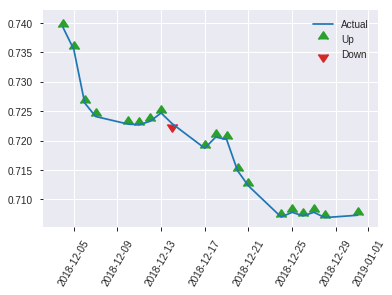


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25431634115361634
RMSE: 0.5042978694716213
LogLoss: 0.7036367882007051
Mean Per-Class Error: 0.41847290640394097
AUC: 0.5740147783251232
pr_auc: 0.494295063587111
Gini: 0.1480295566502463
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3555271029472351: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   127  0.9071   (127.0/140.0)
1      1    115  0.0086   (1.0/116.0)
Total  14   242  0.5      (128.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355527     0.642458  241
max f2                       0.355527     0.814448  241
max f0point5                 0.575287     0.541958  113
max accuracy                 0.581352     0.585938  107
max precision                0.727227     0.611111  17
max recall                   0.263617     1         253
max specificity              0.804957     0.992857  0
max absolute_mcc             0.355527     0.184426  241
max min_per_class_accuracy   0.555336     0.551724  125
max mean_per_class_accuracy  0.575287     0.581527  113

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 54.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.779759           0         0                  0                0.791645  0                           0.791645            0               0                          -100      -100
    2        0.0234375                   0.772864           0.735632  0.367816           0.333333         0.775566  0.166667                    0.783606            0.00862069      0.00862069                 -26.4368  -63.2184
    3        0.03125                     0.766038           2.2069    0.827586           1                0.769095  0.375                       0.779978            0.0172414       0.0258621                  120.69    -17.2414
    4        0.0429688                   0.739825           2.2069    1.20376            1                0.750706  0.545455                    0.771995            0.0258621       0.0517241                  120.69    20.3762
    5        0.0507812                   0.738038           1.10345   1.18833            0.5              0.73925   0.538462                    0.766957            0.00862069      0.0603448                  10.3448   18.8329
    6        0.101562                    0.697413           1.01857   1.10345            0.461538         0.721129  0.5                         0.744043            0.0517241       0.112069                   1.85676   10.3448
    7        0.152344                    0.664558           1.01857   1.07515            0.461538         0.681687  0.487179                    0.723258            0.0517241       0.163793                   1.85676   7.51547
    8        0.203125                    0.656171           1.35809   1.14589            0.615385         0.660399  0.519231                    0.707543            0.0689655       0.232759                   35.809    14.5889
    9        0.300781                    0.614882           1.05931   1.11778            0.48             0.633826  0.506494                    0.683609            0.103448        0.336207                   5.93103   11.7779
    10       0.402344                    0.584742           1.35809   1.17844            0.615385         0.600663  0.533981                    0.662671            0.137931        0.474138                   35.809    17.844
    11       0.5                         0.550186           0.882759  1.12069            0.4              0.569311  0.507812                    0.644437            0.0862069       0.560345                   -11.7241  12.069
    12       0.601562                    0.51844            0.933687  1.08912            0.423077         0.533506  0.493506                    0.625708            0.0948276       0.655172                   -6.6313   8.91178
    13       0.699219                    0.476172           0.882759  1.0603             0.4              0.499843  0.480447                    0.608129            0.0862069       0.741379                   -11.7241  6.02967
    14       0.800781                    0.439011           1.10345   1.06577            0.5              0.459708  0.482927                    0.589305            0.112069        0.853448                   10.3448   6.57696
    15       0.898438                    0.383079           0.971034  1.05547            0.44             0.410421  0.478261                    0.569861            0.0948276       0.948276                   -2.89655  5.54723
    16       1                           0.187297           0.509284  1                  0.230769         0.330373  0.453125                    0.545538            

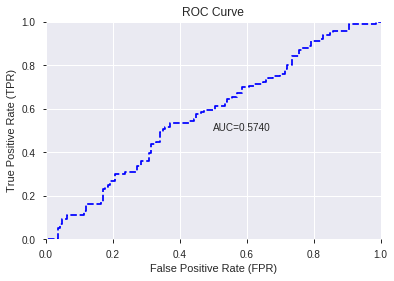

This function is available for GLM models only


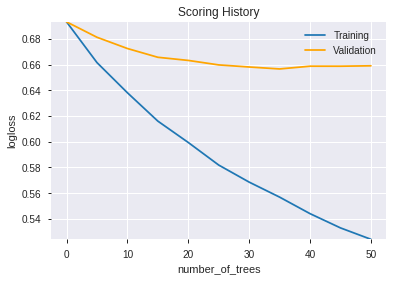

--2019-08-22 16:07:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.64
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.64|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Share

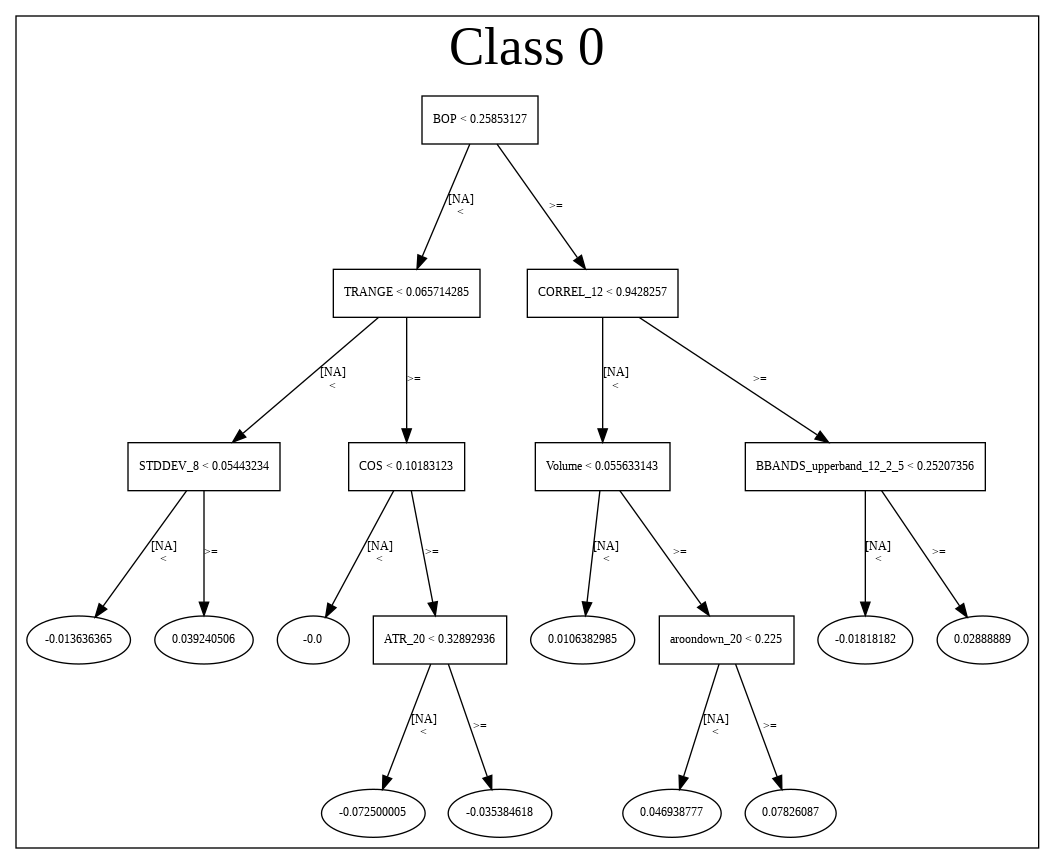

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_160733_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_160733_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'ULTOSC',
 'STOCHF_fastk',
 'SUB',
 'DIV',
 'BETA_30',
 'HT_PHASOR_quadrature',
 'HT_DCPERIOD',
 'TRANGE',
 'SAREXT',
 'dayofyear',
 'STOCHRSI_fastd',
 'DX_8',
 'CORREL_8',
 'CORREL_30',
 'STOCH_slowk',
 'day',
 'CORREL_24',
 'dayofweek',
 'AROONOSC_14',
 'STOCHRSI_fastk',
 'STOCHF_fastd',
 'CDLRICKSHAWMAN',
 'aroondown_14',
 'CDLGRAVESTONEDOJI',
 'aroonup_12',
 'aroondown_20',
 'aroonup_20',
 'aroonup_30',
 'CDLSHORTLINE',
 'aroonup_8',
 'aroonup_14',
 'weekday_name',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'weekday',
 'weekofyear',
 'CDLSPINNINGTOP',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'CDLHIGHWAVE',
 'month',
 'CDLDOJI',
 'CDLBELTHOLD',
 'quarter']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

7

['BOP',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_160809_model_6  0.577956  0.694106              0.472167  0.500125  0.250125
1  DeepLearning_grid_1_AutoML_20190822_160809_model_4  0.571675  0.702825              0.479310  0.503614  0.253627
2  DeepLearning_grid_1_AutoML_20190822_160809_model_3  0.567919  0.719272              0.452340  0.511883  0.262024
3               DeepLearning_1_AutoML_20190822_160809  0.566441  0.707062              0.458621  0.506024  0.256060
4  DeepLearning_grid_1_AutoML_20190822_160809_model_7  0.565825  0.687690              0.463670  0.497285  0.247292
5  DeepLearning_grid_1_AutoML_20190822_160809_model_5  0.565456  0.702723              0.462931  0.504481  0.254501
6  DeepLearning_grid_1_AutoML_20190822_160809_model_2  0.562931  0.717812              0.457882  0.510293  0.260399
7  DeepLearning_grid_1_AutoML_20190822_160809_model_1  0.551170  0.777208              0.500000  0.534369  0.285550

variable  relative_importance  scaled_importance  percentage
0               BOP             1.000000           1.000000    0.192132
1               DIV             0.819274           0.819274    0.157409
2               SUB             0.797533           0.797533    0.153231
3  CDLDRAGONFLYDOJI             0.775602           0.775602    0.149018
4    CDLRICKSHAWMAN             0.758378           0.758378    0.145708
5       CDLBELTHOLD             0.528251           0.528251    0.101494
6            TRANGE             0.525724           0.525724    0.101008

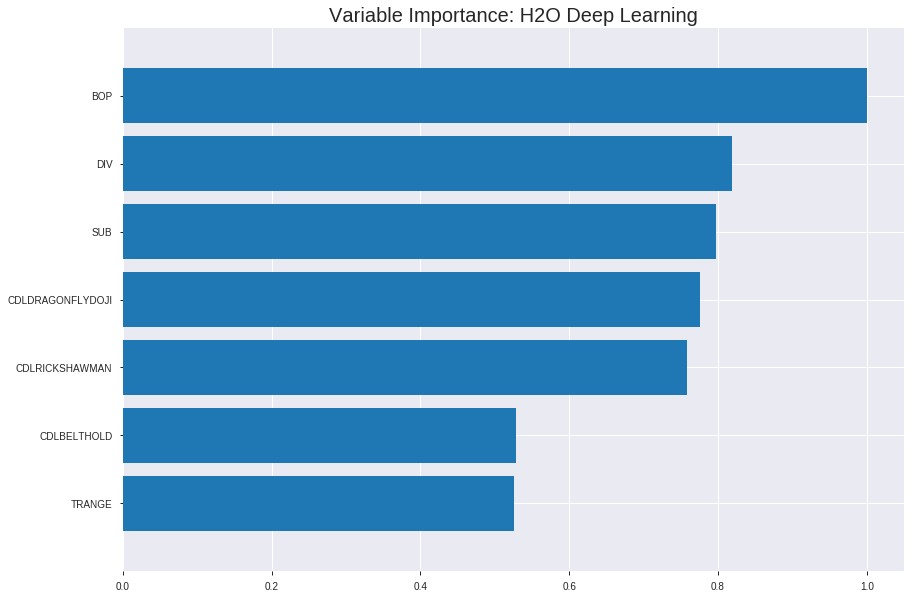

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_160809_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23074749823506438
RMSE: 0.4803618409439538
LogLoss: 0.6523843017927697
Mean Per-Class Error: 0.3859226828015583
AUC: 0.6534017312438147
pr_auc: 0.633141050792269
Gini: 0.30680346248762946
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20294054740371176: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      134  768   0.8514   (768.0/902.0)
1      23   862   0.026    (23.0/885.0)
Total  157  1630  0.4426   (791.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.202941     0.685487  329
max f2                       0.120726     0.836669  360
max f0point5                 0.48824      0.610737  182
max accuracy                 0.48824      0.613878  182
max precision                0.865838     1         0
max recall                   0.0211388    1         395
max specificity              0.865838     1         0
max absolute_mcc             0.48824      0.228325  182
max min_per_class_accuracy   0.492169     0.605322  178
max mean_per_class_accuracy  0.48824      0.614077  182

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 47.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100727                   0.715179           1.45832   1.45832            0.722222         0.774833  0.722222                    0.774833            0.0146893       0.0146893                  45.8318    45.8318
    2        0.0201455                   0.702793           1.79485   1.62659            0.888889         0.70997   0.805556                    0.742401            0.0180791       0.0327684                  79.4852    62.6585
    3        0.0302182                   0.691781           1.45832   1.5705             0.722222         0.696936  0.777778                    0.727246            0.0146893       0.0474576                  45.8318    57.0496
    4        0.040291                    0.677922           1.23396   1.48636            0.611111         0.684976  0.736111                    0.716678            0.0124294       0.059887                   23.3961    48.6362
    5        0.0503637                   0.664124           1.34614   1.45832            0.666667         0.669213  0.722222                    0.707185            0.0135593       0.0734463                  34.6139    45.8318
    6        0.100168                    0.635134           1.49739   1.47775            0.741573         0.646502  0.731844                    0.677013            0.0745763       0.148023                   49.7391    47.7745
    7        0.149972                    0.613715           1.24783   1.40139            0.617978         0.624151  0.69403                     0.659458            0.0621469       0.210169                   24.7826    40.1391
    8        0.200336                    0.593137           1.36858   1.39314            0.677778         0.602876  0.689944                    0.645233            0.0689266       0.279096                   36.8575    39.3141
    9        0.299944                    0.558857           1.05498   1.28084            0.522472         0.576761  0.634328                    0.622494            0.105085        0.384181                   5.498      28.0842
    10       0.400112                    0.519941           1.18445   1.25671            0.586592         0.54027   0.622378                    0.60191             0.118644        0.502825                   18.4452    25.6711
    11       0.50028                     0.49207            1.06037   1.2174             0.52514          0.504548  0.602908                    0.582415            0.106215        0.60904                    6.03668    21.7398
    12       0.599888                    0.474484           0.998261  1.18101            0.494382         0.48268   0.584888                    0.565855            0.099435        0.708475                   -0.173935  18.1011
    13       0.700056                    0.437135           0.846037  1.13308            0.418994         0.45651   0.561151                    0.550209            0.0847458       0.79322                    -15.3963   13.3081
    14       0.799664                    0.405139           0.884822  1.10216            0.438202         0.420982  0.545836                    0.534112            0.0881356       0.881356                   -11.5178   10.2157
    15       0.899832                    0.264117           0.800915  1.06862            0.396648         0.35986   0.529229                    0.514715            0.080226        0.961582                   -19.9085   6.86237
    16       1                           0.00355609         0.383537  1                  0.189944         0.12605   0.495243                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23762456278171742
RMSE: 0.48746749920555466
LogLoss: 0.6680534066034989
Mean Per-Class Error: 0.3880868934212355
AUC: 0.6255538915221788
pr_auc: 0.6269238692090291
Gini: 0.25110778304435755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3955422996650823: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   212  0.887    (212.0/239.0)
1      7    264  0.0258   (7.0/271.0)
Total  34   476  0.4294   (219.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395542     0.706827  366
max f2                       0.171849     0.851666  396
max f0point5                 0.481897     0.641711  264
max accuracy                 0.481897     0.623529  264
max precision                0.84711      1         0
max recall                   0.171849     1         396
max specificity              0.84711      1         0
max absolute_mcc             0.481897     0.241968  264
max min_per_class_accuracy   0.519486     0.594096  195
max mean_per_class_accuracy  0.481897     0.611913  264

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 51.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.666161           1.25461   1.25461            0.666667         0.774479  0.666667                    0.774479            0.0147601       0.0147601                  25.4613   25.4613
    2        0.0215686                   0.65631            1.50554   1.36867            0.8              0.661369  0.727273                    0.723066            0.0147601       0.0295203                  50.5535   36.8668
    3        0.0313725                   0.653471           1.50554   1.41144            0.8              0.654338  0.75                        0.701588            0.0147601       0.0442804                  50.5535   41.1439
    4        0.0411765                   0.65054            1.88192   1.52346            1                0.652153  0.809524                    0.689818            0.0184502       0.0627306                  88.1919   52.3458
    5        0.0509804                   0.646749           0.752768  1.37525            0.4              0.648328  0.730769                    0.681839            0.00738007      0.0701107                  -24.7232  37.5248
    6        0.1                         0.624519           1.2797    1.32841            0.68             0.634204  0.705882                    0.658489            0.0627306       0.132841                   27.9705   32.8413
    7        0.15098                     0.612175           1.23049   1.29535            0.653846         0.617699  0.688312                    0.644715            0.0627306       0.195572                   23.0485   29.5347
    8        0.2                         0.598927           0.903321  1.19926            0.48             0.605785  0.637255                    0.635174            0.0442804       0.239852                   -9.6679   19.9262
    9        0.3                         0.574649           1.18081   1.19311            0.627451         0.586441  0.633987                    0.618929            0.118081        0.357934                   18.0812   19.3112
    10       0.4                         0.54771            1.10701   1.17159            0.588235         0.558673  0.622549                    0.603865            0.110701        0.468635                   10.7011   17.1587
    11       0.5                         0.519915           1.21771   1.18081            0.647059         0.534981  0.627451                    0.590088            0.121771        0.590406                   21.7712   18.0812
    12       0.6                         0.505119           0.95941   1.14391            0.509804         0.512629  0.607843                    0.577179            0.095941        0.686347                   -4.05904  14.3911
    13       0.7                         0.481006           1.14391   1.14391            0.607843         0.491737  0.607843                    0.564973            0.114391        0.800738                   14.3911   14.3911
    14       0.8                         0.453357           0.627306  1.07934            0.333333         0.469476  0.573529                    0.553036            0.0627306       0.863469                   -37.2694  7.93358
    15       0.9                         0.414526           0.774908  1.04551            0.411765         0.433349  0.555556                    0.539737            0.0774908       0.940959                   -22.5092  4.55105
    16       1                           0.132998           0.590406  1                  0.313725         0.334954  0.531373                    0.519259         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:11:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:11:41  2 min  4.561 sec  1040 obs/sec      1         1             1787       0.613262         1.20275             -0.504499      0.620898        0.597365           1.45832          0.471181                         0.613368           1.09224               -0.510831        0.616769          0.632368             1.88192            0.445098
    2019-08-22 16:11:46  2 min  9.852 sec  3297 obs/sec      12        12            21444      0.484091         0.659801            0.0625406      0.646343        0.618278           1.45832          0.441522                         0.489411           0.671549              0.0381206        0.622798          0.627935             1.56827            0.419608
    2019-08-22 16:11:51  2 min 15.088 sec  4131 obs/sec      26        26            46462      0.482981         0.657354            0.066832       0.649671        0.627842           1.5705           0.442082                         0.489803           0.672303              0.0365805        0.620328          0.620704             1.25461            0.431373
    2019-08-22 16:11:57  2 min 20.397 sec  4565 obs/sec      41        41            73267      0.483108         0.657751            0.0663433      0.64977         0.625635           1.5705           0.442082                         0.489844           0.672567              0.036419         0.623114          0.622236             1.25461            0.423529
    2019-08-22 16:12:02  2 min 25.533 sec  4837 obs/sec      56        56            100072     0.483463         0.659091            0.0649695      0.652495        0.634306           1.45832          0.44376                          0.491113           0.675211              0.0314181        0.619648          0.622691             1.25461            0.417647
    2019-08-22 16:12:07  2 min 30.535 sec  5034 obs/sec      71        71            126877     0.480362         0.652384            0.0769265      0.653402        0.633141           1.45832          0.442641                         0.487467           0.668053              0.0457449        0.625554          0.626924             1.25461            0.429412
    2019-08-22 16:12:12  2 min 35.593 sec  5162 obs/sec      86        86            153682     0.479224         0.649915            0.0812953      0.657428        0.637588           1.5705           0.434247                         0.489518           0.67211               0.0376993        0.618869          0.61958              1.25461            0.419608
    2019-08-22 16:12:12  2 min 36.117 sec  5158 obs/sec      86        86            153682     0.480362         0.652384            0.0769265      0.653402        0.633141           1.45832          0.442641                         0.487467           0.668053              0.0457449        0.625554          0.626924             1.25461            0.429412

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  ------------
BOP               1                      1                    0.192132
DIV               0.819274               0.819274             0.157409
SUB               0.797533               0.797533             0.153231
CDLDRAGONFLYDOJI  0.775602               0.775602             0.149018
CDLRICKSHAWMAN    0.758378               0.758378             0.145708
CDLBELTHOLD       0.528251               0.528251             0.101494
TRANGE            0.525724               0.525724             0.101008

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6353591160220994)

('auc', 0.5779556650246305)

('logloss', 0.694106373923392)

('mean_per_class_error', 0.4293103448275861)

('rmse', 0.5001253451666346)

('mse', 0.2501253608780455)

deeplearning prediction progress: |███████████████████████████████████████| 100%


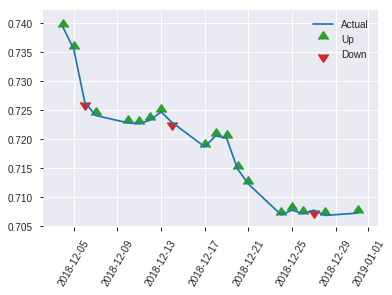


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2501253608780455
RMSE: 0.5001253451666346
LogLoss: 0.694106373923392
Mean Per-Class Error: 0.4293103448275861
AUC: 0.5779556650246305
pr_auc: 0.513813876879732
Gini: 0.15591133004926094
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36458575502235563: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    131  0.9357   (131.0/140.0)
1      1    115  0.0086   (1.0/116.0)
Total  10   246  0.5156   (132.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364586     0.635359  245
max f2                       0.286717     0.810056  251
max f0point5                 0.498839     0.540201  169
max accuracy                 0.640338     0.585938  29
max precision                0.678142     0.714286  6
max recall                   0.286717     1         251
max specificity              0.846342     0.992857  0
max absolute_mcc             0.463254     0.157101  212
max min_per_class_accuracy   0.536225     0.560345  124
max mean_per_class_accuracy  0.498839     0.57069   169

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.757778           0.735632  0.735632           0.333333         0.842368  0.333333                    0.842368            0.00862069      0.00862069                 -26.4368  -26.4368
    2        0.0234375                   0.682798           2.2069    1.47126            1                0.688399  0.666667                    0.765383            0.0258621       0.0344828                  120.69    47.1264
    3        0.03125                     0.673785           1.10345   1.37931            0.5              0.677673  0.625                       0.743456            0.00862069      0.0431034                  10.3448   37.931
    4        0.0429688                   0.665029           0.735632  1.20376            0.333333         0.668909  0.545455                    0.723125            0.00862069      0.0517241                  -26.4368  20.3762
    5        0.0507812                   0.65505            1.10345   1.18833            0.5              0.658785  0.538462                    0.713226            0.00862069      0.0603448                  10.3448   18.8329
    6        0.101562                    0.642268           1.52785   1.35809            0.692308         0.648693  0.615385                    0.68096             0.0775862       0.137931                   52.7851   35.809
    7        0.152344                    0.629704           1.01857   1.24492            0.461538         0.635677  0.564103                    0.665865            0.0517241       0.189655                   1.85676   24.4916
    8        0.203125                    0.616179           0.848806  1.14589            0.384615         0.622547  0.519231                    0.655036            0.0431034       0.232759                   -15.1194  14.5889
    9        0.300781                    0.597276           0.971034  1.08912            0.44             0.605916  0.493506                    0.639088            0.0948276       0.327586                   -2.89655  8.91178
    10       0.402344                    0.569068           1.18833   1.11416            0.538462         0.584113  0.504854                    0.625211            0.12069         0.448276                   18.8329   11.4161
    11       0.5                         0.532283           1.14759   1.12069            0.52             0.547191  0.507812                    0.609972            0.112069        0.560345                   14.7586   12.069
    12       0.601562                    0.508869           1.01857   1.10345            0.461538         0.519817  0.5                         0.594751            0.103448        0.663793                   1.85676   10.3448
    13       0.699219                    0.488551           0.971034  1.08495            0.44             0.499521  0.49162                     0.581451            0.0948276       0.758621                   -2.89655  8.49547
    14       0.800781                    0.476768           1.01857   1.07653            0.461538         0.481971  0.487805                    0.568834            0.103448        0.862069                   1.85676   7.65349
    15       0.898438                    0.432349           0.794483  1.04588            0.36             0.453986  0.473913                    0.556351            0.0775862       0.939655                   -20.5517  4.58771
    16       1                           0.114015           0.594164  1                  0.269231         0.348684  0.453125                    0.535259           

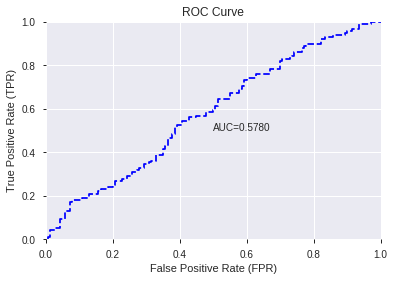

This function is available for GLM models only


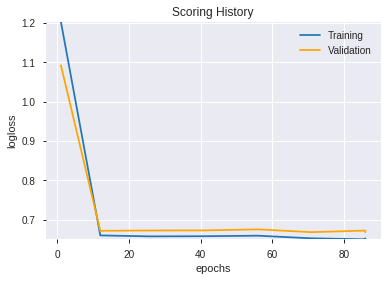

--2019-08-22 16:13:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


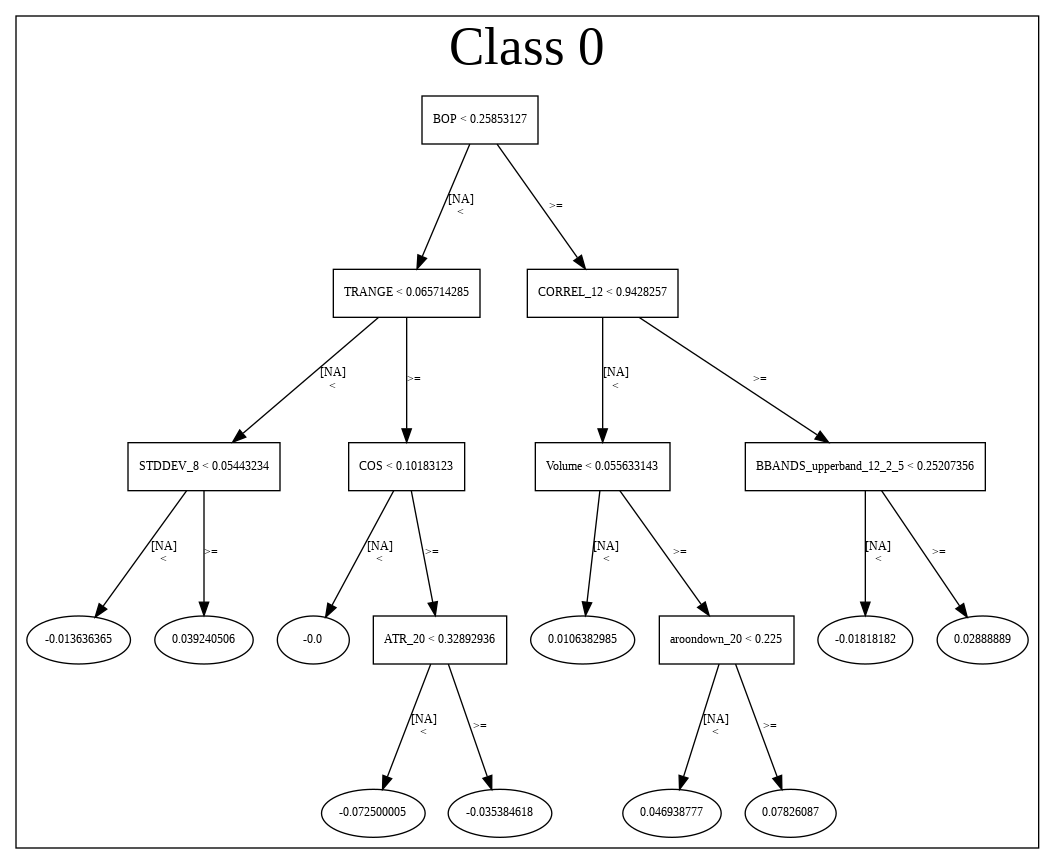

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_160809_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_160809_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'SUB',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'TRANGE']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_161328_model_1  0.576355  0.691838              0.469335  0.499371  0.249372

variable  relative_importance  scaled_importance  percentage
0               BOP             0.354240           1.000000    0.362349
1               SUB             0.187907           0.530452    0.192209
2  CDLDRAGONFLYDOJI             0.156288           0.441191    0.159865
3               DIV             0.132339           0.373585    0.135368
4    CDLRICKSHAWMAN             0.101987           0.287904    0.104322
5            TRANGE             0.023663           0.066798    0.024204
6       CDLBELTHOLD             0.021197           0.059837    0.021682

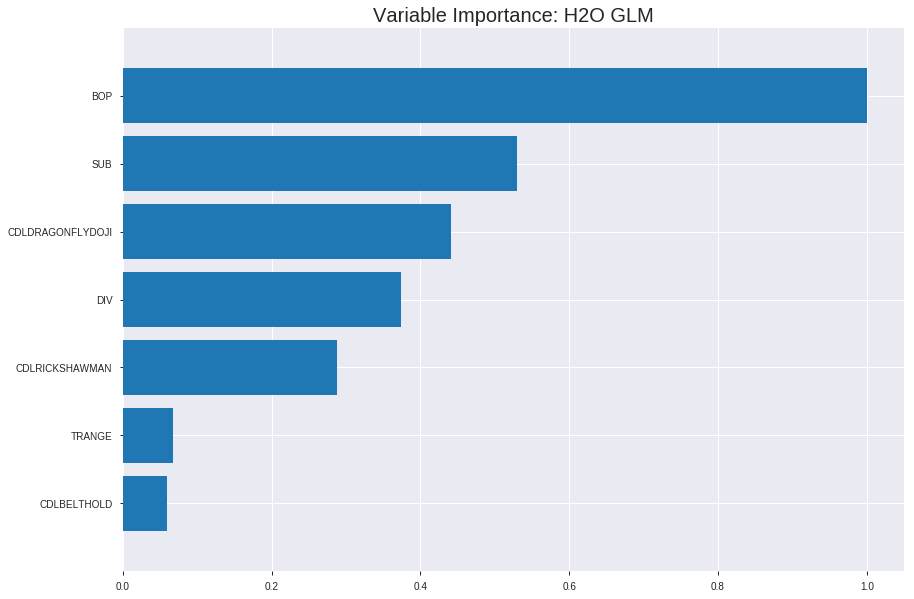

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_161328_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23590701732666583
RMSE: 0.4857026017293564
LogLoss: 0.6631376516831406
Null degrees of freedom: 1786
Residual degrees of freedom: 1779
Null deviance: 2477.1462973227917
Residual deviance: 2370.0539671155448
AIC: 2386.0539671155448
AUC: 0.6288379871472058
pr_auc: 0.6072422728427006
Gini: 0.2576759742944117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33986416052622487: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      138  764   0.847    (764.0/902.0)
1      38   847   0.0429   (38.0/885.0)
Total  176  1611  0.4488   (802.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339864     0.678686  315
max f2                       0.188505     0.833963  375
max f0point5                 0.497305     0.589618  190
max accuracy                 0.532351     0.589815  154
max precision                0.871333     1         0
max recall                   0.145308     1         385
max specificity              0.871333     1         0
max absolute_mcc             0.556956     0.184823  130
max min_per_class_accuracy   0.51098      0.583149  176
max mean_per_class_accuracy  0.497305     0.590401  190

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.768918           1.34614   1.34614            0.666667         0.80806   0.666667                    0.80806             0.0135593       0.0135593                  34.6139   34.6139
    2        0.0201455                   0.732662           1.68267   1.51441            0.833333         0.750731  0.75                        0.779395            0.0169492       0.0305085                  68.2674   51.4407
    3        0.0302182                   0.703125           1.12178   1.38353            0.555556         0.718092  0.685185                    0.758961            0.0112994       0.0418079                  12.1783   38.3532
    4        0.040291                    0.671394           1.34614   1.37418            0.666667         0.689782  0.680556                    0.741666            0.0135593       0.0553672                  34.6139   37.4184
    5        0.0503637                   0.652466           1.23396   1.34614            0.611111         0.660024  0.666667                    0.725338            0.0124294       0.0677966                  23.3961   34.6139
    6        0.100168                    0.618435           1.49739   1.42134            0.741573         0.631843  0.703911                    0.678852            0.0745763       0.142373                   49.7391   42.1343
    7        0.149972                    0.603537           1.22514   1.35619            0.606742         0.611295  0.671642                    0.656417            0.0610169       0.20339                    22.5138   35.6185
    8        0.200336                    0.587323           1.23396   1.32546            0.611111         0.594899  0.656425                    0.640951            0.0621469       0.265537                   23.3961   32.5458
    9        0.299944                    0.559888           1.15707   1.26954            0.573034         0.57343   0.628731                    0.618528            0.115254        0.380791                   15.7075   26.954
    10       0.400112                    0.533282           1.06037   1.21717            0.52514          0.546275  0.602797                    0.60044             0.106215        0.487006                   6.03668   21.7174
    11       0.50028                     0.5107             0.981403  1.16997            0.486034         0.52211   0.579418                    0.584756            0.0983051       0.585311                   -1.85967  16.9967
    12       0.599888                    0.486106           1.03229   1.14711            0.511236         0.498917  0.568097                    0.570503            0.102825        0.688136                   3.22923   14.7107
    13       0.700056                    0.450746           0.868598  1.10726            0.430168         0.469647  0.548361                    0.556072            0.0870056       0.775141                   -13.1402  10.7256
    14       0.799664                    0.405128           0.975573  1.09085            0.483146         0.429372  0.540238                    0.54029             0.0971751       0.872316                   -2.44271  9.08533
    15       0.899832                    0.340485           0.823476  1.06109            0.407821         0.375172  0.525498                    0.521909            0.0824859       0.954802                   -17.6524  6.10893
    16       1                           0.0318031          0.45122   1                  0.223464         0.255697  0.495243                    0.495243          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23814900379033604
RMSE: 0.4880051268074302
LogLoss: 0.6689492005717029
Null degrees of freedom: 509
Residual degrees of freedom: 502
Null deviance: 707.665141278386
Residual deviance: 682.3281845831369
AIC: 698.3281845831369
AUC: 0.6191156263027066
pr_auc: 0.6255293404454709
Gini: 0.2382312526054131
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40563638806085417: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      35   204  0.8536   (204.0/239.0)
1      11   260  0.0406   (11.0/271.0)
Total  46   464  0.4216   (215.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405636     0.707483  354
max f2                       0.354657     0.85389   386
max f0point5                 0.520418     0.63568   222
max accuracy                 0.520418     0.613725  222
max precision                0.651706     1         0
max recall                   0.32755      1         394
max specificity              0.651706     1         0
max absolute_mcc             0.520418     0.220456  222
max min_per_class_accuracy   0.536239     0.598326  193
max mean_per_class_accuracy  0.533563     0.608879  198

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 52.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.645565           1.25461   1.25461            0.666667         0.648588  0.666667                    0.648588            0.0147601       0.0147601                  25.4613   25.4613
    2        0.0215686                   0.642214           1.50554   1.36867            0.8              0.643488  0.727273                    0.64627             0.0147601       0.0295203                  50.5535   36.8668
    3        0.0313725                   0.631298           1.50554   1.41144            0.8              0.637296  0.75                        0.643465            0.0147601       0.0442804                  50.5535   41.1439
    4        0.0411765                   0.629581           1.50554   1.43384            0.8              0.630374  0.761905                    0.640349            0.0147601       0.0590406                  50.5535   43.3843
    5        0.0509804                   0.624529           1.50554   1.44763            0.8              0.626774  0.769231                    0.637738            0.0147601       0.0738007                  50.5535   44.763
    6        0.1                         0.608963           1.12915   1.29151            0.6              0.616402  0.686275                    0.627279            0.0553506       0.129151                   12.9151   29.1513
    7        0.15098                     0.598147           1.23049   1.27091            0.653846         0.603761  0.675325                    0.619338            0.0627306       0.191882                   23.0485   27.0906
    8        0.2                         0.591799           1.20443   1.25461            0.64             0.59538   0.666667                    0.613466            0.0590406       0.250923                   20.4428   25.4613
    9        0.3                         0.575021           0.922509  1.14391            0.490196         0.583211  0.607843                    0.603381            0.0922509       0.343173                   -7.74908  14.3911
    10       0.4                         0.555495           1.18081   1.15314            0.627451         0.565196  0.612745                    0.593835            0.118081        0.461255                   18.0812   15.3137
    11       0.5                         0.537682           1.29151   1.18081            0.686275         0.546349  0.627451                    0.584338            0.129151        0.590406                   29.1513   18.0812
    12       0.6                         0.515973           1.07011   1.16236            0.568627         0.527444  0.617647                    0.574855            0.107011        0.697417                   7.01107   16.2362
    13       0.7                         0.495716           0.774908  1.10701            0.411765         0.507153  0.588235                    0.565184            0.0774908       0.774908                   -22.5092  10.7011
    14       0.8                         0.469378           0.774908  1.0655             0.411765         0.484196  0.566176                    0.55506             0.0774908       0.852399                   -22.5092  6.54982
    15       0.9                         0.420076           0.922509  1.04961            0.490196         0.446503  0.557734                    0.542998            0.0922509       0.944649                   -7.74908  4.96105
    16       1                           0.196563           0.553506  1                  0.294118         0.368669  0.531373                    0.525565          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 16:13:28  0.000 sec   2            8         8             1.38001           1.38261
    2019-08-22 16:13:28  0.006 sec   4            5         8             1.37679           1.38004
    2019-08-22 16:13:28  0.011 sec   6            3.1       8             1.37232           1.37647
    2019-08-22 16:13:28  0.015 sec   8            1.9       8             1.36651           1.37188
    2019-08-22 16:13:28  0.020 sec   10           1.2       8             1.35959           1.36645
    2019-08-22 16:13:28  0.025 sec   12           0.74      8             1.35218           1.36071
    2019-08-22 16:13:28  0.030 sec   14           0.46      8             1.34508           1.35529
    2019-08-22 16:13:28  0.035 sec   16           0.28      8             1.33901           1.35067
    2019-08-22 16:13:28  0.039 sec   18           0.18      8             1.33433           1.34704
    2019-08-22 16:13:28  0.044 sec   20           0.11      8             1.33103           1.34432
    2019-08-22 16:13:28  0.051 sec   22           0.068     8             1.3289            1.34233
    2019-08-22 16:13:28  0.056 sec   24           0.042     8             1.32763           1.34088
    2019-08-22 16:13:28  0.061 sec   26           0.026     8             1.32693           1.33984
    2019-08-22 16:13:28  0.063 sec   27           0.016     8             1.32658           1.33914
    2019-08-22 16:13:28  0.066 sec   28           0.01      8             1.32641           1.33865
    2019-08-22 16:13:28  0.068 sec   29           0.0063    8             1.32633           1.33834
    2019-08-22 16:13:28  0.070 sec   30           0.0039    8             1.3263            1.33815
    2019-08-22 16:13:28  0.072 sec   31           0.0024    8             1.32628           1.33802
    2019-08-22 16:13:28  0.073 sec   32           0.0015    8             1.32628           1.33795
    2019-08-22 16:13:28  0.076 sec   33           0.00093   8             1.32628           1.3379

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6350974930362117)

('auc', 0.5763546798029556)

('logloss', 0.6918381002861003)

('mean_per_class_error', 0.4381773399014778)

('rmse', 0.49937135877966554)

('mse', 0.24937175396944944)

glm prediction progress: |████████████████████████████████████████████████| 100%


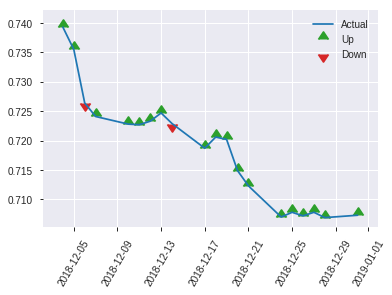


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24937175396944944
RMSE: 0.49937135877966554
LogLoss: 0.6918381002861003
Null degrees of freedom: 255
Residual degrees of freedom: 248
Null deviance: 354.4578805022527
Residual deviance: 354.22110734648334
AIC: 370.22110734648334
AUC: 0.5763546798029556
pr_auc: 0.5131456506439467
Gini: 0.15270935960591125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3990595663924831: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   129  0.9214   (129.0/140.0)
1      2    114  0.0172   (2.0/116.0)
Total  13   243  0.5117   (131.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39906      0.635097  242
max f2                       0.358091     0.811189  250
max f0point5                 0.430468     0.531496  224
max accuracy                 0.609018     0.585938  43
max precision                0.636155     0.666667  11
max recall                   0.358091     1         250
max specificity              0.657166     0.992857  0
max absolute_mcc             0.609018     0.146896  43
max min_per_class_accuracy   0.542705     0.535714  127
max mean_per_class_accuracy  0.530034     0.561823  145

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 53.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.644877           0         0                  0                0.650312  0                           0.650312            0               0                          -100      -100
    2        0.0234375                   0.642726           1.47126   0.735632           0.666667         0.643     0.333333                    0.646656            0.0172414       0.0172414                  47.1264   -26.4368
    3        0.03125                     0.638358           2.2069    1.10345            1                0.640652  0.5                         0.645155            0.0172414       0.0344828                  120.69    10.3448
    4        0.0429688                   0.636273           2.2069    1.40439            1                0.63722   0.636364                    0.642991            0.0258621       0.0603448                  120.69    40.4389
    5        0.0507812                   0.635473           1.10345   1.35809            0.5              0.635861  0.615385                    0.641894            0.00862069      0.0689655                  10.3448   35.809
    6        0.101562                    0.62287            1.18833   1.27321            0.538462         0.628069  0.576923                    0.634982            0.0603448       0.12931                    18.8329   27.321
    7        0.152344                    0.611926           1.52785   1.35809            0.692308         0.616741  0.615385                    0.628902            0.0775862       0.206897                   52.7851   35.809
    8        0.203125                    0.606621           1.01857   1.27321            0.461538         0.608635  0.576923                    0.623835            0.0517241       0.258621                   1.85676   27.321
    9        0.300781                    0.589741           0.971034  1.1751             0.44             0.597848  0.532468                    0.615398            0.0948276       0.353448                   -2.89655  17.5101
    10       0.402344                    0.566262           0.933687  1.11416            0.423077         0.578017  0.504854                    0.605962            0.0948276       0.448276                   -6.6313   11.4161
    11       0.5                         0.542587           0.971034  1.08621            0.44             0.553122  0.492188                    0.595641            0.0948276       0.543103                   -2.89655  8.62069
    12       0.601562                    0.525182           1.18833   1.10345            0.538462         0.533308  0.5                         0.585118            0.12069         0.663793                   18.8329   10.3448
    13       0.699219                    0.507291           0.617931  1.03564            0.28             0.515843  0.469274                    0.575442            0.0603448       0.724138                   -38.2069  3.56386
    14       0.800781                    0.485376           1.18833   1.055              0.538462         0.500534  0.478049                    0.565942            0.12069         0.844828                   18.8329   5.50042
    15       0.898438                    0.420016           0.971034  1.04588            0.44             0.45356   0.473913                    0.553726            0.0948276       0.939655                   -2.89655  4.58771
    16       1                           0.317055           0.594164  1                  0.269231         0.384909  0.453125                    0.536581            0.0

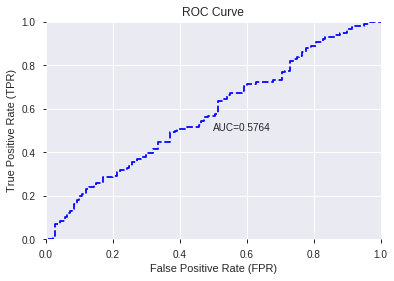

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


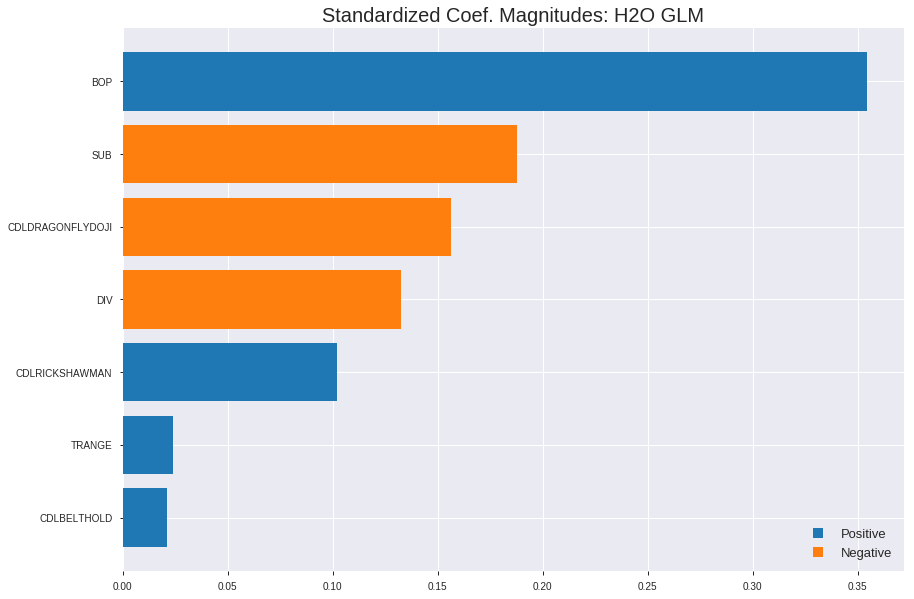

'log_likelihood'
--2019-08-22 16:13:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


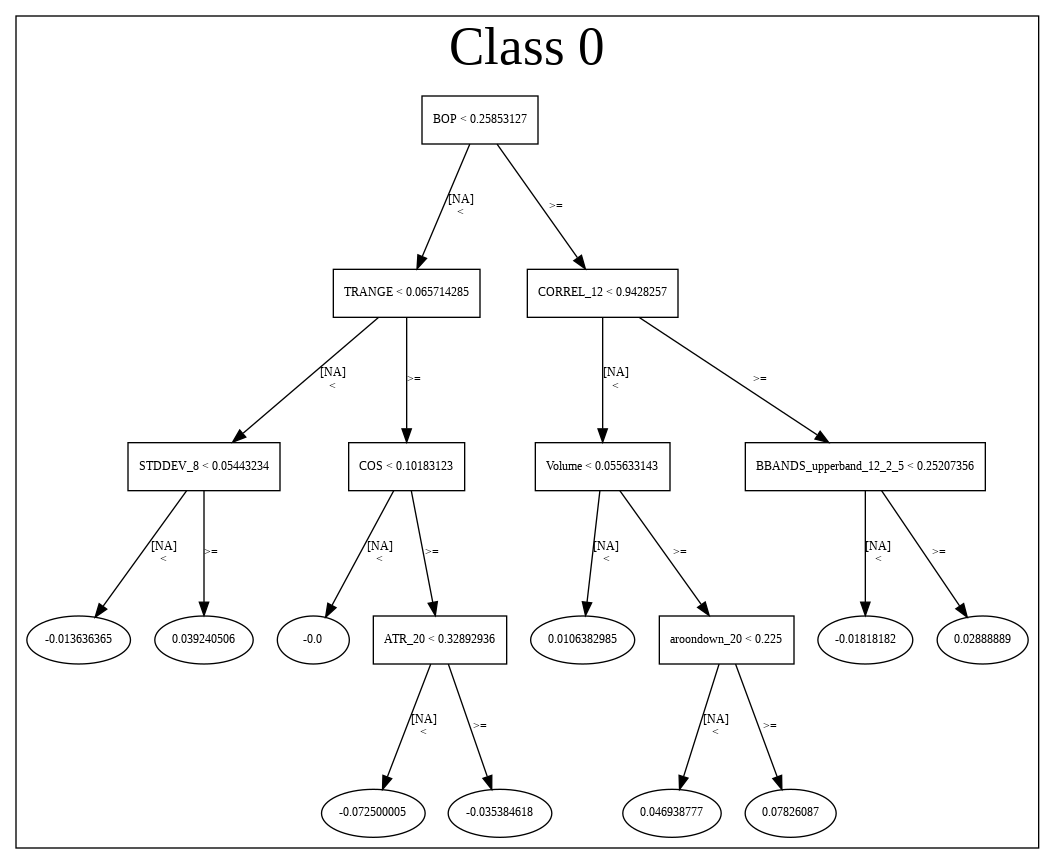

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_161328_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_161328_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'CDLDRAGONFLYDOJI',
 'DIV',
 'CDLRICKSHAWMAN',
 'TRANGE',
 'CDLBELTHOLD']

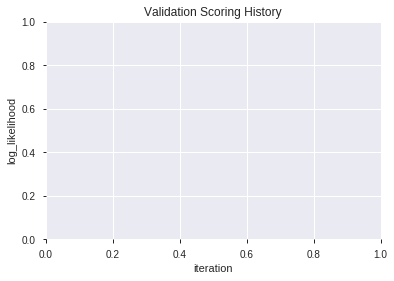

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_161344_model_2  0.551139  0.698023              0.467857  0.502410  0.252416
1               XGBoost_2_AutoML_20190822_161344  0.541441  0.708589              0.473645  0.507356  0.257410
2  XGBoost_grid_1_AutoML_20190822_161344_model_6  0.534883  0.710840              0.478571  0.508477  0.258549
3  XGBoost_grid_1_AutoML_20190822_161344_model_3  0.534606  0.705343              0.471429  0.505859  0.255893
4  XGBoost_grid_1_AutoML_20190822_161344_model_4  0.526232  0.706559              0.459360  0.506485  0.256527
5  XGBoost_grid_1_AutoML_20190822_161344_model_1  0.518996  0.704432              0.489286  0.505543  0.255574
6               XGBoost_3_AutoML_20190822_161344  0.518966  0.705422              0.485714  0.506070  0.256107
7               XGBoost_1_AutoML_20190822_161344  0.512623  0.716869              0.485714  0.511259  0.261386
8  XGBoost_grid_1_AutoML_20190822_161344_model_7  0.494828  0.730259              0.486453  0.517104  0.267396
9  XGBoost_grid_1_AutoML_20190822_161344_model_5  0.488239  0.770018              0.489286  0.532925  0.284009

variable  relative_importance  scaled_importance  percentage
0               BOP          1084.385254           1.000000    0.346046
1               SUB           650.381226           0.599770    0.207548
2            TRANGE           544.518005           0.502144    0.173765
3               DIV           520.226379           0.479743    0.166013
4  CDLDRAGONFLYDOJI           144.853195           0.133581    0.046225
5       CDLBELTHOLD           106.458298           0.098174    0.033973
6    CDLRICKSHAWMAN            82.826920           0.076381    0.026431

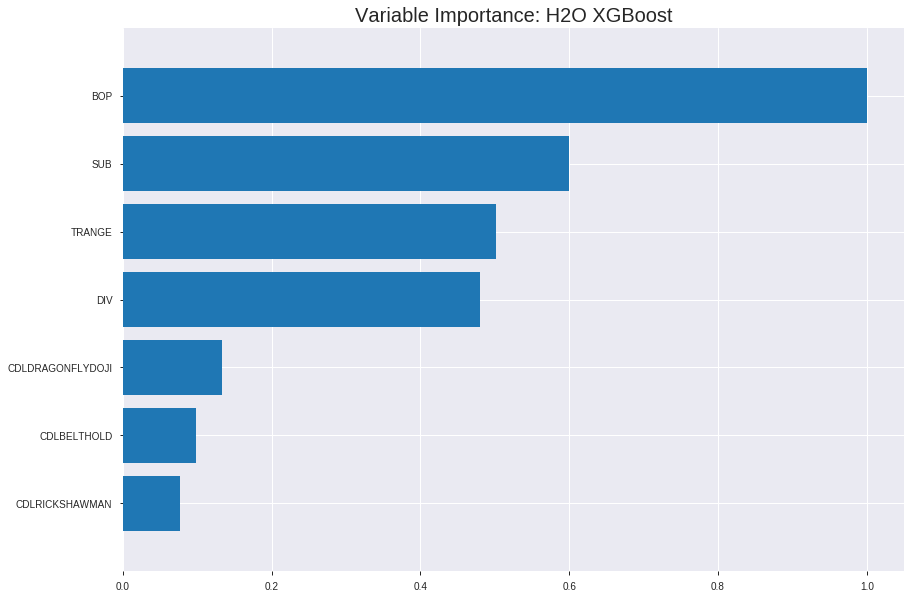

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_161344_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21582229449249926
RMSE: 0.46456678152069725
LogLoss: 0.6219093809937184
Mean Per-Class Error: 0.3337529908426973
AUC: 0.7379714883435429
pr_auc: 0.7327059179699202
Gini: 0.47594297668708574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42066397666931155: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      335  567   0.6286   (567.0/902.0)
1      84   801   0.0949   (84.0/885.0)
Total  419  1368  0.3643   (651.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420664     0.711052  272
max f2                       0.30863      0.84438   352
max f0point5                 0.534293     0.667437  151
max accuracy                 0.5011       0.665921  187
max precision                0.739693     1         0
max recall                   0.209459     1         399
max specificity              0.739693     1         0
max absolute_mcc             0.448519     0.33732   246
max min_per_class_accuracy   0.497767     0.659887  192
max mean_per_class_accuracy  0.490738     0.666247  201

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.708577           2.01921   2.01921            1                0.719015  1                           0.719015            0.020339        0.020339                   101.921   101.921
    2        0.0201455                   0.691848           1.68267   1.85094            0.833333         0.699484  0.916667                    0.70925             0.0169492       0.0372881                  68.2674   85.0942
    3        0.0307778                   0.687174           1.80666   1.83564            0.894737         0.68926   0.909091                    0.702344            0.019209        0.0564972                  80.6661   83.5645
    4        0.040291                    0.680577           1.90043   1.85094            0.941176         0.682982  0.916667                    0.697773            0.0180791       0.0745763                  90.0432   85.0942
    5        0.0503637                   0.670892           1.79485   1.83972            0.888889         0.674725  0.911111                    0.693163            0.0180791       0.0926554                  79.4852   83.9724
    6        0.100168                    0.638936           1.79233   1.81616            0.88764          0.653288  0.899441                    0.673337            0.0892655       0.181921                   79.2332   81.616
    7        0.149972                    0.615132           1.36126   1.66509            0.674157         0.627205  0.824627                    0.658017            0.0677966       0.249718                   36.1265   66.5094
    8        0.200336                    0.591088           1.54806   1.63567            0.766667         0.602329  0.810056                    0.644017            0.0779661       0.327684                   54.806    63.5672
    9        0.299944                    0.552378           1.20245   1.4918             0.595506         0.569972  0.738806                    0.619428            0.119774        0.447458                   20.245    49.1804
    10       0.400112                    0.521821           1.07165   1.38662            0.530726         0.536678  0.686713                    0.598711            0.107345        0.554802                   7.16473   38.6618
    11       0.50028                     0.497227           1.06037   1.32129            0.52514          0.508945  0.654362                    0.580738            0.106215        0.661017                   6.03668   32.1295
    12       0.599888                    0.475906           0.964229  1.26201            0.477528         0.486696  0.625                       0.565123            0.0960452       0.757062                   -3.5771   26.2006
    13       0.700056                    0.445613           0.958842  1.21863            0.47486          0.462098  0.603517                    0.550381            0.0960452       0.853107                   -4.11577  21.8627
    14       0.799664                    0.408717           0.760039  1.1615             0.376404         0.425817  0.575227                    0.534865            0.0757062       0.928814                   -23.9961  16.1504
    15       0.899832                    0.364229           0.518903  1.08997            0.256983         0.390343  0.539801                    0.518777            0.0519774       0.980791                   -48.1097  8.9971
    16       1                           0.209459           0.191768  1                  0.0949721        0.280991  0.495243                    0.494959           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24231509626453634
RMSE: 0.49225511298973457
LogLoss: 0.6774489431040621
Mean Per-Class Error: 0.42451635813429256
AUC: 0.5866077907641002
pr_auc: 0.6128052551830927
Gini: 0.17321558152820038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37910282611846924: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   227  0.9498   (227.0/239.0)
1      2    269  0.0074   (2.0/271.0)
Total  14   496  0.449    (229.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379103     0.701434  385
max f2                       0.364909     0.852811  388
max f0point5                 0.47745      0.606308  302
max accuracy                 0.47745      0.57451   302
max precision                0.704647     1         0
max recall                   0.282565     1         399
max specificity              0.704647     1         0
max absolute_mcc             0.573013     0.176592  107
max min_per_class_accuracy   0.529137     0.560886  205
max mean_per_class_accuracy  0.573013     0.575484  107

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 52.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0137255                   0.690698           1.34423   1.34423            0.714286         0.696297  0.714286                    0.696297            0.0184502       0.0184502                  34.4228   34.4228
    2        0.0215686                   0.679243           1.41144   1.36867            0.75             0.683128  0.727273                    0.691508            0.0110701       0.0295203                  41.1439   36.8668
    3        0.0313725                   0.661622           1.50554   1.41144            0.8              0.669356  0.75                        0.684585            0.0147601       0.0442804                  50.5535   41.1439
    4        0.0411765                   0.652474           0.752768  1.25461            0.4              0.657025  0.666667                    0.678024            0.00738007      0.0516605                  -24.7232  25.4613
    5        0.0509804                   0.645956           1.50554   1.30287            0.8              0.64958   0.692308                    0.672554            0.0147601       0.0664207                  50.5535   30.2867
    6        0.1                         0.617867           1.43026   1.36531            0.76             0.632341  0.72549                     0.652841            0.0701107       0.136531                   43.0258   36.5314
    7        0.15098                     0.599251           1.1581    1.29535            0.615385         0.607865  0.688312                    0.637655            0.0590406       0.195572                   15.8104   29.5347
    8        0.2                         0.583697           1.2797    1.29151            0.68             0.591223  0.686275                    0.626274            0.0627306       0.258303                   27.9705   29.1513
    9        0.3                         0.560569           0.885609  1.15621            0.470588         0.57108   0.614379                    0.607876            0.0885609       0.346863                   -11.4391  15.6212
    10       0.4                         0.542038           1.03321   1.12546            0.54902          0.552212  0.598039                    0.59396             0.103321        0.450185                   3.32103   12.5461
    11       0.5                         0.528952           1.10701   1.12177            0.588235         0.53502   0.596078                    0.582172            0.110701        0.560886                   10.7011   12.1771
    12       0.6                         0.512981           0.774908  1.06396            0.411765         0.521723  0.565359                    0.572097            0.0774908       0.638376                   -22.5092  6.39606
    13       0.701961                    0.493868           1.01334   1.05661            0.538462         0.503505  0.561453                    0.562134            0.103321        0.741697                   1.33409   5.66081
    14       0.8                         0.469995           1.01624   1.05166            0.54             0.482456  0.558824                    0.55237             0.099631        0.841328                   1.62362   5.16605
    15       0.9                         0.424433           0.811808  1.02501            0.431373         0.446157  0.544662                    0.540568            0.0811808       0.922509                   -18.8192  2.50103
    16       1                           0.282565           0.774908  1                  0.411765         0.383396  0.531373                    0.524851         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:13:50  0.815 sec   0                  0.5              0.693147            0.5             0                  1                0.504757                         0.5                0.693147              0.5               0                    1                  0.468627
    2019-08-22 16:13:50  0.885 sec   5                  0.49344          0.680096            0.693701        0.663643           1.81729          0.43089                          0.496857           0.686874              0.603954          0.616808             1.04551            0.429412
    2019-08-22 16:13:50  0.945 sec   10                 0.487645         0.668617            0.696356        0.67258            1.74998          0.392278                         0.494327           0.681828              0.616437          0.632516             1.34423            0.433333
    2019-08-22 16:13:50  1.015 sec   15                 0.482791         0.658987            0.704954        0.690642           1.79485          0.412983                         0.493437           0.680037              0.60478           0.615745             1.25461            0.44902
    2019-08-22 16:13:50  1.088 sec   20                 0.478743         0.65089             0.709992        0.698534           1.90703          0.404029                         0.492737           0.67861               0.603059          0.61896              1.41144            0.45098
    2019-08-22 16:13:50  1.156 sec   25                 0.475415         0.644201            0.714157        0.701776           1.90703          0.390039                         0.492027           0.677158              0.604294          0.621519             1.41144            0.443137
    2019-08-22 16:13:50  1.221 sec   30                 0.472863         0.638971            0.719138        0.713286           1.90703          0.38948                          0.491643           0.676353              0.603437          0.623435             0.940959           0.452941
    2019-08-22 16:13:50  1.286 sec   35                 0.470776         0.634628            0.722146        0.717298           1.90703          0.380526                         0.491481           0.67599               0.600673          0.620035             1.34423            0.437255
    2019-08-22 16:13:50  1.358 sec   40                 0.46844          0.629847            0.728848        0.724291           1.90703          0.378847                         0.49206            0.677118              0.592537          0.614206             1.34423            0.443137
    2019-08-22 16:13:50  1.436 sec   45                 0.466377         0.625617            0.732873        0.728326           1.90703          0.368215                         0.492211           0.677381              0.588507          0.612338             1.34423            0.44902
    2019-08-22 16:13:50  1.512 sec   50                 0.464567         0.621909            0.737971        0.732706           2.01921          0.364298                         0.492255           0.677449              0.586608          0.612805             1.34423            0.44902

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  ------------
BOP               1084.39                1                    0.346046
SUB               650.381                0.59977              0.207548
TRANGE            544.518                0.502144             0.173765
DIV               520.226                0.479743             0.166013
CDLDRAGONFLYDOJI  144.853                0.133581             0.0462251
CDLBELTHOLD       106.458                0.0981739            0.0339726
CDLRICKSHAWMAN    82.8269                0.0763815            0.0264315

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.578125)

('F1', 0.6391184573002755)

('auc', 0.5511391625615764)

('logloss', 0.6980228440465086)

('mean_per_class_error', 0.4496305418719212)

('rmse', 0.502409843819076)

('mse', 0.2524156511663084)

xgboost prediction progress: |████████████████████████████████████████████| 100%


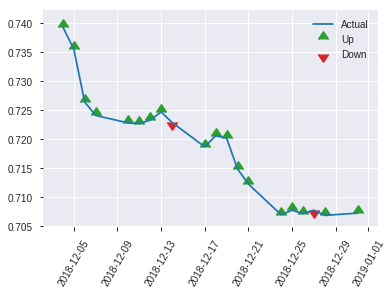


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2524156511663084
RMSE: 0.502409843819076
LogLoss: 0.6980228440465086
Mean Per-Class Error: 0.4496305418719212
AUC: 0.5511391625615764
pr_auc: 0.5006185475882351
Gini: 0.10227832512315271
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4078155755996704: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    131  0.9357   (131.0/140.0)
1      0    116  0        (0.0/116.0)
Total  9    247  0.5117   (131.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407816     0.639118  237
max f2                       0.407816     0.815752  237
max f0point5                 0.417786     0.527778  231
max accuracy                 0.665062     0.578125  13
max precision                0.704569     1         0
max recall                   0.407816     1         237
max specificity              0.704569     1         0
max absolute_mcc             0.407816     0.173755  237
max min_per_class_accuracy   0.537862     0.528571  123
max mean_per_class_accuracy  0.528899     0.550369  141

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 53.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.687036           1.47126   1.47126            0.666667         0.69484   0.666667                    0.69484             0.0172414       0.0172414                  47.1264   47.1264
    2        0.0234375                   0.676833           0.735632  1.10345            0.333333         0.682636  0.5                         0.688738            0.00862069      0.0258621                  -26.4368  10.3448
    3        0.03125                     0.673557           2.2069    1.37931            1                0.674547  0.625                       0.68519             0.0172414       0.0431034                  120.69    37.931
    4        0.0429688                   0.671566           2.2069    1.60502            1                0.673281  0.727273                    0.681942            0.0258621       0.0689655                  120.69    60.5016
    5        0.0507812                   0.665144           2.2069    1.69761            1                0.66541   0.769231                    0.679399            0.0172414       0.0862069                  120.69    69.7613
    6        0.101562                    0.640383           1.18833   1.44297            0.538462         0.650327  0.653846                    0.664863            0.0603448       0.146552                   18.8329   44.2971
    7        0.152344                    0.620644           0.339523  1.07515            0.153846         0.630661  0.487179                    0.653462            0.0172414       0.163793                   -66.0477  7.51547
    8        0.203125                    0.59802            0.848806  1.01857            0.384615         0.605575  0.461538                    0.641491            0.0431034       0.206897                   -15.1194  1.85676
    9        0.300781                    0.572119           1.14759   1.06046            0.52             0.585596  0.480519                    0.623343            0.112069        0.318966                   14.7586   6.04568
    10       0.40625                     0.55633            1.14432   1.08223            0.518519         0.564033  0.490385                    0.607945            0.12069         0.439655                   14.4317   8.22281
    11       0.5                         0.537828           1.01149   1.06897            0.458333         0.54713   0.484375                    0.596542            0.0948276       0.534483                   1.14943   6.89655
    12       0.601562                    0.523055           1.01857   1.06046            0.461538         0.531216  0.480519                    0.585513            0.103448        0.637931                   1.85676   6.04568
    13       0.699219                    0.501751           1.05931   1.0603             0.48             0.509817  0.480447                    0.574941            0.103448        0.741379                   5.93103   6.02967
    14       0.800781                    0.477845           0.848806  1.03347            0.384615         0.491481  0.468293                    0.564356            0.0862069       0.827586                   -15.1194  3.34735
    15       0.898438                    0.450392           0.971034  1.02669            0.44             0.465514  0.465217                    0.553612            0.0948276       0.922414                   -2.89655  2.66867
    16       1                           0.291158           0.763926  1                  0.346154         0.403749  0.453125                    0.538392          

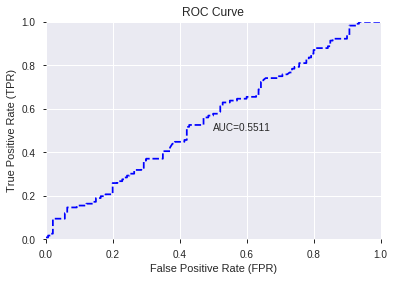

This function is available for GLM models only


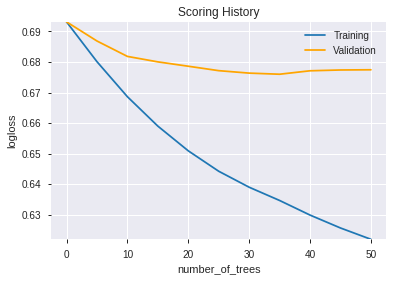

--2019-08-22 16:14:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

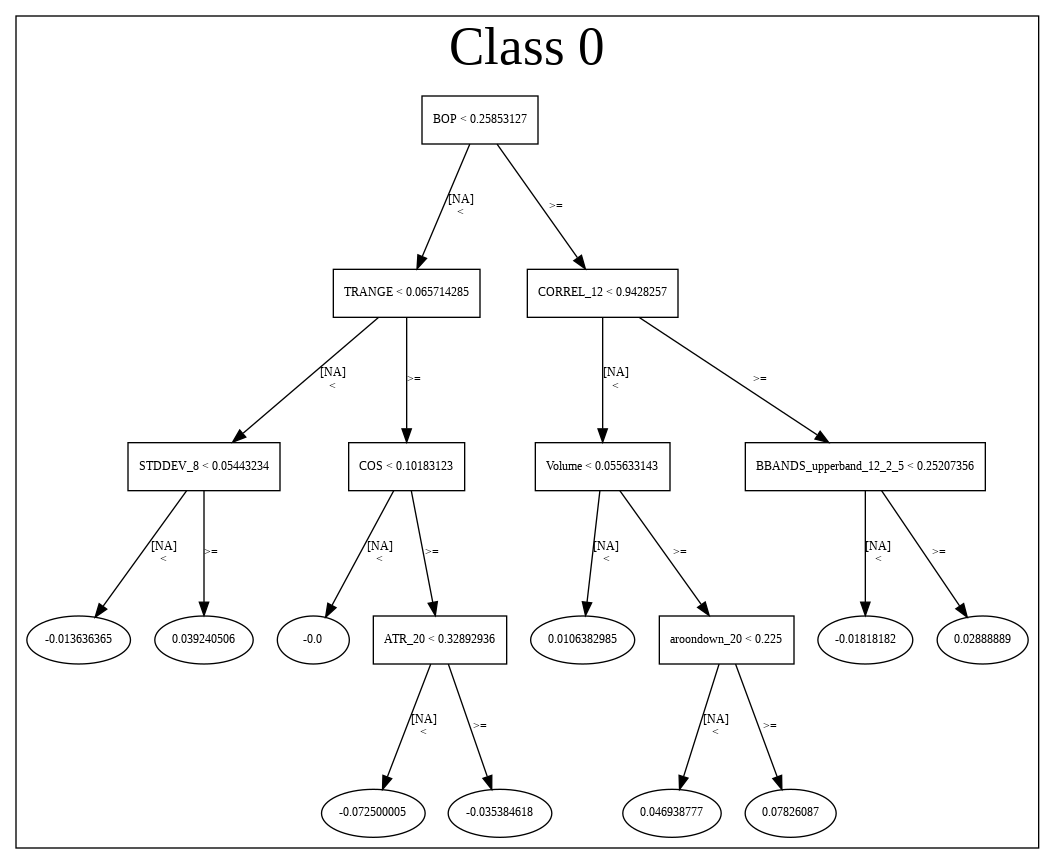

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_161344_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_161344_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'TRANGE',
 'DIV',
 'CDLDRAGONFLYDOJI',
 'CDLBELTHOLD',
 'CDLRICKSHAWMAN']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

83

['MA_14_2',
 'MAVP_14_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_upperband_14_4_5',
 'BBANDS_upperband_14_5_2',
 'MA_14_6',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_middleband_24_6_4',
 'BBANDS_lowerband_30_6_3',
 'BBANDS_upperband_30_6_4',
 'BBANDS_upperband_30_7_3',
 'BBANDS_upperband_30_7_4',
 'BBANDS_lowerband_30_7_5',
 'BOP',
 'aroonup_8',
 'CMO_8',
 'DX_8',
 'MACDFIX_8',
 'MACDFIX_signal_8',
 'MACDFIX_hist_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'PLUS_DM_8',
 'ROCP_8',
 'ROCR_8',
 'aroondown_12',
 'MACDFIX_12',
 'PLUS_DM_12',
 'WILLR_12',
 'ADX_14',
 'AROONOSC_14',
 'CCI_14',
 'DX_14',
 'MACDFIX_signal_14',
 'MINUS_DI_14',
 'MINUS_DM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'RSI_14',
 'aroonup_20',
 'CCI_20',
 'MACDFIX_hist_20',
 'MOM_20',
 'PLUS_DI_20',
 'ROC_20',
 'ROCR_20',
 'RSI_20',
 'ADX_24',
 'CMO_24',
 'MACDFIX_24',
 'MINUS_DI_24',
 'ROC_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'MACD',
 'MACD_hist',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCH

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_161559_model_7  0.555542  0.696589              0.441010  0.499181  0.249182
1  DeepLearning_grid_1_AutoML_20190822_161559_model_9  0.550800  0.680721              0.453695  0.494114  0.244149
2               DeepLearning_1_AutoML_20190822_161559  0.545505  0.823115              0.489286  0.540437  0.292072
3  DeepLearning_grid_1_AutoML_20190822_161559_model_5  0.523553  0.700214              0.496429  0.503304  0.253315
4  DeepLearning_grid_1_AutoML_20190822_161559_model_2  0.522845  0.991184              0.476478  0.579227  0.335504
5  DeepLearning_grid_1_AutoML_20190822_161559_model_8  0.520259  0.690998              0.451601  0.498409  0.248411
6  DeepLearning_grid_1_AutoML_20190822_161559_model_6  0.518411  0.710682              0.456527  0.508221  0.258288
7  DeepLearning_grid_1_AutoML_20190822_161559_model_4  0.508621  1.052804              0.489286  0.604415  0.365318
8  DeepLearning_grid_1_AutoML_20190822_161559_model_3  0.506404  1.105730              0.496429  0.612804  0.375528
9  DeepLearning_grid_1_AutoML_20190822_161559_model_1  0.499076  2.115169              0.496429  0.689089  0.474844

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.013577
1            CDLRICKSHAWMAN             0.968878           0.968878    0.013155
2                 CDLTAKURI             0.961147           0.961147    0.013050
3               AROONOSC_14             0.954296           0.954296    0.012957
4                    ULTOSC             0.951958           0.951958    0.012925
..                      ...                  ...                ...         ...
78  BBANDS_upperband_14_4_5             0.842452           0.842452    0.011438
79        LINEARREG_ANGLE_8             0.840312           0.840312    0.011409
80                   RSI_14             0.835899           0.835899    0.011349
81  BBANDS_upperband_30_6_4             0.820436           0.820436    0.011139
82                MAVP_14_3             0.818582           0.818582    0.011114

[83 rows x 4 columns]

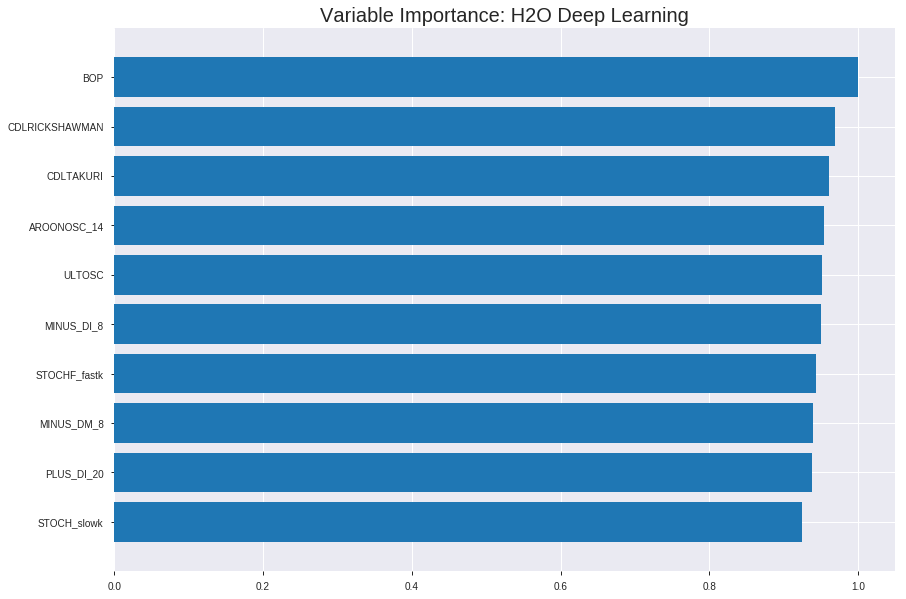

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_161559_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21330413985950494
RMSE: 0.46184861140800776
LogLoss: 0.6082444009955675
Mean Per-Class Error: 0.3512145013591892
AUC: 0.7159808084983778
pr_auc: 0.7038561556508879
Gini: 0.4319616169967555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2062823756582508: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      254  648   0.7184   (648.0/902.0)
1      38   847   0.0429   (38.0/885.0)
Total  292  1495  0.3839   (686.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.206282     0.711765  321
max f2                       0.10523      0.847556  357
max f0point5                 0.463798     0.642872  208
max accuracy                 0.463798     0.648013  208
max precision                0.997239     1         0
max recall                   0.0321303    1         384
max specificity              0.997239     1         0
max absolute_mcc             0.343228     0.324031  265
max min_per_class_accuracy   0.492492     0.640798  193
max mean_per_class_accuracy  0.449418     0.648785  216

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 46.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.954231           1.90703   1.90703            0.944444         0.978609   0.944444                    0.978609            0.019209        0.019209                   90.7031   90.7031
    2        0.0201455                   0.920521           1.90703   1.90703            0.944444         0.943451   0.944444                    0.96103             0.019209        0.0384181                  90.7031   90.7031
    3        0.0302182                   0.896582           2.01921   1.94442            1                0.907125   0.962963                    0.943062            0.020339        0.0587571                  101.921   94.4424
    4        0.040291                    0.876504           1.90703   1.93508            0.944444         0.885934   0.958333                    0.92878             0.019209        0.0779661                  90.7031   93.5075
    5        0.0503637                   0.849007           1.90703   1.92947            0.944444         0.863519   0.955556                    0.915728            0.019209        0.0971751                  90.7031   92.9466
    6        0.100168                    0.751256           1.36126   1.64695            0.674157         0.79714    0.815642                    0.856765            0.0677966       0.164972                   36.1265   64.6953
    7        0.149972                    0.69368            1.42933   1.57468            0.707865         0.719593   0.779851                    0.811212            0.0711864       0.236158                   42.9328   57.4682
    8        0.200336                    0.640898           1.34614   1.51723            0.666667         0.666421   0.751397                    0.774812            0.0677966       0.303955                   34.6139   51.7227
    9        0.299944                    0.577689           1.15707   1.39762            0.573034         0.609553   0.692164                    0.719931            0.115254        0.419209                   15.7075   39.7624
    10       0.400112                    0.530114           1.13933   1.33296            0.564246         0.553171   0.66014                     0.678183            0.114124        0.533333                   13.933    33.296
    11       0.50028                     0.492142           1.11677   1.28967            0.553073         0.513698   0.638702                    0.645249            0.111864        0.645198                   11.6769   28.9674
    12       0.599888                    0.433304           1.0096    1.24317            0.5              0.464863   0.615672                    0.615297            0.100565        0.745763                   0.960452  24.317
    13       0.700056                    0.359315           0.981403  1.20571            0.486034         0.397774   0.597122                    0.584172            0.0983051       0.844068                   -1.85967  20.5715
    14       0.799664                    0.256612           0.85079   1.1615             0.421348         0.31194    0.575227                    0.550262            0.0847458       0.928814                   -14.921   16.1504
    15       0.899832                    0.113242           0.541464  1.09248            0.268156         0.189036   0.541045                    0.510051            0.0542373       0.983051                   -45.8536  9.24825
    16       1                           0.000149127        0.169207  1                  0.0837989        0.0470021  0.495243                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2504327042918425
RMSE: 0.5004325172206963
LogLoss: 0.6965540139295424
Mean Per-Class Error: 0.42340471521870027
AUC: 0.5602911886859454
pr_auc: 0.5617106844597429
Gini: 0.12058237737189081
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3551612774750552: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   202  0.8452   (202.0/239.0)
1      19   252  0.0701   (19.0/271.0)
Total  56   454  0.4333   (221.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355161     0.695172  344
max f2                       0.107991     0.850063  399
max f0point5                 0.445995     0.616753  269
max accuracy                 0.445995     0.590196  269
max precision                0.761778     1         0
max recall                   0.107991     1         399
max specificity              0.761778     1         0
max absolute_mcc             0.445995     0.170548  269
max min_per_class_accuracy   0.49924      0.535565  187
max mean_per_class_accuracy  0.445995     0.576595  269

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 47.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.70122            1.25461   1.25461            0.666667         0.72602   0.666667                    0.72602             0.0147601       0.0147601                  25.4613    25.4613
    2        0.0215686                   0.668659           1.12915   1.19758            0.6              0.679656  0.636364                    0.704946            0.0110701       0.0258303                  12.9151    19.7585
    3        0.0313725                   0.638174           0.752768  1.05858            0.4              0.650579  0.5625                      0.687956            0.00738007      0.0332103                  -24.7232   5.85793
    4        0.0411765                   0.622453           0.752768  0.985767           0.4              0.628298  0.52381                     0.673752            0.00738007      0.0405904                  -24.7232   -1.4233
    5        0.0509804                   0.6174             1.50554   1.08572            0.8              0.620426  0.576923                    0.663497            0.0147601       0.0553506                  50.5535    8.57224
    6        0.1                         0.579211           0.978598  1.03321            0.52             0.5968    0.54902                     0.630803            0.0479705       0.103321                   -2.14022   3.32103
    7        0.15098                     0.561878           1.01334   1.0265             0.538462         0.570935  0.545455                    0.610588            0.0516605       0.154982                   1.33409    2.65012
    8        0.2                         0.545016           0.978598  1.01476            0.52             0.553012  0.539216                    0.596476            0.0479705       0.202952                   -2.14022   1.47601
    9        0.3                         0.525815           1.10701   1.04551            0.588235         0.535145  0.555556                    0.576032            0.110701        0.313653                   10.7011    4.55105
    10       0.4                         0.514281           0.99631   1.03321            0.529412         0.519809  0.54902                     0.561977            0.099631        0.413284                   -0.369004  3.32103
    11       0.5                         0.499376           1.21771   1.07011            0.647059         0.506744  0.568627                    0.55093             0.121771        0.535055                   21.7712    7.01107
    12       0.6                         0.479422           1.14391   1.08241            0.607843         0.490952  0.575163                    0.540934            0.114391        0.649446                   14.3911    8.24108
    13       0.7                         0.450414           1.18081   1.09647            0.627451         0.467877  0.582633                    0.530497            0.118081        0.767528                   18.0812    9.64681
    14       0.8                         0.416853           0.922509  1.07472            0.490196         0.436299  0.571078                    0.518722            0.0922509       0.859779                   -7.74908   7.47232
    15       0.9                         0.348469           0.701107  1.03321            0.372549         0.386748  0.54902                     0.504059            0.0701107       0.929889                   -29.8893   3.32103
    16       1                           0.107991           0.701107  1                  0.372549         0.256422  0.531373                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:21:13  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:21:18  5.842 sec         207 obs/sec       0.545607  1             975        0.624396         1.67747             -0.559623      0.531523        0.530555           1.45832          0.504757                         0.571425           1.05627               -0.311267        0.546975          0.571216             1.25461            0.468627
    2019-08-22 16:21:29  17.127 sec        389 obs/sec       3.23559   6             5782       0.508358         0.725992            -0.0338057     0.682686        0.670144           1.79485          0.409065                         0.511393           0.733412              -0.0502249       0.617996          0.626592             1.56827            0.454902
    2019-08-22 16:21:41  28.631 sec        456 obs/sec       6.45831   12            11541      0.461849         0.608244            0.146706       0.715981        0.703856           1.90703          0.383884                         0.500433           0.696554              -0.00569017      0.560291          0.561711             1.25461            0.433333
    2019-08-22 16:21:52  39.766 sec        491 obs/sec       9.71013   18            17352      0.469544         0.631049            0.118032       0.745963        0.728227           2.01921          0.324566                         0.520052           0.782036              -0.0860938       0.606795          0.612406             0.940959           0.452941
    2019-08-22 16:22:03  50.453 sec        514 obs/sec       12.9384   24            23121      0.434268         0.549037            0.245578       0.787441        0.77139            2.01921          0.31953                          0.508458           0.718492              -0.038204        0.542883          0.555216             0.627306           0.445098
    2019-08-22 16:22:15  1 min  2.423 sec  534 obs/sec       16.6984   31            29840      0.462826         0.621606            0.143093       0.834447        0.78972            2.01921          0.268047                         0.543952           0.855483              -0.188211        0.562746          0.568482             0.627306           0.462745
    2019-08-22 16:22:27  1 min 14.335 sec  547 obs/sec       20.4415   38            36529      0.380925         0.433674            0.419533       0.873134        0.852238           2.01921          0.232792                         0.541007           0.870989              -0.175383        0.549885          0.558379             0.627306           0.433333
    2019-08-22 16:22:28  1 min 15.432 sec  547 obs/sec       20.4415   38            36529      0.461849         0.608244            0.146706       0.715981        0.703856           1.90703          0.383884                         0.500433           0.696554              -0.00569017      0.560291          0.561711             1.25461            0.433333

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.013577377958517036
CDLRICKSHAWMAN           0.9688779711723328     0.9688779711723328   0.013154822410287936
CDLTAKURI                0.9611474275588989     0.9611474275588989   0.013049861897823546
AROONOSC_14              0.9542958736419678     0.9542958736419678   0.012956835760690212
ULTOSC                   0.951958417892456      0.951958417892456    0.012925099240517783
---                      ---                    ---                  ---
BBANDS_upperband_14_4_5  0.8424524664878845     0.8424524664878845   0.011438295549590916
LINEARREG_ANGLE_8        0.8403120040893555     0.8403120040893555   0.011409233682600094
RSI_14                   0.8358990550041199     0.8358990550041199   0.011349317404958158
BBANDS_upperband_30_6_4  0.8204355239868164     0.8204355239868164   0.011139363199762976
MAVP_14_3                0.8185822367668152     0.8185822367668152   0.01111420041871133


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.55859375)

('F1', 0.6322188449848024)

('auc', 0.5555418719211823)

('logloss', 0.6965887173174046)

('mean_per_class_error', 0.43017241379310345)

('rmse', 0.49918135593999796)

('mse', 0.24918202611809492)

deeplearning prediction progress: |███████████████████████████████████████| 100%


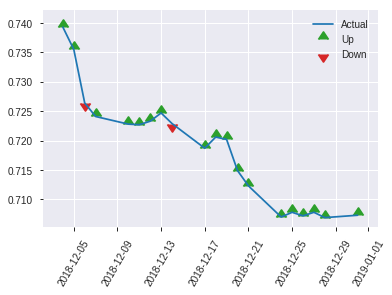


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24918202611809492
RMSE: 0.49918135593999796
LogLoss: 0.6965887173174046
Mean Per-Class Error: 0.43017241379310345
AUC: 0.5555418719211823
pr_auc: 0.4739186910043561
Gini: 0.11108374384236464
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39630409466987887: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      31   109  0.7786   (109.0/140.0)
1      12   104  0.1034   (12.0/116.0)
Total  43   213  0.4727   (121.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396304     0.632219  212
max f2                       0.0519902    0.805556  255
max f0point5                 0.472188     0.537634  156
max accuracy                 0.500052     0.558594  104
max precision                0.658724     0.666667  2
max recall                   0.0519902    1         255
max specificity              0.728094     0.992857  0
max absolute_mcc             0.396304     0.157101  212
max min_per_class_accuracy   0.490836     0.542857  126
max mean_per_class_accuracy  0.472188     0.569828  156

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 46.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.649875           1.47126   1.47126            0.666667         0.697575  0.666667                    0.697575            0.0172414       0.0172414                  47.1264   47.1264
    2        0.0234375                   0.611631           0.735632  1.10345            0.333333         0.626215  0.5                         0.661895            0.00862069      0.0258621                  -26.4368  10.3448
    3        0.03125                     0.602417           0         0.827586           0                0.605078  0.375                       0.64769             0               0.0258621                  -100      -17.2414
    4        0.0429688                   0.593143           0.735632  0.802508           0.333333         0.59795   0.363636                    0.634125            0.00862069      0.0344828                  -26.4368  -19.7492
    5        0.0507812                   0.583089           1.10345   0.848806           0.5              0.589505  0.384615                    0.62726             0.00862069      0.0431034                  10.3448   -15.1194
    6        0.101562                    0.543753           0.848806  0.848806           0.384615         0.563048  0.384615                    0.595154            0.0431034       0.0862069                  -15.1194  -15.1194
    7        0.152344                    0.529919           1.35809   1.01857            0.615385         0.53496   0.461538                    0.575089            0.0689655       0.155172                   35.809    1.85676
    8        0.203125                    0.52144            1.01857   1.01857            0.461538         0.52614   0.461538                    0.562852            0.0517241       0.206897                   1.85676   1.85676
    9        0.300781                    0.512279           1.23586   1.08912            0.56             0.517414  0.493506                    0.548099            0.12069         0.327586                   23.5862   8.91178
    10       0.402344                    0.501507           1.18833   1.11416            0.538462         0.50756   0.504854                    0.537866            0.12069         0.448276                   18.8329   11.4161
    11       0.5                         0.490592           0.971034  1.08621            0.44             0.494921  0.492188                    0.529478            0.0948276       0.543103                   -2.89655  8.62069
    12       0.601562                    0.474871           1.18833   1.10345            0.538462         0.482798  0.5                         0.521597            0.12069         0.663793                   18.8329   10.3448
    13       0.699219                    0.458519           0.971034  1.08495            0.44             0.466701  0.49162                     0.51393             0.0948276       0.758621                   -2.89655  8.49547
    14       0.800781                    0.417017           0.848806  1.055              0.384615         0.43984   0.478049                    0.504533            0.0862069       0.844828                   -15.1194  5.50042
    15       0.898438                    0.324246           0.882759  1.03628            0.4              0.378572  0.469565                    0.490842            0.0862069       0.931034                   -11.7241  3.62819
    16       1                           0.0519902          0.679045  1                  0.307692         0.196239  0.453125                    0.460921     

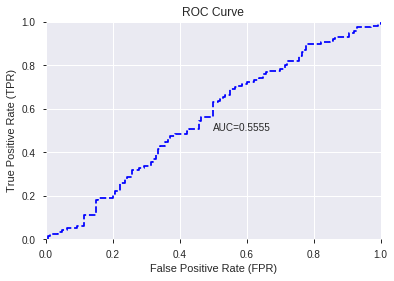

This function is available for GLM models only


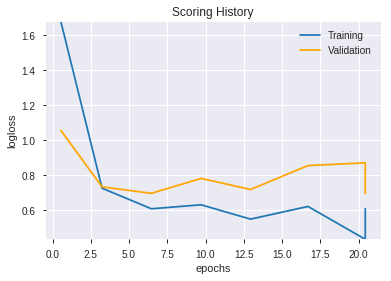

--2019-08-22 16:24:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


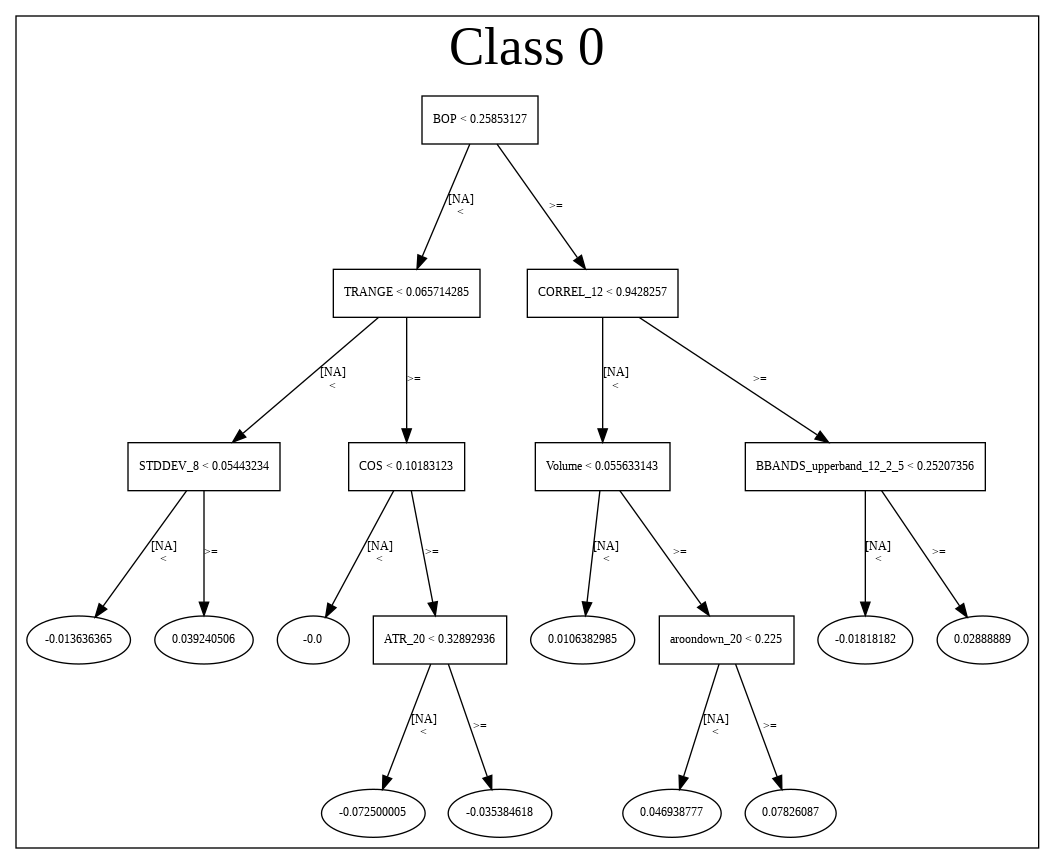

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_161559_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_161559_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'AROONOSC_14',
 'ULTOSC',
 'MINUS_DI_8',
 'STOCHF_fastk',
 'MINUS_DM_8',
 'PLUS_DI_20',
 'STOCH_slowk',
 'BBANDS_lowerband_30_6_3',
 'CORREL_14',
 'STOCHF_fastd',
 'CDLCLOSINGMARUBOZU',
 'CORREL_8',
 'WILLR_24',
 'ROCP_8',
 'CDLSPINNINGTOP',
 'CMO_8',
 'ADX_24',
 'ROC_14',
 'MA_14_6',
 'MACDFIX_12',
 'NATR_24',
 'MACDFIX_signal_14',
 'ROCP_14',
 'DX_8',
 'HT_PHASOR_inphase',
 'MACDEXT_hist',
 'aroonup_20',
 'MACDFIX_hist_20',
 'LINEARREG_ANGLE_14',
 'PLUS_DM_8',
 'MACDFIX_hist_8',
 'BBANDS_upperband_30_7_4',
 'STOCHRSI_fastk',
 'DX_14',
 'LINEARREG_ANGLE_20',
 'MINUS_DM_14',
 'LINEARREG_SLOPE_14',
 'BETA_12',
 'WILLR_12',
 'CCI_20',
 'ADX_14',
 'STOCH_slowd',
 'RSI_24',
 'STOCHRSI_fastd',
 'aroondown_12',
 'RSI_20',
 'BBANDS_upperband_14_4_4',
 'BBANDS_lowerband_20_5_4',
 'PLUS_DM_12',
 'CCI_14',
 'HT_PHASOR_quadrature',
 'ROCR_20',
 'BBANDS_upperband_14_5_2',
 'CORREL_20',
 'MACDFIX_signal_8',
 'MA_14_2',
 'MINUS_DI_14',
 'MINUS_DI_24',
 'CMO_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_162507_model_1  0.554187  0.700152              0.475739  0.502918  0.252927

variable  relative_importance  scaled_importance  percentage
0   BBANDS_middleband_24_6_4             4.051927           1.000000    0.093933
1                     RSI_14             2.462873           0.607828    0.057095
2    BBANDS_lowerband_30_6_3             2.233475           0.551213    0.051777
3                      CMO_8             2.008966           0.495805    0.046572
4                MINUS_DM_14             1.863569           0.459922    0.043202
..                       ...                  ...                ...         ...
78                     DX_14             0.025294           0.006242    0.000586
79                 CORREL_20             0.022762           0.005618    0.000528
80                   ROCR_20             0.022206           0.005480    0.000515
81                   BETA_12             0.010410           0.002569    0.000241
82            CDLSPINNINGTOP             0.002696           0.000665    0.000063

[83 rows x 4 columns]

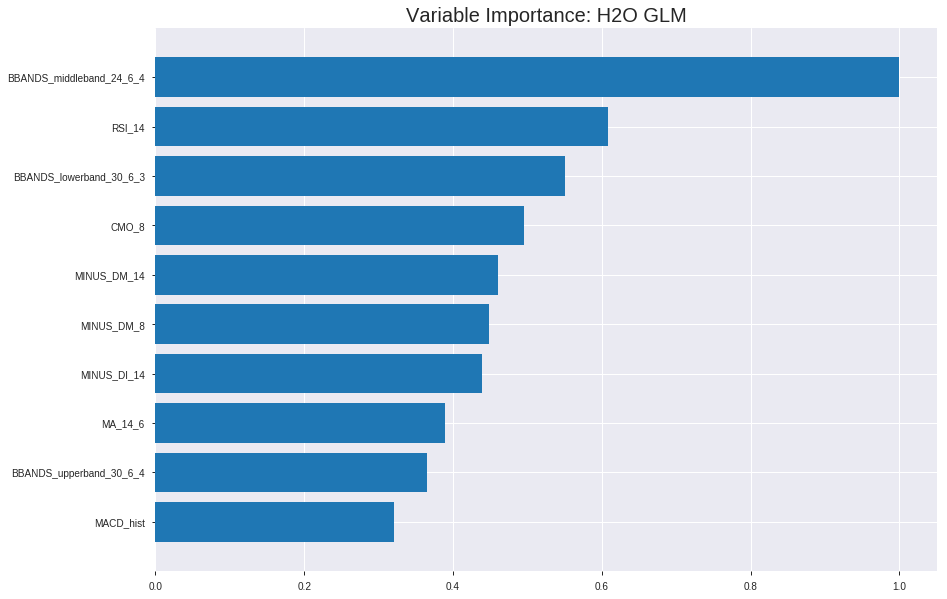

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_162507_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22392438715137972
RMSE: 0.4732064952548514
LogLoss: 0.6381418669156159
Null degrees of freedom: 1786
Residual degrees of freedom: 1703
Null deviance: 2477.1462973227917
Residual deviance: 2280.7190323564114
AIC: 2448.7190323564114
AUC: 0.6827251431220013
pr_auc: 0.6524987432237723
Gini: 0.36545028624400255
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32633926168328337: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      237  665   0.7373   (665.0/902.0)
1      63   822   0.0712   (63.0/885.0)
Total  300  1487  0.4074   (728.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326339     0.693086  305
max f2                       0.225691     0.835567  358
max f0point5                 0.476327     0.633196  212
max accuracy                 0.476327     0.637941  212
max precision                0.941284     1         0
max recall                   0.107723     1         393
max specificity              0.941284     1         0
max absolute_mcc             0.450837     0.284477  229
max min_per_class_accuracy   0.518468     0.629712  183
max mean_per_class_accuracy  0.472377     0.638893  215

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.830761           1.68267   1.68267            0.833333         0.876417  0.833333                    0.876417            0.0169492       0.0169492                  68.2674   68.2674
    2        0.0201455                   0.80064            1.79485   1.73876            0.888889         0.815166  0.861111                    0.845791            0.0180791       0.0350282                  79.4852   73.8763
    3        0.0302182                   0.771756           1.34614   1.60789            0.666667         0.787268  0.796296                    0.826284            0.0135593       0.0485876                  34.6139   60.7889
    4        0.040291                    0.752669           1.5705    1.59854            0.777778         0.762187  0.791667                    0.810259            0.0158192       0.0644068                  57.0496   59.854
    5        0.0503637                   0.738825           0.897426  1.45832            0.444444         0.744527  0.722222                    0.797113            0.00903955      0.0734463                  -10.2574  45.8318
    6        0.100168                    0.685337           1.42933   1.4439             0.707865         0.70994   0.715084                    0.75377             0.0711864       0.144633                   42.9328   44.3904
    7        0.149972                    0.654165           1.42933   1.43906            0.707865         0.669375  0.712687                    0.725743            0.0711864       0.215819                   42.9328   43.9063
    8        0.200336                    0.630445           1.27883   1.39878            0.633333         0.641509  0.692737                    0.704567            0.0644068       0.280226                   27.8832   39.8782
    9        0.299944                    0.585928           1.2932    1.36372            0.640449         0.608394  0.675373                    0.672629            0.128814        0.40904                    29.3201   36.372
    10       0.400112                    0.55089            1.08293   1.29342            0.536313         0.567752  0.640559                    0.646373            0.108475        0.517514                   8.29278   29.3423
    11       0.50028                     0.517767           1.13933   1.26257            0.564246         0.534417  0.62528                     0.623957            0.114124        0.631638                   13.933    26.257
    12       0.599888                    0.471085           1.08901   1.23375            0.539326         0.494902  0.611007                    0.602528            0.108475        0.740113                   8.90116   23.3752
    13       0.700056                    0.412836           0.755793  1.16536            0.374302         0.442144  0.577138                    0.579579            0.0757062       0.815819                   -24.4207  16.5363
    14       0.799664                    0.348378           0.873478  1.129              0.432584         0.381589  0.559132                    0.554917            0.0870056       0.902825                   -12.6522  12.9005
    15       0.899832                    0.266973           0.665549  1.07741            0.329609         0.308858  0.533582                    0.527526            0.0666667       0.969492                   -33.4451  7.74138
    16       1                           0.0112601          0.304573  1                  0.150838         0.205239  0.495243                    0.495243            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.233763393062601
RMSE: 0.4834908407225529
LogLoss: 0.6597790795272066
Null degrees of freedom: 509
Residual degrees of freedom: 426
Null deviance: 707.665141278386
Residual deviance: 672.9746611177508
AIC: 840.9746611177508
AUC: 0.6441893498432892
pr_auc: 0.6483015876693096
Gini: 0.2883786996865785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.356820859093204: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      55   184  0.7699   (184.0/239.0)
1      19   252  0.0701   (19.0/271.0)
Total  74   436  0.398    (203.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356821     0.712871  331
max f2                       0.195188     0.852738  394
max f0point5                 0.548455     0.634361  167
max accuracy                 0.548455     0.609804  167
max precision                0.758276     0.857143  6
max recall                   0.195188     1         394
max specificity              0.803148     0.995816  0
max absolute_mcc             0.548455     0.232391  167
max min_per_class_accuracy   0.516026     0.605166  197
max mean_per_class_accuracy  0.548455     0.615055  167

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.759555           1.56827   1.56827            0.833333         0.78344   0.833333                    0.78344             0.0184502       0.0184502                  56.8266   56.8266
    2        0.0215686                   0.740766           1.50554   1.53975            0.8              0.751333  0.818182                    0.768846            0.0147601       0.0332103                  50.5535   53.9752
    3        0.0313725                   0.716251           1.50554   1.52906            0.8              0.724247  0.8125                      0.754909            0.0147601       0.0479705                  50.5535   52.9059
    4        0.0411765                   0.712342           1.12915   1.43384            0.6              0.715159  0.761905                    0.745444            0.0110701       0.0590406                  12.9151   43.3843
    5        0.0509804                   0.704027           1.12915   1.37525            0.6              0.708905  0.730769                    0.738418            0.0110701       0.0701107                  12.9151   37.5248
    6        0.1                         0.673941           1.20443   1.29151            0.64             0.688155  0.686275                    0.713779            0.0590406       0.129151                   20.4428   29.1513
    7        0.15098                     0.65116            1.37525   1.31979            0.730769         0.661892  0.701299                    0.696259            0.0701107       0.199262                   37.5248   31.9787
    8        0.2                         0.63265            1.2797    1.30996            0.68             0.640582  0.696078                    0.682613            0.0627306       0.261993                   27.9705   30.9963
    9        0.3                         0.594314           1.29151   1.30381            0.686275         0.615308  0.69281                     0.660178            0.129151        0.391144                   29.1513   30.3813
    10       0.4                         0.558775           1.10701   1.25461            0.588235         0.575329  0.666667                    0.638966            0.110701        0.501845                   10.7011   25.4613
    11       0.5                         0.516872           0.95941   1.19557            0.509804         0.537663  0.635294                    0.618705            0.095941        0.597786                   -4.05904  19.5572
    12       0.6                         0.481915           0.922509  1.15006            0.490196         0.500422  0.611111                    0.598991            0.0922509       0.690037                   -7.74908  15.0062
    13       0.7                         0.434189           0.885609  1.11228            0.470588         0.459174  0.591036                    0.579017            0.0885609       0.778598                   -11.4391  11.2283
    14       0.8                         0.380387           1.07011   1.10701            0.568627         0.407952  0.588235                    0.557634            0.107011        0.885609                   7.01107   10.7011
    15       0.9                         0.326496           0.590406  1.04961            0.313725         0.356793  0.557734                    0.535319            0.0590406       0.944649                   -40.9594  4.96105
    16       1                           0.156086           0.553506  1                  0.294118         0.26336   0.531373                    0.508123         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:25:07  0.000 sec   2            .8E1      83            1.3807630541980542  1.3832200550524836
     2019-08-22 16:25:07  0.081 sec   4            .5E1      84            1.3780621441293919  1.3811164509367442
     2019-08-22 16:25:07  0.153 sec   6            .31E1     84            1.3741855435113612  1.3782122060137454
     2019-08-22 16:25:07  0.203 sec   8            .19E1     84            1.368780484400618   1.374348361935712
     2019-08-22 16:25:07  0.271 sec   10           .12E1     84            1.361646226703377   1.3695056965925116
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:25:09  1.576 sec   52           .54E-4    84            1.2773669135929984  1.3211571075217177
     2019-08-22 16:25:09  1.600 sec   53           .33E-4    84            1.2770804901763242  1.320725923611492
     2019-08-22 16:25:09  1.667 sec   55           .21E-4    84            1.2766219119660636  1.3200640951636144
     2019-08-22 16:25:09  1.698 sec   56           .13E-4    84            1.2764422565830287  1.3198100883122532
     2019-08-22 16:25:09  1.735 sec   57           .8E-5     84            1.2762837338312316  1.3195581590544132


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.56640625)

('F1', 0.6336088154269972)

('auc', 0.5541871921182266)

('logloss', 0.7001520276671662)

('mean_per_class_error', 0.43620689655172407)

('rmse', 0.5029184912969075)

('mse', 0.2529270088883576)

glm prediction progress: |████████████████████████████████████████████████| 100%


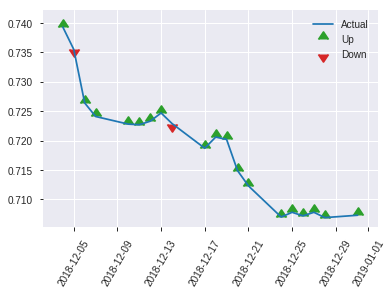


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2529270088883576
RMSE: 0.5029184912969075
LogLoss: 0.7001520276671662
Null degrees of freedom: 255
Residual degrees of freedom: 172
Null deviance: 354.4578805022527
Residual deviance: 358.4778381655891
AIC: 526.4778381655891
AUC: 0.5541871921182266
pr_auc: 0.49907686811796265
Gini: 0.10837438423645329
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23737848373225146: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    132  0.9429   (132.0/140.0)
1      1    115  0.0086   (1.0/116.0)
Total  9    247  0.5195   (133.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.237378     0.633609  246
max f2                       0.237378     0.80872   246
max f0point5                 0.485606     0.52673   129
max accuracy                 0.661849     0.566406  20
max precision                0.811472     1         0
max recall                   0.174        1         253
max specificity              0.811472     1         0
max absolute_mcc             0.237378     0.131149  246
max min_per_class_accuracy   0.48705      0.55      126
max mean_per_class_accuracy  0.485606     0.563793  129

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 47.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.727022           1.47126   1.47126            0.666667         0.784857  0.666667                    0.784857            0.0172414       0.0172414                  47.1264   47.1264
    2        0.0234375                   0.70317            1.47126   1.47126            0.666667         0.705949  0.666667                    0.745403            0.0172414       0.0344828                  47.1264   47.1264
    3        0.03125                     0.691142           1.10345   1.37931            0.5              0.691536  0.625                       0.731937            0.00862069      0.0431034                  10.3448   37.931
    4        0.0429688                   0.687492           1.47126   1.40439            0.666667         0.68938   0.636364                    0.72033             0.0172414       0.0603448                  47.1264   40.4389
    5        0.0507812                   0.683132           0         1.18833            0                0.685067  0.538462                    0.714905            0               0.0603448                  -100      18.8329
    6        0.101562                    0.643551           1.18833   1.18833            0.538462         0.660798  0.538462                    0.687852            0.0603448       0.12069                    18.8329   18.8329
    7        0.152344                    0.613395           1.18833   1.18833            0.538462         0.626956  0.538462                    0.667553            0.0603448       0.181034                   18.8329   18.8329
    8        0.203125                    0.594403           0.679045  1.06101            0.307692         0.602971  0.480769                    0.651408            0.0344828       0.215517                   -32.0955  6.1008
    9        0.300781                    0.555988           1.14759   1.08912            0.52             0.574628  0.493506                    0.626479            0.112069        0.327586                   14.7586   8.91178
    10       0.402344                    0.518121           1.18833   1.11416            0.538462         0.535243  0.504854                    0.603449            0.12069         0.448276                   18.8329   11.4161
    11       0.5                         0.486691           1.14759   1.12069            0.52             0.500385  0.507812                    0.583319            0.112069        0.560345                   14.7586   12.069
    12       0.601562                    0.445946           0.848806  1.07479            0.384615         0.461849  0.487013                    0.562811            0.0862069       0.646552                   -15.1194  7.47873
    13       0.699219                    0.404286           0.706207  1.02331            0.32             0.423105  0.463687                    0.543299            0.0689655       0.715517                   -29.3793  2.33096
    14       0.800781                    0.336196           1.10345   1.03347            0.5              0.364758  0.468293                    0.520655            0.112069        0.827586                   10.3448   3.34735
    15       0.898438                    0.28334            0.971034  1.02669            0.44             0.30891   0.465217                    0.497639            0.0948276       0.922414                   -2.89655  2.66867
    16       1                           0.15689            0.763926  1                  0.346154         0.239168  0.453125                    0.471388            

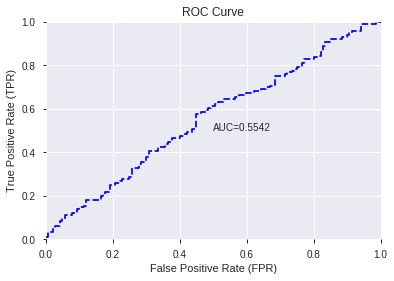

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


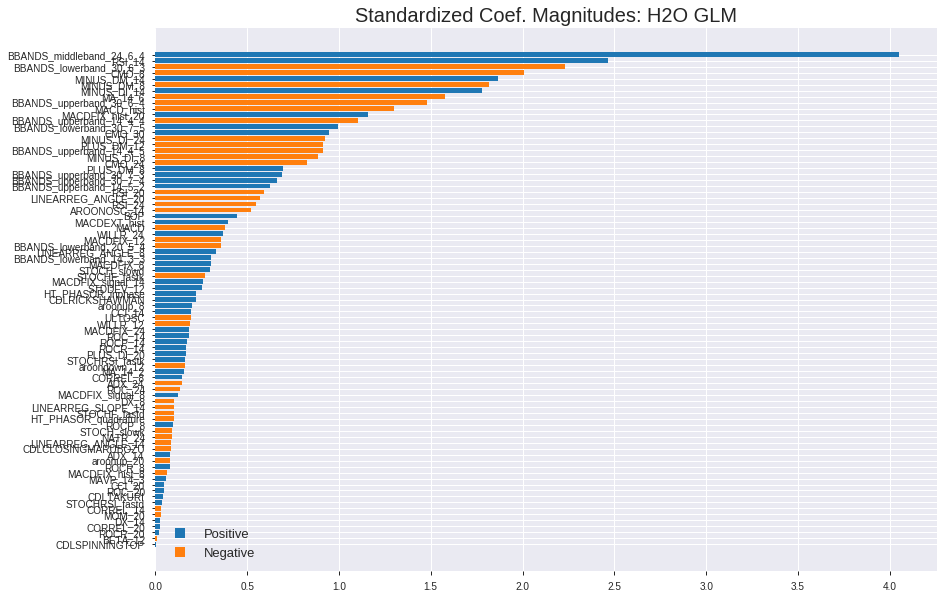

'log_likelihood'
--2019-08-22 16:25:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


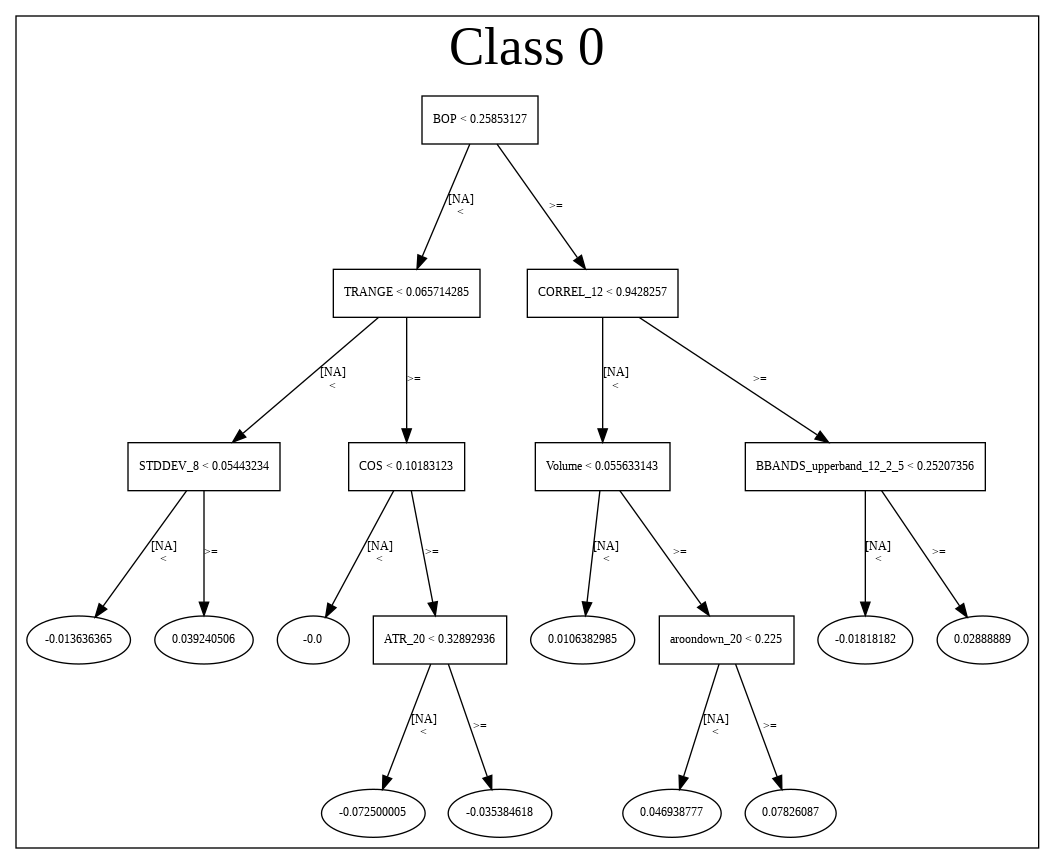

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_162507_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_162507_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BBANDS_middleband_24_6_4',
 'RSI_14',
 'BBANDS_lowerband_30_6_3',
 'CMO_8',
 'MINUS_DM_14',
 'MINUS_DM_8',
 'MINUS_DI_14',
 'MA_14_6',
 'BBANDS_upperband_30_6_4',
 'MACD_hist',
 'MACDFIX_hist_20',
 'BBANDS_upperband_14_4_4',
 'BBANDS_lowerband_30_7_5',
 'CMO_30',
 'MINUS_DI_24',
 'PLUS_DM_12',
 'BBANDS_upperband_14_4_5',
 'MINUS_DI_8',
 'CMO_24',
 'PLUS_DM_8',
 'BBANDS_upperband_30_7_3',
 'BBANDS_upperband_30_7_4',
 'BBANDS_upperband_14_5_2',
 'RSI_20',
 'LINEARREG_ANGLE_20',
 'RSI_24',
 'AROONOSC_14',
 'BOP',
 'MACDEXT_hist',
 'MACD',
 'WILLR_24',
 'MACDFIX_12',
 'BBANDS_lowerband_20_5_4',
 'LINEARREG_ANGLE_8',
 'BBANDS_lowerband_14_3_3',
 'MACDFIX_8',
 'STOCH_slowd',
 'STOCHF_fastk',
 'MACDFIX_signal_14',
 'STDDEV_12',
 'HT_PHASOR_inphase',
 'CDLRICKSHAWMAN',
 'aroonup_8',
 'CCI_14',
 'ULTOSC',
 'WILLR_12',
 'MACDFIX_24',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'PLUS_DI_20',
 'STOCHRSI_fastk',
 'aroondown_12',
 'MA_14_2',
 'CORREL_8',
 'ADX_24',
 'ROC_24',
 'MACDFIX_signal_8',
 'DX_8',

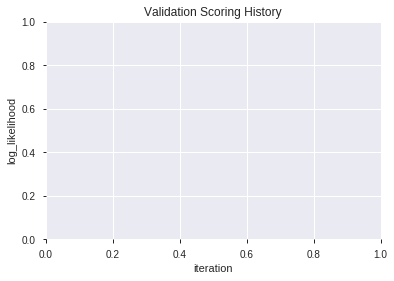

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_162525_model_3  0.583436  0.685569              0.465025  0.496047  0.246063
1               XGBoost_3_AutoML_20190822_162525  0.583190  0.692706              0.463670  0.499087  0.249088
2  XGBoost_grid_1_AutoML_20190822_162525_model_2  0.569150  0.690699              0.473645  0.498582  0.248585
3               XGBoost_2_AutoML_20190822_162525  0.556527  0.704769              0.463670  0.504938  0.254963
4  XGBoost_grid_1_AutoML_20190822_162525_model_1  0.556496  0.699207              0.445936  0.502491  0.252498
5  XGBoost_grid_1_AutoML_20190822_162525_model_4  0.555234  0.690130              0.449507  0.498469  0.248472
6  XGBoost_grid_1_AutoML_20190822_162525_model_5  0.553387  0.726203              0.492857  0.513610  0.263796
7               XGBoost_1_AutoML_20190822_162525  0.548276  0.706924              0.444458  0.505930  0.255965
8  XGBoost_grid_1_AutoML_20190822_162525_model_6  0.543596  0.707146              0.465148  0.506207  0.256246
9  XGBoost_grid_1_AutoML_20190822_162525_model_7  0.540517  0.716297              0.470813  0.510334  0.260441

variable  relative_importance  scaled_importance  percentage
0                       BOP           532.752625           1.000000    0.097693
1                    ULTOSC           350.992798           0.658829    0.064363
2              STOCHF_fastk           329.863403           0.619168    0.060488
3                    ADX_14           175.738419           0.329869    0.032226
4                  WILLR_12           164.504639           0.308782    0.030166
..                      ...                  ...                ...         ...
76                   RSI_20            14.183380           0.026623    0.002601
77  BBANDS_upperband_30_7_3            12.433616           0.023338    0.002280
78                     MACD             5.778233           0.010846    0.001060
79               MACDFIX_24             4.466505           0.008384    0.000819
80           CDLSPINNINGTOP             0.895158           0.001680    0.000164

[81 rows x 4 columns]

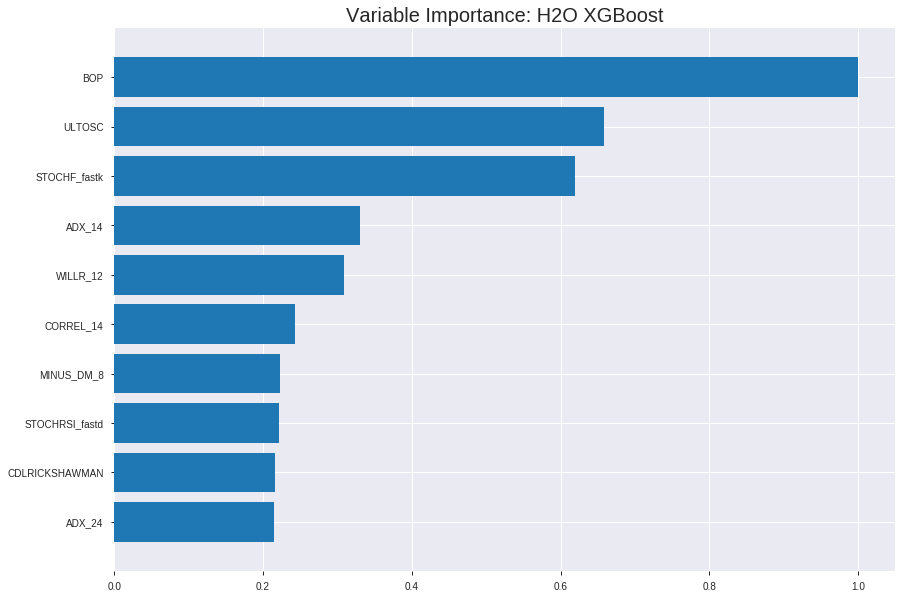

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_162525_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17752469766346005
RMSE: 0.4213367983732967
LogLoss: 0.5416613000027187
Mean Per-Class Error: 0.1839690831422952
AUC: 0.9019623686221454
pr_auc: 0.9029877440298393
Gini: 0.8039247372442908
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48170648217201234: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      692  210  0.2328   (210.0/902.0)
1      128  757  0.1446   (128.0/885.0)
Total  820  967  0.1891   (338.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481706     0.817495  214
max f2                       0.392385     0.885703  282
max f0point5                 0.541232     0.834017  164
max accuracy                 0.518202     0.816452  184
max precision                0.8405       1         0
max recall                   0.327674     1         330
max specificity              0.8405       1         0
max absolute_mcc             0.518202     0.634879  184
max min_per_class_accuracy   0.498105     0.812429  200
max mean_per_class_accuracy  0.518202     0.816031  184

Gains/Lift Table: Avg response rate: 49.52 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.776773           2.01921   2.01921            1                0.802557  1                           0.802557            0.020339        0.020339                   101.921   101.921
    2        0.0201455                   0.744553           2.01921   2.01921            1                0.761267  1                           0.781912            0.020339        0.040678                   101.921   101.921
    3        0.0302182                   0.731622           2.01921   2.01921            1                0.739692  1                           0.767839            0.020339        0.0610169                  101.921   101.921
    4        0.040291                    0.718745           2.01921   2.01921            1                0.72354   1                           0.756764            0.020339        0.0813559                  101.921   101.921
    5        0.0503637                   0.710014           2.01921   2.01921            1                0.713791  1                           0.748169            0.020339        0.101695                   101.921   101.921
    6        0.100168                    0.667811           1.99652   2.00793            0.988764         0.687458  0.994413                    0.717983            0.099435        0.20113                    99.6521   100.793
    7        0.149972                    0.639088           1.90577   1.974              0.94382          0.653425  0.977612                    0.696544            0.0949153       0.296045                   90.577    97.4003
    8        0.200336                    0.615481           1.9519    1.96845            0.966667         0.626861  0.97486                     0.679026            0.0983051       0.39435                    95.1902   96.8447
    9        0.299944                    0.574884           1.62217   1.85345            0.803371         0.593553  0.91791                     0.650641            0.161582        0.555932                   62.2174   85.3453
    10       0.400112                    0.535444           1.46646   1.75657            0.726257         0.554874  0.86993                     0.626666            0.146893        0.702825                   46.6465   75.6571
    11       0.50028                     0.496074           1.16189   1.6375             0.575419         0.517251  0.810962                    0.604759            0.116384        0.819209                   16.1891   63.7502
    12       0.599888                    0.461122           0.816759  1.50122            0.404494         0.478409  0.74347                     0.583779            0.0813559       0.900565                   -18.3241  50.1222
    13       0.700056                    0.421575           0.507622  1.35905            0.251397         0.442117  0.673062                    0.563509            0.0508475       0.951412                   -49.2378  35.9052
    14       0.799664                    0.375599           0.385692  1.23781            0.191011         0.399841  0.613016                    0.543122            0.0384181       0.989831                   -61.4308  23.7808
    15       0.899832                    0.320039           0.101524  1.11132            0.0502793        0.347983  0.550373                    0.521399            0.0101695       1                          -89.8476  11.1318
    16       1                           0.154321           0         1                  0                0.265307  0.495243                    0.495747         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24620591018961174
RMSE: 0.4961914047921545
LogLoss: 0.6852058998710203
Mean Per-Class Error: 0.39113619169664493
AUC: 0.6043014405039447
pr_auc: 0.6094361158632409
Gini: 0.20860288100788948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.339046910405159: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   202  0.8452   (202.0/239.0)
1      10   261  0.0369   (10.0/271.0)
Total  47   463  0.4157   (212.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339047     0.711172  357
max f2                       0.294075     0.852738  394
max f0point5                 0.436969     0.63568   228
max accuracy                 0.436969     0.613725  228
max precision                0.71092      1         0
max recall                   0.294075     1         394
max specificity              0.71092      1         0
max absolute_mcc             0.436969     0.220456  228
max min_per_class_accuracy   0.451214     0.58159   203
max mean_per_class_accuracy  0.436969     0.608864  228

Gains/Lift Table: Avg response rate: 53.14 %, avg score: 45.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.68766            1.88192   1.88192            1                0.700358  1                           0.700358            0.0221402       0.0221402                  88.1919   88.1919
    2        0.0215686                   0.659307           0.376384  1.19758            0.2              0.668324  0.636364                    0.685797            0.00369004      0.0258303                  -62.3616  19.7585
    3        0.0313725                   0.636465           1.50554   1.29382            0.8              0.644332  0.6875                      0.672839            0.0147601       0.0405904                  50.5535   29.3819
    4        0.0411765                   0.620698           0.752768  1.165              0.4              0.625961  0.619048                    0.661678            0.00738007      0.0479705                  -24.7232  16.4997
    5        0.0509804                   0.61187            1.12915   1.1581             0.6              0.615667  0.615385                    0.65283             0.0110701       0.0590406                  12.9151   15.8104
    6        0.1                         0.580746           1.2797    1.21771            0.68             0.594885  0.647059                    0.624425            0.0627306       0.121771                   27.9705   21.7712
    7        0.15098                     0.554182           1.37525   1.27091            0.730769         0.566604  0.675325                    0.604901            0.0701107       0.191882                   37.5248   27.0906
    8        0.2                         0.535719           0.828044  1.16236            0.44             0.544029  0.617647                    0.589981            0.0405904       0.232472                   -17.1956  16.2362
    9        0.3                         0.497098           0.95941   1.09471            0.509804         0.517234  0.581699                    0.565732            0.095941        0.328413                   -4.05904  9.47109
    10       0.4                         0.474188           1.18081   1.11624            0.627451         0.484887  0.593137                    0.545521            0.118081        0.446494                   18.0812   11.6236
    11       0.5                         0.452643           1.25461   1.14391            0.666667         0.464032  0.607843                    0.529223            0.125461        0.571956                   25.4613   14.3911
    12       0.6                         0.433634           1.21771   1.15621            0.647059         0.443919  0.614379                    0.515006            0.121771        0.693727                   21.7712   15.6212
    13       0.7                         0.403871           0.664207  1.08593            0.352941         0.417063  0.577031                    0.501014            0.0664207       0.760148                   -33.5793  8.59251
    14       0.8                         0.376599           1.03321   1.07934            0.54902          0.390788  0.573529                    0.487236            0.103321        0.863469                   3.32103   7.93358
    15       0.9                         0.341564           0.922509  1.06191            0.490196         0.358838  0.56427                     0.472969            0.0922509       0.95572                    -7.74908  6.19106
    16       1                           0.265444           0.442804  1                  0.235294         0.318814  0.531373                    0.457554         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:25:32  2.093 sec   0                  0.5              0.693147            0.5             0                  1                0.504757                         0.5                0.693147              0.5               0                    1                  0.468627
    2019-08-22 16:25:32  2.260 sec   5                  0.489256         0.67183             0.747255        0.731251           1.90703          0.351987                         0.497198           0.687548              0.589341          0.608908             1.25461            0.445098
    2019-08-22 16:25:32  2.337 sec   10                 0.478526         0.650822            0.800941        0.791521           2.01921          0.302182                         0.495978           0.685101              0.594266          0.602452             1.25461            0.429412
    2019-08-22 16:25:32  2.426 sec   15                 0.469361         0.632998            0.820643        0.816694           2.01921          0.266368                         0.494154           0.681425              0.606332          0.617589             1.25461            0.423529
    2019-08-22 16:25:33  2.514 sec   20                 0.461011         0.616846            0.830583        0.828493           2.01921          0.266368                         0.493476           0.680001              0.612685          0.620076             1.56827            0.409804
    2019-08-22 16:25:33  2.604 sec   25                 0.453225         0.60186             0.846392        0.843887           2.01921          0.241186                         0.492464           0.677981              0.616645          0.615067             0.940959           0.433333
    2019-08-22 16:25:33  2.702 sec   30                 0.445258         0.586672            0.86753         0.8645             2.01921          0.231673                         0.49457            0.682158              0.609983          0.603697             1.25461            0.431373
    2019-08-22 16:25:33  2.806 sec   35                 0.439564         0.575984            0.877104        0.874342           2.01921          0.220481                         0.495503           0.684025              0.600388          0.602534             0.940959           0.429412
    2019-08-22 16:25:33  2.903 sec   40                 0.43456          0.566332            0.882305        0.879154           2.01921          0.209849                         0.49696            0.686955              0.598218          0.600318             1.25461            0.435294
    2019-08-22 16:25:33  3.006 sec   45                 0.426728         0.551785            0.894483        0.894293           2.01921          0.195859                         0.497313           0.687575              0.59933           0.605974             1.56827            0.409804
    2019-08-22 16:25:33  3.116 sec   50                 0.421337         0.541661            0.901962        0.902988           2.01921          0.189144                         0.496191           0.685206              0.604301          0.609436             1.88192            0.415686

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      532.7526245117188      1.0                    0.09769296422207975
ULTOSC                   350.9927978515625      0.6588288479540693     0.06436294307165091
STOCHF_fastk             329.8634033203125      0.6191680493787162     0.06048836209540983
ADX_14                   175.73841857910156     0.3298687054618835     0.03222585164067155
WILLR_12                 164.504638671875       0.30878240876363144    0.030165868811753056
---                      ---                    ---                    ---
RSI_20                   14.183380126953125     0.026622825443520907   0.0026008627335445626
BBANDS_upperband_30_7_3  12.433615684509277     0.023338440980755375   0.0022800014797320547
MACD                     5.778233051300049      0.010845996407049042   0.0010595775389466476
MACDFIX_24               4.46650505065918       0.008383825522685776   0.0008190407668319006
CDLSPINNINGTOP           0.8951578140258789     0.0016802504067367358  0.0001641486428694669


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.58984375)

('F1', 0.6388888888888888)

('auc', 0.583435960591133)

('logloss', 0.6855686708023194)

('mean_per_class_error', 0.41416256157635467)

('rmse', 0.4960469659955697)

('mse', 0.2460625924734099)

xgboost prediction progress: |████████████████████████████████████████████| 100%


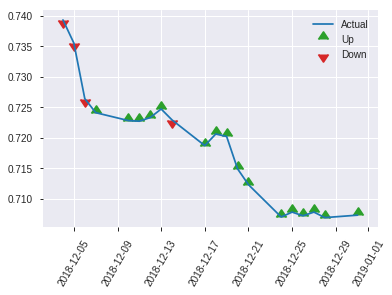


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2460625924734099
RMSE: 0.4960469659955697
LogLoss: 0.6855686708023194
Mean Per-Class Error: 0.41416256157635467
AUC: 0.583435960591133
pr_auc: 0.4915843026958364
Gini: 0.16687192118226601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28553450107574463: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   129  0.9214   (129.0/140.0)
1      1    115  0.0086   (1.0/116.0)
Total  12   244  0.5078   (130.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285535     0.638889  243
max f2                       0.276176     0.814607  247
max f0point5                 0.481399     0.546875  114
max accuracy                 0.481399     0.589844  114
max precision                0.588201     0.5625    47
max recall                   0.276176     1         247
max specificity              0.726174     0.992857  0
max absolute_mcc             0.481399     0.171807  114
max min_per_class_accuracy   0.471529     0.577586  124
max mean_per_class_accuracy  0.481399     0.585837  114

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 47.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.70923            0         0                  0                0.718952  0                           0.718952            0               0                          -100      -100
    2        0.0234375                   0.698508           0.735632  0.367816           0.333333         0.701822  0.166667                    0.710387            0.00862069      0.00862069                 -26.4368  -63.2184
    3        0.03125                     0.687701           1.10345   0.551724           0.5              0.691363  0.25                        0.705631            0.00862069      0.0172414                  10.3448   -44.8276
    4        0.0429688                   0.680772           1.47126   0.802508           0.666667         0.683379  0.363636                    0.699563            0.0172414       0.0344828                  47.1264   -19.7492
    5        0.0507812                   0.663239           1.10345   0.848806           0.5              0.673131  0.384615                    0.695496            0.00862069      0.0431034                  10.3448   -15.1194
    6        0.101562                    0.637199           1.01857   0.933687           0.461538         0.648414  0.423077                    0.671955            0.0517241       0.0948276                  1.85676   -6.6313
    7        0.152344                    0.603551           1.69761   1.18833            0.769231         0.620205  0.538462                    0.654705            0.0862069       0.181034                   69.7613   18.8329
    8        0.203125                    0.585934           1.01857   1.14589            0.461538         0.591788  0.519231                    0.638976            0.0517241       0.232759                   1.85676   14.5889
    9        0.300781                    0.534375           1.23586   1.1751             0.56             0.555734  0.532468                    0.611949            0.12069         0.353448                   23.5862   17.5101
    10       0.402344                    0.494371           1.10345   1.15701            0.5              0.512278  0.524272                    0.586789            0.112069        0.465517                   10.3448   15.7014
    11       0.5                         0.46652            1.23586   1.17241            0.56             0.481614  0.53125                     0.566247            0.12069         0.586207                   23.5862   17.2414
    12       0.601562                    0.431445           0.763926  1.10345            0.346154         0.446401  0.5                         0.546014            0.0775862       0.663793                   -23.6074  10.3448
    13       0.699219                    0.406697           0.971034  1.08495            0.44             0.418644  0.49162                     0.528225            0.0948276       0.758621                   -2.89655  8.49547
    14       0.800781                    0.373019           0.933687  1.06577            0.423077         0.388917  0.482927                    0.510556            0.0948276       0.853448                   -6.6313   6.57696
    15       0.898438                    0.329313           0.706207  1.02669            0.32             0.354898  0.465217                    0.493637            0.0689655       0.922414                   -29.3793  2.66867
    16       1                           0.223101           0.763926  1                  0.346154         0.288578  0.453125                    0.472811        

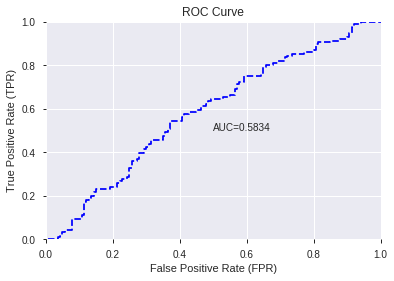

This function is available for GLM models only


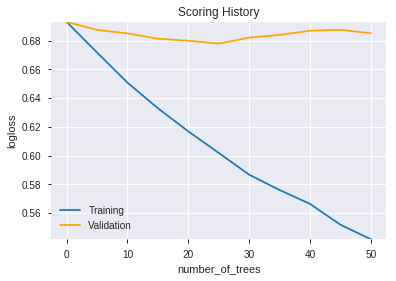

--2019-08-22 16:25:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

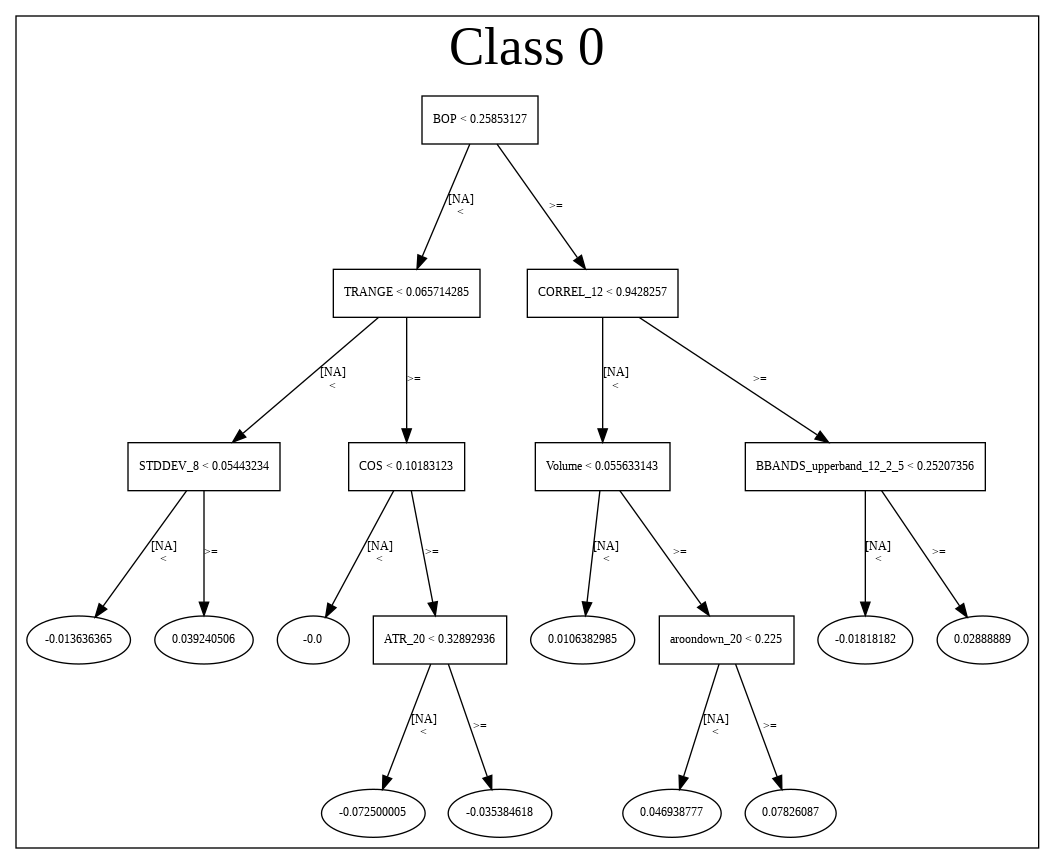

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_162525_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_162525_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b4a5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'ULTOSC',
 'STOCHF_fastk',
 'ADX_14',
 'WILLR_12',
 'CORREL_14',
 'MINUS_DM_8',
 'STOCHRSI_fastd',
 'CDLRICKSHAWMAN',
 'ADX_24',
 'STOCH_slowk',
 'BETA_12',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CORREL_20',
 'PLUS_DM_12',
 'PLUS_DM_8',
 'MINUS_DI_8',
 'MINUS_DI_14',
 'DX_8',
 'STOCHRSI_fastk',
 'CORREL_8',
 'LINEARREG_ANGLE_8',
 'DX_14',
 'MACDFIX_hist_20',
 'STDDEV_12',
 'BBANDS_lowerband_20_5_4',
 'MINUS_DM_14',
 'PLUS_DI_20',
 'BBANDS_upperband_30_6_4',
 'MINUS_DI_24',
 'CCI_14',
 'MACDFIX_signal_14',
 'aroonup_20',
 'BBANDS_lowerband_30_7_5',
 'MACDFIX_signal_8',
 'CMO_24',
 'MOM_20',
 'CCI_20',
 'LINEARREG_ANGLE_20',
 'WILLR_24',
 'BBANDS_middleband_24_6_4',
 'ROC_20',
 'MA_14_2',
 'MACDEXT_hist',
 'LINEARREG_SLOPE_14',
 'NATR_24',
 'BBANDS_lowerband_30_6_3',
 'LINEARREG_ANGLE_14',
 'MA_14_6',
 'MACD_hist',
 'ROC_14',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowd',
 'MACDFIX_hist_8',
 'CMO_30',
 'RSI_24',
 'BBANDS_upperband_14_5_2',
 'MACDFIX_12',
 'BBANDS_lowerband_14_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.605
GLM             0.590
XGBoost         0.602
dtype: float64

DeepLearning    GLM  XGBoost
All          0.605  0.590    0.602
DLF          0.566  0.574    0.586
Fwe          0.586  0.586    0.578
RFE          0.559  0.566    0.590
XGBF         0.594  0.574    0.586





F1


DeepLearning    0.644
GLM             0.642
XGBoost         0.642
dtype: float64

DeepLearning    GLM  XGBoost
All          0.627  0.642    0.642
DLF          0.626  0.639    0.642
Fwe          0.635  0.635    0.639
RFE          0.632  0.634    0.639
XGBF         0.644  0.639    0.642





auc


DeepLearning    0.582
GLM             0.576
XGBoost         0.591
dtype: float64

DeepLearning    GLM  XGBoost
All          0.582  0.570    0.591
DLF          0.560  0.562    0.574
Fwe          0.578  0.576    0.551
RFE          0.556  0.554    0.583
XGBF         0.563  0.562    0.574





logloss


DeepLearning    0.803
GLM             0.700
XGBoost         0.704
dtype: float64

DeepLearning    GLM  XGBoost
All          0.803  0.686    0.693
DLF          0.692  0.698    0.704
Fwe          0.694  0.692    0.698
RFE          0.697  0.700    0.686
XGBF         0.691  0.698    0.704





mean_per_class_error


DeepLearning    0.441
GLM             0.445
XGBoost         0.450
dtype: float64

DeepLearning    GLM  XGBoost
All          0.423  0.429    0.407
DLF          0.438  0.445    0.418
Fwe          0.429  0.438    0.450
RFE          0.430  0.436    0.414
XGBF         0.441  0.445    0.418





rmse


DeepLearning    0.546
GLM             0.503
XGBoost         0.504
dtype: float64

DeepLearning    GLM  XGBoost
All          0.546  0.497    0.499
DLF          0.499  0.502    0.504
Fwe          0.500  0.499    0.502
RFE          0.499  0.503    0.496
XGBF         0.499  0.502    0.504





mse


DeepLearning    0.298
GLM             0.253
XGBoost         0.254
dtype: float64

DeepLearning    GLM  XGBoost
All          0.298  0.247    0.249
DLF          0.249  0.252    0.254
Fwe          0.250  0.249    0.252
RFE          0.249  0.253    0.246
XGBF         0.249  0.252    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.627    NaN      NaN
 DLF          0.626    NaN      NaN
 DLF            NaN  0.639      NaN
 DLF            NaN    NaN    0.642
 All            NaN  0.642      NaN
 All            NaN    NaN    0.642
 XGBF         0.644    NaN      NaN
 XGBF           NaN  0.639      NaN
 XGBF           NaN    NaN    0.642
 Fwe          0.635    NaN      NaN
 Fwe            NaN  0.635      NaN
 Fwe            NaN    NaN    0.639
 RFE          0.632    NaN      NaN
 RFE            NaN  0.634      NaN
 RFE            NaN    NaN    0.639,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.605    NaN      NaN
 DLF          0.566    NaN      NaN
 DLF            NaN  0.574      NaN
 DLF            NaN    NaN    0.586
 All            NaN  0.590      NaN
 All            NaN    NaN    0.602
 XGBF         0.594    NaN      NaN
 XGBF           NaN  0.574      NaN
 XGBF           NaN    NaN    0.586
 Fwe          0.586    NaN      NaN
 Fwe     